In [1]:
                                                                                                                                                                                                                                                           import pandas as pd
import numpy as np
import string
import nltk
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity
from utils import cosine_sim ## This only for testing
from utils import get_upper_triangular_values, threshold_transform

In [2]:
df_isp_irc = pd.read_excel('Data/vt_isp_irc.xlsx')
df_isp_task = pd.read_excel('Data/vt_isp_task_mhrs.xlsx')
df_isp_material = pd.read_excel('Data/vt_isp_material_consumption_pricing.xlsx')

df_isq_irc = pd.read_excel('Data/vt_isq_irc.xlsx')
df_isq_task = pd.read_excel('Data/vt_isq_task_mhrs.xlsx')
df_isq_material = pd.read_excel('Data/vt_isq_material_consumption_pricing.xlsx')

df_iux_irc = pd.read_excel('Data/vt_iux_irc.xlsx')
df_iux_task = pd.read_excel('Data/vt_iux_task_mhrs.xlsx')
df_iux_material = pd.read_excel('Data/vt_iux_material_consumption_pricing.xlsx')

In [3]:
df_isp_irc.head(2)                                                                                                            

,DeleteFlag,Type,Log Item #,ATA #,Description,Corrective Action,Discrepancy #,Action,Status,Source Task/Discrep. #,...,Deferral FC,Deferral Parameter,Deferral Value,Deferral Calendar Value,Deferral Calendar,Deferral Item #,Deferral Type,Reason for Deferral,Auth. Ref. #,Message Center
0,No,MIREP,HMV23/000059/0923/1,53,1. DURING INSPECTION OBERVED LH WING SLATE #01...,1. CARRIED OUT INSTALLATION OF LH WING SLAT #0...,HMV23/000059/0923/1,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN
1,No,MIREP,HMV23/000059/0923/2,34,DURING ARRIVAL INSPECTION CHECK FOUND FAILURE ...,CARRIED OUT TROUBLESHOOTING IAW TSM TASK 31-32...,HMV23/000059/0923/2,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN


### Fields to consider in 'VT ISP IRC'
- Planned Start Date
- Planned End Date
- Actual Start Date
- Actual End Date
- Est. Man Hrs.
- Actual Man Hrs.
- Insp Req?
- Mech Req?
- Part Required?
- Contract Classification
- Source Task/Discrep. #
- Description
- Corrective Action
- Log Item #

In [4]:
df_isq_irc.head(2)

,DeleteFlag,Type,Log Item #,ATA #,Description,Corrective Action,Discrepancy #,Action,Status,Source Task/Discrep. #,...,Deferral FC,Deferral Parameter,Deferral Value,Deferral Calendar Value,Deferral Calendar,Deferral Item #,Deferral Type,Reason for Deferral,Auth. Ref. #,Message Center
0,No,MIREP,HMV23/000055/0923/1,57,"DURING ARRIVAL INSPECTION , OBSERVED DENT ON S...",REFER SDIRC HMV23/000055/0923/7 FOR REPAIR DET...,HMV23/000055/0923/1,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN
1,No,MIREP,HMV23/000055/0923/2,53,DURING INSPECTION OBSERVED LH WING SLAT#5 WEAT...,CARRIED OUT INSTALLATION OF LH WING SLAT #5 OU...,HMV23/000055/0923/2,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN


In [5]:
df_iux_irc.head(2)

,DeleteFlag,Type,Log Item #,ATA #,Description,Corrective Action,Discrepancy #,Action,Status,Source Task/Discrep. #,...,Deferral FC,Deferral Parameter,Deferral Value,Deferral Calendar Value,Deferral Calendar,Deferral Item #,Deferral Type,Reason for Deferral,Auth. Ref. #,Message Center
0,No,MIREP,HMV23/000043/0823/1,33,DURING ARRIVAL INSPECTION OBSERVED \n1. RH NAV...,1. RH NAV POSITION LIGHT TROUBLESHOOTING CARRI...,HMV23/000043/0823/1,Close,Closed,AIRCRAFT ARRIVAL INSPECTION,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN
1,No,MIREP,HMV23/000043/0823/2,25,CARRY OUT CA SEATS AND DOOR TRIMS (QTY49) PAIN...,1.FWD AND AFT WALL MOUNTED CABIN ATTENDENT SEA...,HMV23/000043/0823/2,Close,Closed,AWR23/002577/0823,...,NaN,NaN,NaN,NaN,Hours,NaN,NaN,NaN,NaN,NaN


### Tokenize and embed the descriptions of unexpected observations made.

In [6]:
# Download NLTK Resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jupyter/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
#Load spacy en_core_web_sm model
# nlp = spacy.load("en_core_web_sm")

In [1]:
def preprocess_text(text: str, preserve_symbols=[], words_to_remove=['DURING', 'INSPECTION', 'OBSERVED']) -> str:
    '''
    This function performs text preprocessing and returns processed text. 
    It will also accept a list of symbols to preserve.
    Input: text
    Output: text
    '''
    # Define symbols to preserve
    preserve_symbols = set(preserve_symbols)

    for word in words_to_remove:
        text = text.replace(word, ' ')
    
    # Remove punctuation, excluding specified symbols
    custom_translation = str.maketrans('', '', ''.join(set(string.punctuation) - preserve_symbols))
    text = text.translate(custom_translation)
    return text


def tokenization(preprocessed_text: str) -> list:
    '''
    This function performs text tokenization and returns a list of tokens.
    Input: text
    Output: list of tokens
    '''
    sentences = sent_tokenize(preprocessed_text)
    preprocessed_tokens = []

    # Tokenization and stopword removal
    for sentence in sentences:
        tokens = word_tokenize(sentence)
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token.lower() not in stop_words]
        
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        preprocessed_tokens.append(tokens)

    return preprocessed_tokens


def calculate_embeddings(preprocessed_tokens: list) -> list:
    '''
    This function performs text embedding and returns a list of embeddings.
    Input: list of tokens
    Output: list of embeddings
    '''
    # Embedding
    embeddings = []
    for token in preprocessed_tokens:
        sentence = ' '.join(token)
        doc = nlp(sentence)
        sentence_embedding = doc.vector
        embeddings.append(sentence_embedding)

    return embeddings


def main(text: str, preserve_symbols=['-', '/']) -> list:
    '''
    This function performs text preprocessing, tokenization, embedding and returns a list of embeddings.
    Input: text
    Output: list of embeddings
    '''
    preprocessed_text = preprocess_text(text, preserve_symbols)
    preprocessed_tokens = tokenization(preprocessed_text)
    embeddings = calculate_embeddings(preprocessed_tokens)

    return embeddings

In [90]:
df_isp_irc.groupby(by='Source Task/Discrep. #').get_group('AIRCRAFT ARRIVAL INSPECTION')['Description'].tolist()

['1. DURING INSPECTION OBERVED LH WING SLATE #01, TRACK#02 ,#03, #04 UPPER BULB SEAL DAMAGE.SAME TO BE REPLACED.\n\n2. DURING INSPECTION OBSERVED SLAT#02 TRACK #5 PLATE DAMAGE.SAME TO BE REPLACED.',
 'DURING ARRIVAL INSPECTION CHECK FOUND FAILURE MESSAGE IN PFR " NO ADF 1 DATA (INTM) ".',
 'DURING ARRIVAL INSPECTION FOUND STATIC DISCHARGERS DAMAGED AT LOCATION : \n1) LH HORZ STAB TYPE A DISCHARGER QTY# 2 & TYPE B DISCHARGER QTY#3 \n2) RH HORZ STAB TYPE A DISCHARGER QTY#1 \n3)VERTICAL STABILISER TYPE A DISCHARGER QTY 01 & TYPE B DISCHARGER QTY 02.',
 'DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP INOP AT FOLLOWING LOCATION \n1.103VU BATTERY COMPARMENT LAMP FIN: 8LS QTY#1,.\n2. REFUEL/DEFUEL CONTROL PANEL FLOODLIGHT LAMP FIN: 32QU.',
 'DURING ARRIVAL INSPECTION , OBSERVED FOLLOWINS DICREPANCIES.\n\n1) RH SIDE WING NO#1 SLAT, NO.3 TRACK SQURE SEAL UPPER BULB SEAL DEGRADED.\n2) RH SIIDE WING SLAT NO#5 OUT BOARD WEATHER SEAL ERODED. SAME TO BE REPLACED.',
 'DURING INSPECTION FOUND FOLLOWING

### ISP

In [2]:
grouped_df_Description = df_isp_irc.groupby(by='Source Task/Discrep. #')['Description'].apply(lambda x: x.apply(main))
grouped_df_Corrective_Action = df_isp_irc.groupby(by='Source Task/Discrep. #')['Corrective Action'].apply(lambda x: x.apply(main))
df_isp_irc['description_correction'] = df_isp_irc['Description'] +' '+df_isp_irc['Corrective Action']
grouped_df_description_correction = df_isp_irc.groupby(by='Source Task/Discrep. #')['description_correction'].apply(lambda x: x.apply(main))

NameError: name 'df_isp_irc' is not defined

In [92]:
grouped_df_Description

Source Task/Discrep. #         
215222-01-1 (LH)             9     [[-0.5932818, -0.0010883957, -0.05046092, -0.4...
                             12    [[-0.78071886, -0.16903323, 0.12170592, 0.2050...
252100-01-1                  16    [[-0.6071717, -0.045728896, -0.14002277, 0.403...
384241-01-1                  11    [[-0.29012585, -0.25208855, 0.40247178, 0.6032...
531900-03-1                  10    [[-0.5505584, -0.4116526, 0.38711795, 0.066678...
AIRCRAFT ARRIVAL INSPECTION  0     [[-0.62076557, -0.2706989, -0.30009857, 0.5027...
                             1     [[-0.42883492, -0.2616663, -0.093726, 0.251545...
                             2     [[-0.29356578, -0.25122398, -0.45151266, 0.281...
                             3     [[-0.56311464, -0.36715958, -0.12396865, 0.070...
                             4     [[-0.36069342, -0.4691468, -0.3341932, 0.42472...
                             5     [[-0.4279495, -0.52520716, 0.31095126, 0.21888...
                             6   

In [93]:
df_isp_irc['description_embedding'] = grouped_df_Description.explode().tolist()
df_isp_irc['corrective_action_embedding'] = grouped_df_Corrective_Action.explode().tolist()
df_isp_irc['description_correction_embedding'] = grouped_df_description_correction.explode().tolist()

In [94]:
df_isp_irc[['Log Item #', 'Source Task/Discrep. #', 'Description', 'Corrective Action', 'description_embedding', 'corrective_action_embedding', 'description_correction_embedding']].head()

,Log Item #,Source Task/Discrep. #,Description,Corrective Action,description_embedding,corrective_action_embedding,description_correction_embedding
0,HMV23/000059/0923/1,AIRCRAFT ARRIVAL INSPECTION,1. DURING INSPECTION OBERVED LH WING SLATE #01...,1. CARRIED OUT INSTALLATION OF LH WING SLAT #0...,"[-0.5932818, -0.0010883957, -0.05046092, -0.42...","[-0.7883508, -0.48455766, 0.053018823, 0.28613...","[-0.7137893, -0.31926173, 0.0778499, 0.1309406..."
1,HMV23/000059/0923/2,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION CHECK FOUND FAILURE ...,CARRIED OUT TROUBLESHOOTING IAW TSM TASK 31-32...,"[-0.78071886, -0.16903323, 0.12170592, 0.20508...","[-0.81899613, -0.536668, 0.20998687, 0.4754251...","[-0.78071094, -0.45287976, 0.18304262, 0.43242..."
2,HMV23/000059/0923/3,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND STATIC DISCHAR...,STATIC DISCHARGERS REPLACED AT FOLLOWING LOCAT...,"[-0.6071717, -0.045728896, -0.14002277, 0.4039...","[-0.6302614, -0.56779945, 0.33402082, 0.639082...","[-0.615419, -0.4188404, 0.1845404, 0.5690741, ..."
3,HMV23/000059/0923/4,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP ...,1. CARRIED OUT REPLACEMENT OF SERVICE LIGHT LA...,"[-0.29012585, -0.25208855, 0.40247178, 0.60321...","[-0.7275441, -0.58689135, 0.39343697, 0.385342...","[-0.60361254, -0.4998841, 0.3274086, 0.4429302..."
4,HMV23/000059/0923/5,AIRCRAFT ARRIVAL INSPECTION,"DURING ARRIVAL INSPECTION , OBSERVED FOLLOWINS...","1) RH SIDE WING NO#1 SLAT, NO.3 TRACK SQURE SE...","[-0.5505584, -0.4116526, 0.38711795, 0.0666788...","[-0.7171926, -0.6179478, 0.64386773, 0.5765455...","[-0.647318, -0.551189, 0.59292305, 0.43027005,..."


### ISQ

In [95]:
grouped_df_Description = df_isq_irc.groupby(by='Source Task/Discrep. #')['Description'].apply(lambda x: x.apply(main))
grouped_df_Corrective_Action = df_isq_irc.groupby(by='Source Task/Discrep. #')['Corrective Action'].apply(lambda x: x.apply(main))
df_isq_irc['description_correction'] = df_isq_irc['Description'] +' '+df_isq_irc['Corrective Action']
grouped_df_description_correction = df_isq_irc.groupby(by='Source Task/Discrep. #')['description_correction'].apply(lambda x: x.apply(main))

In [96]:
df_isq_irc['description_embedding'] = grouped_df_Description.explode().tolist()
df_isq_irc['corrective_action_embedding'] = grouped_df_Corrective_Action.explode().tolist()
df_isq_irc['description_correction_embedding'] = grouped_df_description_correction.explode().tolist()

In [97]:
df_isq_irc[['Log Item #', 'Source Task/Discrep. #', 'Description', 'Corrective Action', 'description_embedding', 'corrective_action_embedding', 'description_correction_embedding']].head()

,Log Item #,Source Task/Discrep. #,Description,Corrective Action,description_embedding,corrective_action_embedding,description_correction_embedding
0,HMV23/000055/0923/1,AIRCRAFT ARRIVAL INSPECTION,"DURING ARRIVAL INSPECTION , OBSERVED DENT ON S...",REFER SDIRC HMV23/000055/0923/7 FOR REPAIR DET...,"[-0.67295957, -0.23972516, 0.33693656, -0.1447...","[-0.7295349, -0.713442, 0.51912445, 0.39860415...","[-0.6905092, -0.5997113, 0.43819317, 0.3385289..."
1,HMV23/000055/0923/2,AIRCRAFT ARRIVAL INSPECTION,DURING INSPECTION OBSERVED LH WING SLAT#5 WEAT...,CARRIED OUT INSTALLATION OF LH WING SLAT #5 OU...,"[-0.41807544, -0.16622221, -0.1757603, -0.4937...","[-0.7883508, -0.48455766, 0.053018823, 0.28613...","[-0.65773445, -0.37210473, 0.037761584, 0.1100..."
2,HMV23/000055/0923/3,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND FOLLOWING WARN...,NO FAILURE MSG RELATED TO WARNING MSG FOUND IN...,"[-0.60074383, -0.04490112, -0.11507999, 0.4059...","[-0.6249028, -0.57243884, 0.30982047, 0.613955...","[-0.6101982, -0.42633343, 0.17846772, 0.553590..."
3,HMV23/000055/0923/4,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND FOLLOWING FAIL...,T/S CARRIED OUT AS PER TSM 34-53-00-810-801-A ...,"[-0.5449455, -0.31652254, 0.52052444, 0.425085...","[-0.64926, -0.50040424, 0.51414716, 0.3555005,...","[-0.60519946, -0.42529154, 0.50889045, 0.36947..."
4,HMV23/000055/0923/5,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND FOLLOWING FAIL...,CARRIED OUT TROUBLESHOOTING IAW TSM 38-31-00-8...,"[-0.59758735, -0.542203, 0.3808793, 0.36419034...","[-0.7275441, -0.58689135, 0.39343697, 0.385342...","[-0.6360664, -0.58385664, 0.46718067, 0.397149..."


### IUX

In [98]:
grouped_df_Description = df_iux_irc.groupby(by='Source Task/Discrep. #')['Description'].apply(lambda x: x.apply(main))
grouped_df_Corrective_Action = df_iux_irc.groupby(by='Source Task/Discrep. #')['Corrective Action'].apply(lambda x: x.apply(main))
df_iux_irc['description_correction'] = df_iux_irc['Description'] +' '+df_iux_irc['Corrective Action']
grouped_df_description_correction = df_iux_irc.groupby(by='Source Task/Discrep. #')['description_correction'].apply(lambda x: x.apply(main))

In [99]:
df_iux_irc['description_embedding'] = grouped_df_Description.explode().tolist()
df_iux_irc['corrective_action_embedding'] = grouped_df_Corrective_Action.explode().tolist()
df_iux_irc['description_correction_embedding'] = grouped_df_description_correction.explode().tolist()

In [100]:
df_iux_irc[['Log Item #', 'Source Task/Discrep. #', 'Description', 'Corrective Action', 'description_embedding', 'corrective_action_embedding', 'description_correction_embedding']].head()

,Log Item #,Source Task/Discrep. #,Description,Corrective Action,description_embedding,corrective_action_embedding,description_correction_embedding
0,HMV23/000043/0823/1,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION OBSERVED \n1. RH NAV...,1. RH NAV POSITION LIGHT TROUBLESHOOTING CARRI...,"[-0.23691127, -0.4796934, -0.5459764, 0.477071...","[-0.7106022, -0.6184002, 0.35787284, 0.6952081...","[-0.56294733, -0.5443227, 0.1083702, 0.6183946..."
1,HMV23/000043/0823/2,AWR23/002577/0823,CARRY OUT CA SEATS AND DOOR TRIMS (QTY49) PAIN...,1.FWD AND AFT WALL MOUNTED CABIN ATTENDENT SEA...,"[-0.3478613, -0.29101002, -0.25923744, 0.44358...","[-0.6923184, -0.63432103, 0.34662333, 0.576541...","[-0.6366421, -0.5740017, 0.24087797, 0.5519692..."
2,HMV23/000043/0823/3,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION OBSERVED DELAMINATIO...,"1)REMOVED FWD CARGO FLOOR PANEL 131AF,131EF,13...","[-0.5547514, -0.13354568, -0.3286858, 0.277467...","[-0.56586736, -0.6120607, 0.27154183, 0.528793...","[-0.5608442, -0.45788246, 0.10797499, 0.446444..."
3,HMV23/000043/0823/4,WEAR LIMITS- BONDING LEADS,"DURING PHYSICAL INSPECTION OF BONDING LEADS, O...",BONDING JUMPERS AT FOLLOWING LOCATIONS REPLACE...,"[-0.5789655, -0.13059905, -0.27789873, 0.14338...","[-0.5551411, -0.48651224, 0.18812323, 0.516921...","[-0.5641579, -0.34938502, 0.035801962, 0.37846..."
4,HMV23/000043/0823/5,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION OBSERVED DELAMINATIO...,"1)REMOVED AFT CARGO FLOOR PANELS 151SG,151DF,1...","[-0.36442, -0.54874116, 0.45372683, 0.25700098...","[-0.48785692, -0.4142104, -0.45007786, 0.43812...","[-0.39003125, -0.49228978, 0.18011904, 0.31935..."


### Similarity matrix for Description column

In [101]:
isp_vec = pd.DataFrame(np.array(df_isp_irc['description_embedding']).reshape(-1, df_isp_irc.shape[0]), columns=df_isp_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
isq_vec = pd.DataFrame(np.array(df_isq_irc['description_embedding']).reshape(-1, df_isq_irc.shape[0]), columns=df_isq_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
iux_vec = pd.DataFrame(np.array(df_iux_irc['description_embedding']).reshape(-1, df_iux_irc.shape[0]), columns=df_iux_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)

In [102]:
display(isp_vec.head(2))
display(isq_vec.head(2))
display(iux_vec.head(2))
display(iux_vec.shape)

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000059/0923/12,HMV23/000059/0923/13,HMV23/000059/0923/14,HMV23/000059/0923/15,HMV23/000059/0923/16,HMV23/000059/0923/17,HMV23/000059/0923/18,HMV23/000059/0923/19,HMV23/000059/0923/20,HMV23/000059/0923/21
0,-0.593282,-0.780719,-0.607172,-0.290126,-0.550558,-0.620766,-0.428835,-0.293566,-0.563115,-0.360693,...,-0.445157,-0.845325,-0.625702,-0.596049,-0.658928,-0.812712,-0.472872,0.004388,-0.39794,-0.39505
1,-0.001088,-0.169033,-0.045729,-0.252089,-0.411653,-0.270699,-0.261666,-0.251224,-0.36716,-0.469147,...,-0.470961,-0.17443,-0.130575,-0.006931,-0.382567,-0.552923,-0.275629,-0.420112,-0.460531,-0.383889


,HMV23/000055/0923/1,HMV23/000055/0923/2,HMV23/000055/0923/3,HMV23/000055/0923/4,HMV23/000055/0923/5,HMV23/000055/0923/6,HMV23/000055/0923/7,HMV23/000055/0923/8,HMV23/000055/0923/9,HMV23/000055/0923/10,...,HMV23/000055/0923/17,HMV23/000055/0923/18,HMV23/000055/0923/19,HMV23/000055/0923/20,HMV23/000055/0923/21,HMV23/000055/0923/22,HMV23/000055/0923/23,HMV23/000055/0923/24,HMV23/000055/0923/25,HMV23/000055/0923/26
0,-0.67296,-0.418075,-0.600744,-0.544945,-0.597587,-0.384328,-0.378835,-0.273652,-0.268808,-0.724242,...,-0.425881,-0.684448,-0.625702,0.036397,-0.052195,-0.376034,-0.368558,-0.539334,-0.490844,-0.370639
1,-0.239725,-0.166222,-0.044901,-0.316523,-0.542203,-0.28029,-0.509238,-0.467859,-0.044376,-0.261964,...,-0.509294,-0.201502,-0.130575,-0.315813,-0.308292,-0.589481,-0.581969,-0.319577,-0.304329,-0.455278


,HMV23/000043/0823/1,HMV23/000043/0823/2,HMV23/000043/0823/3,HMV23/000043/0823/4,HMV23/000043/0823/5,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
0,-0.236911,-0.347861,-0.554751,-0.578965,-0.36442,-0.405124,-0.092877,-0.781883,-0.488127,-0.306283,-0.473172,-0.511043,-0.578571,-0.354912,-0.457347
1,-0.479693,-0.29101,-0.133546,-0.130599,-0.548741,-0.81762,-0.755079,-0.742125,-0.301661,-0.400386,-0.150259,-0.70463,-0.722112,-0.445601,-0.284577


(96, 15)

In [103]:
df_description = pd.concat([isp_vec, isq_vec, iux_vec], axis=1)
df_description

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
0,-0.593282,-0.780719,-0.607172,-0.290126,-0.550558,-0.620766,-0.428835,-0.293566,-0.563115,-0.360693,...,-0.405124,-0.092877,-0.781883,-0.488127,-0.306283,-0.473172,-0.511043,-0.578571,-0.354912,-0.457347
1,-0.001088,-0.169033,-0.045729,-0.252089,-0.411653,-0.270699,-0.261666,-0.251224,-0.36716,-0.469147,...,-0.81762,-0.755079,-0.742125,-0.301661,-0.400386,-0.150259,-0.70463,-0.722112,-0.445601,-0.284577
2,-0.050461,0.121706,-0.140023,0.402472,0.387118,-0.300099,-0.093726,-0.451513,-0.123969,-0.334193,...,0.579165,0.471508,0.241146,-0.628922,-0.131039,-0.109821,0.497108,0.517922,-0.208569,-0.318721
3,-0.428507,0.205089,0.403963,0.603219,0.066679,0.50271,0.251546,0.281372,0.070313,0.424724,...,0.266281,0.226197,0.285272,0.270674,0.389023,0.365845,0.230191,0.336852,0.30934,0.519799
4,0.183451,0.578162,0.440908,0.478329,0.518481,0.338212,-0.116277,0.210758,0.058038,0.191009,...,0.561772,0.335723,1.010793,-0.066012,0.436496,0.193456,0.861741,1.073651,-0.049148,0.31561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,-0.011649,0.034972,-0.294991,0.213969,0.328613,-0.423917,-0.168109,-0.141911,0.15344,-0.187606,...,0.496705,0.564653,0.140773,0.087735,-0.073389,0.006678,0.250589,0.326429,-0.335883,-0.611664
92,1.064862,1.158652,1.308793,1.403034,0.80584,1.130187,1.377325,1.522599,1.275303,1.681144,...,1.026813,1.404589,0.511936,1.577585,1.660477,1.256556,0.702328,0.576372,1.719709,1.175059
93,0.246063,0.221138,0.35044,-0.044179,0.103596,0.494563,0.383156,0.298791,0.17859,0.234714,...,-0.053443,0.04654,0.188663,0.284702,0.051305,0.355658,0.080227,0.069455,0.072269,0.450145
94,0.610125,-0.236267,0.246379,0.426133,-0.204019,0.209853,0.271924,0.115568,0.062667,0.166352,...,-0.074261,-0.371249,-0.074294,0.004606,0.204265,-0.108997,-0.161349,-0.200767,-0.22271,0.059006


In [104]:
cos_sim_description_mat = cosine_similarity(df_description.T)
cosine_sim_description_df = pd.DataFrame(cos_sim_description_mat, index=df_description.columns, columns=df_description.columns)

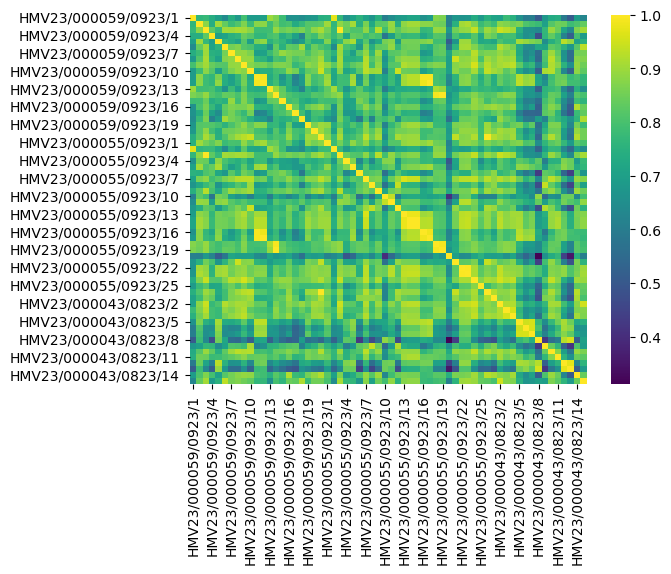

In [105]:
# Heatmap of cosine similarity matrix for description
sns.heatmap(cosine_sim_description_df, cmap='viridis')
plt.show()

In [106]:
cosine_sim_description_df.to_csv('./similarityMatrixFiles/cos_sim_description.csv', index=True)

### Similarity Matrix for "Corrective Measure"

In [107]:
isp_vec = pd.DataFrame(np.array(df_isp_irc['corrective_action_embedding']).reshape(-1, df_isp_irc.shape[0]), columns=df_isp_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
isq_vec = pd.DataFrame(np.array(df_isq_irc['corrective_action_embedding']).reshape(-1, df_isq_irc.shape[0]), columns=df_isq_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
iux_vec = pd.DataFrame(np.array(df_iux_irc['corrective_action_embedding']).reshape(-1, df_iux_irc.shape[0]), columns=df_iux_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)

In [108]:
df_correction = pd.concat([isp_vec, isq_vec, iux_vec], axis=1)
df_correction

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
0,-0.788351,-0.818996,-0.630261,-0.727544,-0.717193,-0.496929,-0.808907,-0.512398,-0.723586,-0.46956,...,-0.504287,-0.571588,-0.647734,-0.410593,-0.679378,-0.887238,-0.707964,-0.643426,-0.679615,-0.530129
1,-0.484558,-0.536668,-0.567799,-0.586891,-0.617948,-0.531382,-0.560408,-0.481845,-0.527002,-0.577328,...,-0.806563,-0.798257,-0.579416,-0.569525,-0.430323,0.045907,-0.818367,-0.657298,-0.67521,-0.429291
2,0.053019,0.209987,0.334021,0.393437,0.643868,0.176591,0.204325,0.142865,0.255765,0.19757,...,0.898194,0.53625,0.210073,0.21446,0.300454,-0.071734,0.455576,0.343302,0.502974,0.068359
3,0.286135,0.475425,0.639083,0.385343,0.576545,0.507846,0.621222,0.548663,0.550013,0.42403,...,0.319111,0.212804,0.416104,0.526436,0.593985,0.329493,0.319828,0.363152,0.227212,0.555915
4,0.869403,1.173708,1.037856,0.981595,1.455833,0.78165,1.245592,0.945396,1.054821,0.800498,...,0.891448,0.968591,0.790636,0.782686,1.061776,-0.06446,1.074961,1.218442,0.865548,0.834961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,-0.197221,-0.129722,0.027491,0.23597,0.268289,-0.008688,-0.090512,0.132056,0.052635,0.026296,...,0.550541,0.302011,-0.076053,0.062023,0.128548,-0.370823,0.343414,0.110377,0.426963,-0.215036
92,0.695078,0.662038,0.549248,0.765284,0.022875,0.738144,0.291611,0.673858,0.560503,0.769905,...,0.480322,0.55852,0.843266,0.735802,0.530089,1.729075,0.55466,0.553487,0.696028,0.710886
93,0.243106,0.220029,0.164436,-0.048681,0.058354,0.252979,0.155041,0.202399,0.106107,0.192751,...,-0.008902,0.018914,0.171998,0.203173,0.197783,0.316275,0.060786,0.160082,-0.017196,0.21677
94,0.139806,-0.105967,-0.21675,-0.084573,-0.396006,-0.106495,-0.236569,-0.195299,-0.279886,-0.208051,...,-0.274424,-0.142775,-0.070044,-0.109119,-0.338151,0.273594,-0.13219,-0.19546,-0.158799,-0.153335


In [109]:
cos_sim_correction_mat = cosine_similarity(df_correction.T)
cosine_sim_correction_df = pd.DataFrame(cos_sim_correction_mat, index=df_correction.columns, columns=df_correction.columns)

In [110]:
cosine_sim_correction_df.to_csv('./similarityMatrixFiles/cos_sim_correction.csv', index=True)

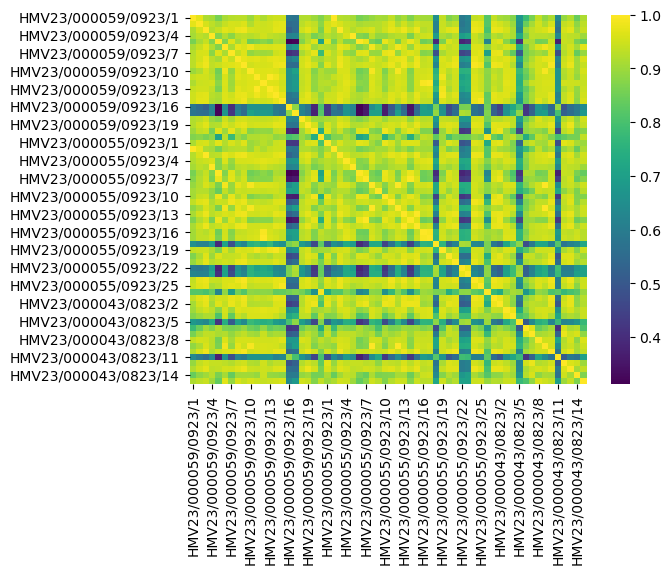

In [111]:
# Heatmap of cosine similarity matrix for description
sns.heatmap(cosine_sim_correction_df, cmap='viridis')
plt.show()

### Similarity Matrix for "Description + Corrective Measure"

In [112]:
isp_vec = pd.DataFrame(np.array(df_isp_irc['description_correction_embedding']).reshape(-1, df_isp_irc.shape[0]), columns=df_isp_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
isq_vec = pd.DataFrame(np.array(df_isq_irc['description_correction_embedding']).reshape(-1, df_isq_irc.shape[0]), columns=df_isq_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)
iux_vec = pd.DataFrame(np.array(df_iux_irc['description_correction_embedding']).reshape(-1, df_iux_irc.shape[0]), columns=df_iux_irc['Log Item #'].tolist()).apply(lambda col: col.explode()).reset_index(drop=True)

In [113]:
df_desc_correction = pd.concat([isp_vec, isq_vec, iux_vec], axis=1)
df_desc_correction

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
0,-0.713789,-0.780711,-0.615419,-0.603613,-0.647318,-0.52071,-0.744721,-0.435015,-0.698631,-0.435264,...,-0.418666,-0.412803,-0.704442,-0.409873,-0.591126,-0.498638,-0.555908,-0.554938,-0.613789,-0.500549
1,-0.319262,-0.45288,-0.41884,-0.499884,-0.551189,-0.477768,-0.513817,-0.416334,-0.503269,-0.547996,...,-0.817925,-0.77514,-0.647116,-0.495139,-0.412298,-0.168815,-0.747437,-0.676472,-0.634277,-0.368914
2,0.07785,0.183043,0.18454,0.327409,0.592923,0.058333,0.159985,-0.023087,0.208309,0.045369,...,0.769589,0.513394,0.229867,0.031064,0.220489,-0.065371,0.50278,0.439477,0.380264,-0.090585
3,0.130941,0.432427,0.569074,0.44293,0.43027,0.500974,0.575999,0.477546,0.475121,0.415431,...,0.300456,0.203997,0.371975,0.443331,0.543668,0.353886,0.267545,0.354498,0.243168,0.545417
4,0.648897,0.997607,0.871439,0.889599,1.15528,0.681657,1.058557,0.74537,0.895056,0.623878,...,0.787684,0.770469,0.885928,0.60377,0.942563,0.076634,0.98681,1.141203,0.7106,0.626602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,-0.141895,-0.100157,-0.078664,0.296721,0.276959,-0.097333,-0.111899,0.059816,0.06464,-0.030784,...,0.572441,0.385247,0.043273,0.113352,0.099598,-0.094911,0.303605,0.223337,0.297655,-0.367131
92,0.882572,0.788844,0.761253,0.928192,0.254169,0.834337,0.419876,0.916248,0.672749,1.034118,...,0.698676,0.822439,0.665824,0.926676,0.719978,1.369942,0.645836,0.573794,0.867134,0.890731
93,0.177602,0.212255,0.224877,-0.075813,0.082606,0.310665,0.183449,0.225913,0.118386,0.207212,...,-0.037548,0.025043,0.165743,0.22397,0.18024,0.341858,0.072512,0.114377,-0.001792,0.307982
94,0.287388,-0.133318,-0.082639,0.024693,-0.317825,-0.022807,-0.156958,-0.10118,-0.227553,-0.098295,...,-0.197629,-0.219478,-0.056765,-0.101772,-0.235517,-0.007036,-0.146327,-0.223821,-0.172539,-0.058037


In [114]:
cos_sim_desc_correction_mat = cosine_similarity(df_desc_correction.T)
cosine_sim_desc_correction_df = pd.DataFrame(cos_sim_desc_correction_mat, index=df_desc_correction.columns, columns=df_desc_correction.columns)

In [115]:
cosine_sim_desc_correction_df.to_csv('./similarityMatrixFiles/cos_sim_desc_correction.csv', index=True)

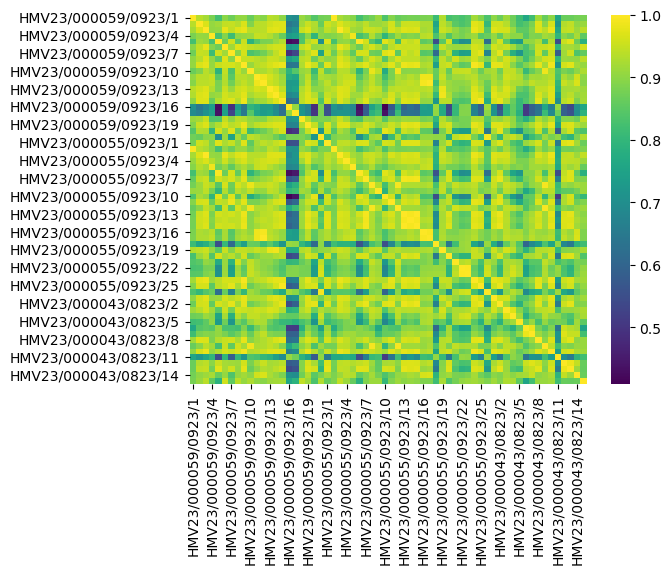

In [116]:
# Heatmap of cosine similarity matrix for description
sns.heatmap(cosine_sim_desc_correction_df, cmap='viridis')
plt.show()

## TF-IDF Vectorizer

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

def main(corpus: list, preserve_symbols=['-', '/']) -> list:
    # Preprocess text for the entire corpus
    preprocessed_corpus = [preprocess_text(text, preserve_symbols) for text in corpus]
    
    # TF-IDF Vectorization
    vectorizer = TfidfVectorizer()
    embeddings = vectorizer.fit_transform(preprocessed_corpus)

    # Convert the sparse matrix to dense array
    dense_embeddings = embeddings.toarray()

    return dense_embeddings

### Description

In [118]:
df_final_description = pd.concat([
    df_isp_irc[['Log Item #', 'Description']],
    df_isq_irc[['Log Item #', 'Description']],
    df_iux_irc[['Log Item #', 'Description']]], axis=0).copy()

In [119]:
# df_final_description['description_embeddings'] = df_final_description['Description'].apply(lambda x: main(x, preserve_symbols=['-', '/']))
desc_tf_idf_vec = main(df_final_description['Description'].tolist(), preserve_symbols=['-', '/'])

In [120]:
description_embeddings = pd.DataFrame(desc_tf_idf_vec, index=df_final_description['Log Item #'].tolist())
description_embeddings = description_embeddings.T

In [121]:
cos_sim_desc_mat = cosine_similarity(description_embeddings.T)
cosine_sim_desc_df = pd.DataFrame(cos_sim_desc_mat, 
                                  index=description_embeddings.columns, 
                                  columns=description_embeddings.columns)

In [122]:
cosine_sim_desc_df.to_csv('./tfIdfSImMat/cos_sim_desc.csv', index=True)

### Correction

In [123]:
df_final_correction = pd.concat([
    df_isp_irc[['Log Item #', 'Corrective Action']],
    df_isq_irc[['Log Item #', 'Corrective Action']],
    df_iux_irc[['Log Item #', 'Corrective Action']]], axis=0).copy()

In [124]:
correction_tf_idf_vec = main(df_final_correction['Corrective Action'].tolist(), preserve_symbols=['-', '/'])

In [125]:
correction_embeddings = pd.DataFrame(correction_tf_idf_vec, index=df_final_correction['Log Item #'].tolist())
correction_embeddings = correction_embeddings.T

In [126]:
cos_sim_correction_mat = cosine_similarity(correction_embeddings.T)
cosine_sim_correction_df = pd.DataFrame(cos_sim_correction_mat, 
                                  index=correction_embeddings.columns, 
                                  columns=correction_embeddings.columns)

In [127]:
cosine_sim_correction_df.to_csv('./tfIdfSImMat/cos_sim_correction.csv', index=True)

### Desc + Correction

In [128]:
df_final_correction_desc = pd.concat([
    df_isp_irc[['Log Item #', 'description_correction']],
    df_isq_irc[['Log Item #', 'description_correction']],
    df_iux_irc[['Log Item #', 'description_correction']]], axis=0).copy()

In [129]:
desc_correction_tf_idf_vec = main(df_final_correction_desc['description_correction'].tolist(), preserve_symbols=['-', '/'])

In [130]:
desc_correction_embeddings = pd.DataFrame(desc_correction_tf_idf_vec, index=df_final_correction_desc['Log Item #'].tolist())
desc_correction_embeddings = desc_correction_embeddings.T

In [131]:
cos_sim_desc_correction_mat = cosine_similarity(desc_correction_embeddings.T)
cosine_sim_desc_correction_df = pd.DataFrame(cos_sim_desc_correction_mat, 
                                  index=desc_correction_embeddings.columns, 
                                  columns=desc_correction_embeddings.columns)

In [132]:
cosine_sim_desc_correction_df.to_csv('./tfIdfSImMat/cos_sim_desc_correction.csv', index=True)

## TF-IDF Similarity Matrix
### Description

In [6]:
df_des = pd.read_csv('tfIdfSImMat/cos_sim_desc.csv', index_col=0)

In [7]:
df_des.head()

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
HMV23/000059/0923/1,1.000000,0.000000,0.024944,0.000000,0.282676,0.101375,0.104017,0.000000,0.000000,0.000000,...,0.084119,0.063953,0.086438,0.110879,0.054092,0.079042,0.218537,0.032230,0.000000,0.02008
HMV23/000059/0923/2,0.000000,1.000000,0.015473,0.059426,0.014314,0.014527,0.014905,0.071989,0.062229,0.026849,...,0.033324,0.000000,0.000000,0.000000,0.000000,0.000000,0.028063,0.064360,0.011289,0.00000
HMV23/000059/0923/3,0.024944,0.015473,1.000000,0.042926,0.017349,0.014350,0.014724,0.044658,0.045311,0.026522,...,0.023070,0.006073,0.015804,0.014613,0.007022,0.018224,0.022052,0.201921,0.004060,0.00000
HMV23/000059/0923/4,0.000000,0.059426,0.042926,1.000000,0.008141,0.051963,0.053317,0.040940,0.035389,0.058065,...,0.018951,0.000000,0.000000,0.000000,0.000000,0.000000,0.015959,0.036601,0.006420,0.00000
HMV23/000059/0923/5,0.282676,0.014314,0.017349,0.008141,1.000000,0.044174,0.045325,0.023950,0.014631,0.000000,...,0.136772,0.118571,0.134033,0.137425,0.128435,0.085891,0.359598,0.035837,0.000000,0.00875


In [8]:
upper_triangular_values = get_upper_triangular_values(df_des.values)

In [9]:
upper_triangular_values = np.array(upper_triangular_values)

In [10]:
np.median(upper_triangular_values), np.mean(upper_triangular_values), np.std(upper_triangular_values)

(0.0309310964375919, 0.06058150226062013, 0.1082722615637064)

In [11]:
import seaborn as sns

<Axes: ylabel='Density'>

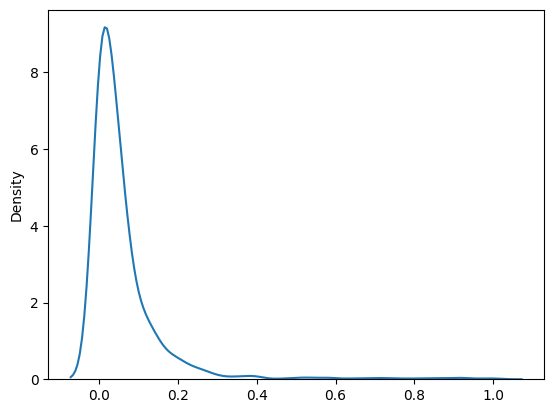

In [12]:
sns.kdeplot(upper_triangular_values)

In [13]:
for i in np.arange(90, 100, 1): 
    print(i, np.percentile(upper_triangular_values, i))

90 0.1412664595450247
91 0.14994590433840074
92 0.16179353040909214
93 0.17621307898662392
94 0.19515290799092866
95 0.2080677762595622
96 0.2348332822514768
97 0.26945664146694587
98 0.3842046594129484
99 0.638969685537649


In [14]:
df_des= threshold_transform(df_des, threshold=0.5)
df_des

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
HMV23/000059/0923/1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HMV23/000059/0923/2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HMV23/000059/0923/3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HMV23/000059/0923/4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HMV23/000059/0923/5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HMV23/000043/0823/11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HMV23/000043/0823/12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
HMV23/000043/0823/13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HMV23/000043/0823/14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [15]:
task = pd.concat([
    df_isp_irc[['Log Item #', 'Source Task/Discrep. #', 'Description']],
    df_isq_irc[['Log Item #', 'Source Task/Discrep. #', 'Description']],
    df_iux_irc[['Log Item #', 'Source Task/Discrep. #', 'Description']]], axis=0).copy()

In [16]:
task

,Log Item #,Source Task/Discrep. #,Description
0,HMV23/000059/0923/1,AIRCRAFT ARRIVAL INSPECTION,1. DURING INSPECTION OBERVED LH WING SLATE #01...
1,HMV23/000059/0923/2,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION CHECK FOUND FAILURE ...
2,HMV23/000059/0923/3,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND STATIC DISCHAR...
3,HMV23/000059/0923/4,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP ...
4,HMV23/000059/0923/5,AIRCRAFT ARRIVAL INSPECTION,"DURING ARRIVAL INSPECTION , OBSERVED FOLLOWINS..."
...,...,...,...
10,HMV23/000043/0823/11,AIRCRAFT ARRIVAL INSPECTION,OPERATIONAL TEST OF SLAT#2 (LH & RH) WING TO B...
11,HMV23/000043/0823/12,AIRCRAFT ARRIVAL INSPECTION,WHILE ARRIVAL INSPECTION OBSERVED RH WING SLAT...
12,HMV23/000043/0823/13,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL CHECK OBSERVED ON VERTICAL STAB...
13,HMV23/000043/0823/14,353000-07-1,DURING DETAILED INSPECTION OF PORTABLE OXYGEN ...


In [17]:
df_des.to_csv('Desc_ones_zeros.csv', index=True)

In [18]:
obsv_cluster = dict()

for i in range(df_des.shape[0]):
    for j in range(i+1, df_des.shape[1]):
        if df_des.iloc[i, j] == 1:
            if df_des.columns[i] != df_des.columns[j]:
                if df_des.columns[i] in obsv_cluster:
                    obsv_cluster[df_des.columns[i]].append(df_des.columns[j])
                else:
                    obsv_cluster[df_des.columns[i]] = [df_des.columns[j]]

In [19]:
obsv_cluster

{'HMV23/000059/0923/3': ['HMV23/000055/0923/17'],
 'HMV23/000059/0923/4': ['HMV23/000055/0923/21'],
 'HMV23/000059/0923/5': ['HMV23/000055/0923/6'],
 'HMV23/000059/0923/6': ['HMV23/000055/0923/11'],
 'HMV23/000059/0923/7': ['HMV23/000055/0923/12'],
 'HMV23/000059/0923/8': ['HMV23/000059/0923/9',
  'HMV23/000055/0923/13',
  'HMV23/000055/0923/14'],
 'HMV23/000059/0923/9': ['HMV23/000055/0923/13', 'HMV23/000055/0923/14'],
 'HMV23/000059/0923/10': ['HMV23/000055/0923/22'],
 'HMV23/000059/0923/11': ['HMV23/000055/0923/15'],
 'HMV23/000059/0923/12': ['HMV23/000055/0923/24'],
 'HMV23/000059/0923/15': ['HMV23/000055/0923/10'],
 'HMV23/000059/0923/16': ['HMV23/000055/0923/23'],
 'HMV23/000059/0923/17': ['HMV23/000055/0923/25'],
 'HMV23/000055/0923/1': ['HMV23/000055/0923/7'],
 'HMV23/000055/0923/2': ['HMV23/000055/0923/6', 'HMV23/000043/0823/12'],
 'HMV23/000055/0923/3': ['HMV23/000055/0923/4'],
 'HMV23/000055/0923/4': ['HMV23/000055/0923/5'],
 'HMV23/000055/0923/6': ['HMV23/000043/0823/12'],


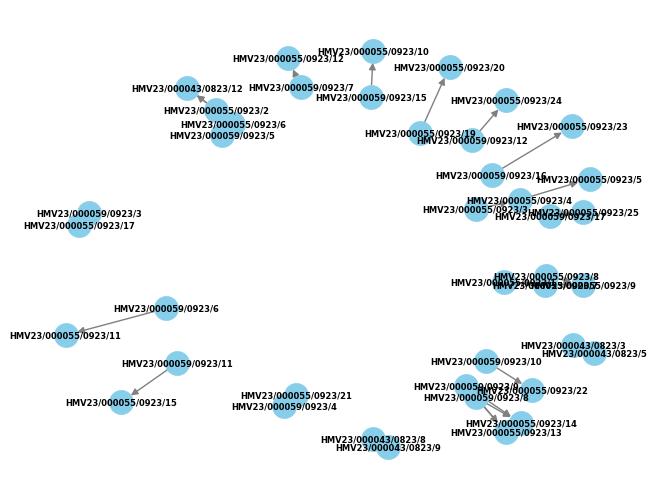

In [20]:
import networkx as nx
import matplotlib.pyplot as plt


# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges based on your data
for key, values in obsv_cluster.items():
    G.add_node(key)
    for value in values:
        G.add_edge(key, value)

# Draw the graph
pos = nx.spring_layout(G)  # You can try different layouts based on your preference
nx.draw(G, pos, with_labels=True, font_size=6, node_size=300, node_color="skyblue", font_color="black", font_weight="bold", edge_color="gray", linewidths=0.5)

# Show the plot
plt.show()


In [21]:
from pyvis.network import Network

# Create a pyvis network instance
net = Network(height="800px", width="100%", notebook=True)

# Add nodes to the network
for key, values in obsv_cluster.items():
    net.add_node(key)
    for value in values:
        net.add_node(value)  
        net.add_edge(key, value)

# Save the interactive graph to an HTML file
net.show("graph_visualization.html")


graph_visualization.html


In [22]:
task_obsv_cluster = dict()
for i in list(obsv_cluster.items()):
    if str(task[task['Log Item #'] == i[0]]['Source Task/Discrep. #'].values.tolist()[0]) in task_obsv_cluster:
        task_obsv_cluster[str(task[task['Log Item #'] == i[0]]['Source Task/Discrep. #'].values.tolist()[0])].append({i[0]:i[1]})
    else:
        task_obsv_cluster[str(task[task['Log Item #'] == i[0]]['Source Task/Discrep. #'].values.tolist()[0])] = [{i[0]:i[1]}]   

In [23]:
task_obsv_cluster

{'AIRCRAFT ARRIVAL INSPECTION': [{'HMV23/000059/0923/3': ['HMV23/000055/0923/17']},
  {'HMV23/000059/0923/4': ['HMV23/000055/0923/21']},
  {'HMV23/000059/0923/5': ['HMV23/000055/0923/6']},
  {'HMV23/000059/0923/6': ['HMV23/000055/0923/11']},
  {'HMV23/000059/0923/7': ['HMV23/000055/0923/12']},
  {'HMV23/000059/0923/8': ['HMV23/000059/0923/9',
    'HMV23/000055/0923/13',
    'HMV23/000055/0923/14']},
  {'HMV23/000059/0923/9': ['HMV23/000055/0923/13', 'HMV23/000055/0923/14']},
  {'HMV23/000059/0923/15': ['HMV23/000055/0923/10']},
  {'HMV23/000055/0923/1': ['HMV23/000055/0923/7']},
  {'HMV23/000055/0923/2': ['HMV23/000055/0923/6', 'HMV23/000043/0823/12']},
  {'HMV23/000055/0923/3': ['HMV23/000055/0923/4']},
  {'HMV23/000055/0923/4': ['HMV23/000055/0923/5']},
  {'HMV23/000055/0923/6': ['HMV23/000043/0823/12']},
  {'HMV23/000055/0923/7': ['HMV23/000055/0923/8', 'HMV23/000055/0923/9']},
  {'HMV23/000055/0923/8': ['HMV23/000055/0923/9']},
  {'HMV23/000055/0923/13': ['HMV23/000055/0923/14']},


In [24]:
# Adding a task manually
task_obsv_cluster['AWR23/003086/0923'] = [{'HMV23/000055/0923/10':'HMV23/000059/0923/15'}]
task_obsv_cluster['262300-02-1'] = [{'HMV23/000055/0923/26':''}]
task_obsv_cluster['AWR23/002577/0823'] = [{'HMV23/000043/0823/2': ''}]
task_obsv_cluster['262300-02-1'] = [{'HMV23/000043/0823/7':''}]
task_obsv_cluster['262300-02-1'] = [{'HMV23/000043/0823/10':''}]
task_obsv_cluster['353000-07-1'] = [{'HMV23/000043/0823/14':''}]
task_obsv_cluster['262300-02-1'] = [{'HMV23/000059/0923/21':''}]
task_obsv_cluster['AWR23/002877/0923'] = [{'HMV23/000059/0923/14':''}]
task_obsv_cluster['AWR23/002555/0823'] = [{'HMV23/000043/0823/7':''}]
task_obsv_cluster['AWR23/002577/0823'] = [{'HMV23/000043/0823/2':''}]

In [25]:
from pyvis.network import Network


# Create a pyvis network instance
net1 = Network(height="800px", width="100%", notebook=True)

# Add nodes and edges to the network
for key, values in task_obsv_cluster.items():
    net1.add_node(key, color="red")
    for edge_dict in values:
        for edge_key, edge_values in edge_dict.items():
            net1.add_node(edge_key)
            net1.add_edge(key, edge_key)
            for edge_value in edge_values:
                net1.add_node(edge_value)
                net1.add_edge(edge_key, edge_value)

# Add a heading to the HTML content
heading_html = "<h1>Task Clusters Graph Visualization</h1>"
net1.html = heading_html + net1.html

# Save the interactive graph to an HTML file
net1.show("task_graph_visualization.html")


task_graph_visualization.html


In [26]:
obsv_cluster

{'HMV23/000059/0923/3': ['HMV23/000055/0923/17'],
 'HMV23/000059/0923/4': ['HMV23/000055/0923/21'],
 'HMV23/000059/0923/5': ['HMV23/000055/0923/6'],
 'HMV23/000059/0923/6': ['HMV23/000055/0923/11'],
 'HMV23/000059/0923/7': ['HMV23/000055/0923/12'],
 'HMV23/000059/0923/8': ['HMV23/000059/0923/9',
  'HMV23/000055/0923/13',
  'HMV23/000055/0923/14'],
 'HMV23/000059/0923/9': ['HMV23/000055/0923/13', 'HMV23/000055/0923/14'],
 'HMV23/000059/0923/10': ['HMV23/000055/0923/22'],
 'HMV23/000059/0923/11': ['HMV23/000055/0923/15'],
 'HMV23/000059/0923/12': ['HMV23/000055/0923/24'],
 'HMV23/000059/0923/15': ['HMV23/000055/0923/10'],
 'HMV23/000059/0923/16': ['HMV23/000055/0923/23'],
 'HMV23/000059/0923/17': ['HMV23/000055/0923/25'],
 'HMV23/000055/0923/1': ['HMV23/000055/0923/7'],
 'HMV23/000055/0923/2': ['HMV23/000055/0923/6', 'HMV23/000043/0823/12'],
 'HMV23/000055/0923/3': ['HMV23/000055/0923/4'],
 'HMV23/000055/0923/4': ['HMV23/000055/0923/5'],
 'HMV23/000055/0923/6': ['HMV23/000043/0823/12'],


In [27]:
# obsv_cluster_groups = []
# for i in obsv_cluster.items():
#     temp = []
#     for j in i[1]:
#         temp.append(j)
#     obsv_cluster_groups.append(temp)

# obsv_cluster_groups

In [28]:
# Get clusters based on edge relationships
clusters = {}
for edge in net.edges:
    source = edge['from']
    target = edge['to']

    if source not in clusters:
        clusters[source] = set([source, target])
    else:
        clusters[source].add(target)

# Convert clusters to a dictionary where values are lists
clusters_list = {key: list(value) for key, value in clusters.items()}

# Print clusters as lists
cnt = 0
for key, value in clusters_list.items():
    cnt += 1
    print(f"Group : {value}")

print(f"Total groups : {cnt}")

Group : ['HMV23/000059/0923/3', 'HMV23/000055/0923/17']
Group : ['HMV23/000059/0923/4', 'HMV23/000055/0923/21']
Group : ['HMV23/000055/0923/6', 'HMV23/000059/0923/5']
Group : ['HMV23/000055/0923/11', 'HMV23/000059/0923/6']
Group : ['HMV23/000059/0923/7', 'HMV23/000055/0923/12']
Group : ['HMV23/000055/0923/13', 'HMV23/000059/0923/8', 'HMV23/000059/0923/9', 'HMV23/000055/0923/14']
Group : ['HMV23/000055/0923/14', 'HMV23/000059/0923/9', 'HMV23/000055/0923/13']
Group : ['HMV23/000055/0923/22', 'HMV23/000059/0923/10']
Group : ['HMV23/000055/0923/15', 'HMV23/000059/0923/11']
Group : ['HMV23/000055/0923/24', 'HMV23/000059/0923/12']
Group : ['HMV23/000055/0923/10', 'HMV23/000059/0923/15']
Group : ['HMV23/000055/0923/23', 'HMV23/000059/0923/16']
Group : ['HMV23/000059/0923/17', 'HMV23/000055/0923/25']
Group : ['HMV23/000055/0923/1', 'HMV23/000055/0923/7']
Group : ['HMV23/000055/0923/6', 'HMV23/000043/0823/12', 'HMV23/000055/0923/2']
Group : ['HMV23/000055/0923/4', 'HMV23/000055/0923/3']
Group :

In [29]:
list(clusters.values())

[{'HMV23/000055/0923/17', 'HMV23/000059/0923/3'},
 {'HMV23/000055/0923/21', 'HMV23/000059/0923/4'},
 {'HMV23/000055/0923/6', 'HMV23/000059/0923/5'},
 {'HMV23/000055/0923/11', 'HMV23/000059/0923/6'},
 {'HMV23/000055/0923/12', 'HMV23/000059/0923/7'},
 {'HMV23/000055/0923/13',
  'HMV23/000055/0923/14',
  'HMV23/000059/0923/8',
  'HMV23/000059/0923/9'},
 {'HMV23/000055/0923/13', 'HMV23/000055/0923/14', 'HMV23/000059/0923/9'},
 {'HMV23/000055/0923/22', 'HMV23/000059/0923/10'},
 {'HMV23/000055/0923/15', 'HMV23/000059/0923/11'},
 {'HMV23/000055/0923/24', 'HMV23/000059/0923/12'},
 {'HMV23/000055/0923/10', 'HMV23/000059/0923/15'},
 {'HMV23/000055/0923/23', 'HMV23/000059/0923/16'},
 {'HMV23/000055/0923/25', 'HMV23/000059/0923/17'},
 {'HMV23/000055/0923/1', 'HMV23/000055/0923/7'},
 {'HMV23/000043/0823/12', 'HMV23/000055/0923/2', 'HMV23/000055/0923/6'},
 {'HMV23/000055/0923/3', 'HMV23/000055/0923/4'},
 {'HMV23/000055/0923/4', 'HMV23/000055/0923/5'},
 {'HMV23/000043/0823/12', 'HMV23/000055/0923/6'}

In [30]:
def create_groups(edges):
    # Create an adjacency list from the edges
    adj_list = {}
    for edge in edges:
        for node in edge:
            adj_list.setdefault(node, set()).update(edge - {node})

    # Function to perform depth-first search (DFS)
    def dfs(node, visited, group):
        visited.add(node)
        group.add(node)
        for neighbor in adj_list.get(node, []):
            if neighbor not in visited:
                dfs(neighbor, visited, group)

    # Initialize variables
    visited = set()
    groups = []

    # Traverse the graph using DFS
    for node in adj_list.keys():
        if node not in visited:
            group = set()
            dfs(node, visited, group)
            groups.append(list(group))

    return groups


source_task_logitems = create_groups(list(clusters.values()))
print(source_task_logitems)


[['HMV23/000059/0923/3', 'HMV23/000055/0923/17'], ['HMV23/000059/0923/4', 'HMV23/000055/0923/21'], ['HMV23/000055/0923/2', 'HMV23/000055/0923/6', 'HMV23/000043/0823/12', 'HMV23/000059/0923/5'], ['HMV23/000059/0923/6', 'HMV23/000055/0923/11'], ['HMV23/000059/0923/7', 'HMV23/000055/0923/12'], ['HMV23/000055/0923/14', 'HMV23/000059/0923/8', 'HMV23/000059/0923/9', 'HMV23/000055/0923/13'], ['HMV23/000055/0923/22', 'HMV23/000059/0923/10'], ['HMV23/000055/0923/15', 'HMV23/000059/0923/11'], ['HMV23/000055/0923/24', 'HMV23/000059/0923/12'], ['HMV23/000055/0923/10', 'HMV23/000059/0923/15'], ['HMV23/000055/0923/23', 'HMV23/000059/0923/16'], ['HMV23/000059/0923/17', 'HMV23/000055/0923/25'], ['HMV23/000055/0923/1', 'HMV23/000055/0923/7', 'HMV23/000055/0923/8', 'HMV23/000055/0923/9'], ['HMV23/000055/0923/5', 'HMV23/000055/0923/4', 'HMV23/000055/0923/3'], ['HMV23/000055/0923/19', 'HMV23/000055/0923/20'], ['HMV23/000043/0823/5', 'HMV23/000043/0823/3'], ['HMV23/000043/0823/8', 'HMV23/000043/0823/9']]


In [31]:
source_task_logitems

[['HMV23/000059/0923/3', 'HMV23/000055/0923/17'],
 ['HMV23/000059/0923/4', 'HMV23/000055/0923/21'],
 ['HMV23/000055/0923/2',
  'HMV23/000055/0923/6',
  'HMV23/000043/0823/12',
  'HMV23/000059/0923/5'],
 ['HMV23/000059/0923/6', 'HMV23/000055/0923/11'],
 ['HMV23/000059/0923/7', 'HMV23/000055/0923/12'],
 ['HMV23/000055/0923/14',
  'HMV23/000059/0923/8',
  'HMV23/000059/0923/9',
  'HMV23/000055/0923/13'],
 ['HMV23/000055/0923/22', 'HMV23/000059/0923/10'],
 ['HMV23/000055/0923/15', 'HMV23/000059/0923/11'],
 ['HMV23/000055/0923/24', 'HMV23/000059/0923/12'],
 ['HMV23/000055/0923/10', 'HMV23/000059/0923/15'],
 ['HMV23/000055/0923/23', 'HMV23/000059/0923/16'],
 ['HMV23/000059/0923/17', 'HMV23/000055/0923/25'],
 ['HMV23/000055/0923/1',
  'HMV23/000055/0923/7',
  'HMV23/000055/0923/8',
  'HMV23/000055/0923/9'],
 ['HMV23/000055/0923/5', 'HMV23/000055/0923/4', 'HMV23/000055/0923/3'],
 ['HMV23/000055/0923/19', 'HMV23/000055/0923/20'],
 ['HMV23/000043/0823/5', 'HMV23/000043/0823/3'],
 ['HMV23/000043/

In [32]:
for i in source_task_logitems:
    print(len(i))

2
2
4
2
2
4
2
2
2
2
2
2
4
3
2
2
2


In [33]:
task

,Log Item #,Source Task/Discrep. #,Description
0,HMV23/000059/0923/1,AIRCRAFT ARRIVAL INSPECTION,1. DURING INSPECTION OBERVED LH WING SLATE #01...
1,HMV23/000059/0923/2,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION CHECK FOUND FAILURE ...
2,HMV23/000059/0923/3,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND STATIC DISCHAR...
3,HMV23/000059/0923/4,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP ...
4,HMV23/000059/0923/5,AIRCRAFT ARRIVAL INSPECTION,"DURING ARRIVAL INSPECTION , OBSERVED FOLLOWINS..."
...,...,...,...
10,HMV23/000043/0823/11,AIRCRAFT ARRIVAL INSPECTION,OPERATIONAL TEST OF SLAT#2 (LH & RH) WING TO B...
11,HMV23/000043/0823/12,AIRCRAFT ARRIVAL INSPECTION,WHILE ARRIVAL INSPECTION OBSERVED RH WING SLAT...
12,HMV23/000043/0823/13,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL CHECK OBSERVED ON VERTICAL STAB...
13,HMV23/000043/0823/14,353000-07-1,DURING DETAILED INSPECTION OF PORTABLE OXYGEN ...


In [34]:
source_task_logitems
# type(source_task_logitems)

[['HMV23/000059/0923/3', 'HMV23/000055/0923/17'],
 ['HMV23/000059/0923/4', 'HMV23/000055/0923/21'],
 ['HMV23/000055/0923/2',
  'HMV23/000055/0923/6',
  'HMV23/000043/0823/12',
  'HMV23/000059/0923/5'],
 ['HMV23/000059/0923/6', 'HMV23/000055/0923/11'],
 ['HMV23/000059/0923/7', 'HMV23/000055/0923/12'],
 ['HMV23/000055/0923/14',
  'HMV23/000059/0923/8',
  'HMV23/000059/0923/9',
  'HMV23/000055/0923/13'],
 ['HMV23/000055/0923/22', 'HMV23/000059/0923/10'],
 ['HMV23/000055/0923/15', 'HMV23/000059/0923/11'],
 ['HMV23/000055/0923/24', 'HMV23/000059/0923/12'],
 ['HMV23/000055/0923/10', 'HMV23/000059/0923/15'],
 ['HMV23/000055/0923/23', 'HMV23/000059/0923/16'],
 ['HMV23/000059/0923/17', 'HMV23/000055/0923/25'],
 ['HMV23/000055/0923/1',
  'HMV23/000055/0923/7',
  'HMV23/000055/0923/8',
  'HMV23/000055/0923/9'],
 ['HMV23/000055/0923/5', 'HMV23/000055/0923/4', 'HMV23/000055/0923/3'],
 ['HMV23/000055/0923/19', 'HMV23/000055/0923/20'],
 ['HMV23/000043/0823/5', 'HMV23/000043/0823/3'],
 ['HMV23/000043/

In [35]:
src_task_groups = []
for i in source_task_logitems:
    temp = []
    for j in i:
        temp.append(task[task['Log Item #'] == j]['Source Task/Discrep. #'].values[0])
    src_task_groups.append(list(set(temp)))  # remove duplicates in temp)
src_task_groups

[['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['215222-01-1 (LH)'],
 ['531900-03-1'],
 ['384241-01-1'],
 ['AWR23/003086/0923', 'AIRCRAFT ARRIVAL INSPECTION'],
 ['WEAR LIMITS- BONDING LEADS'],
 ['252100-01-1'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION']]

In [36]:
task['Source Task/Discrep. #'].value_counts()

Source Task/Discrep. #
AIRCRAFT ARRIVAL INSPECTION    41
215222-01-1 (LH)                4
WEAR LIMITS- BONDING LEADS      3
531900-03-1                     2
384241-01-1                     2
252100-01-1                     2
AWR23/002555/0823               2
AWR23/002877/0923               1
AWR23/003125/0923               1
AWR23/003086/0923               1
262300-02-1                     1
AWR23/002577/0823               1
353000-07-1                     1
Name: count, dtype: int64

In [37]:
src_task_description = []
for i in source_task_logitems:
    temp = []
    for j in i:
        temp.append(task[task['Log Item #'] == j]['Description'].values[0])
    src_task_description.append(temp)
src_task_description

[['DURING ARRIVAL INSPECTION FOUND STATIC DISCHARGERS DAMAGED AT LOCATION : \n1) LH HORZ STAB TYPE A DISCHARGER QTY# 2 & TYPE B DISCHARGER QTY#3 \n2) RH HORZ STAB TYPE A DISCHARGER QTY#1 \n3)VERTICAL STABILISER TYPE A DISCHARGER QTY 01 & TYPE B DISCHARGER QTY 02.',
  'DURING ARRIVAL INSPECTION FOUND STATIC DISCHARGERS DAMAGED AT LOCATION LH WING TIP TRAILING EDGE TYPE B DISCHARGER QTY#1, RH HORZ STAB TYPE A DISCHARGER QTY#1 TYPE B DISCHARGER QTY#1, LH HORZ STAB TYPE A DISCHARGER QTY#1 TYPE B DISCHARGER QTY#3, VERT STAB TYPE A DISCHARGER QTY#1, RUDDER TYPE B DISCHARGER QTY#1.'],
 ['DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP INOP AT FOLLOWING LOCATION \n1.103VU BATTERY COMPARMENT LAMP FIN: 8LS QTY#1,.\n2. REFUEL/DEFUEL CONTROL PANEL FLOODLIGHT LAMP FIN: 32QU.',
  'DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP INOP AT FOLLOWING LOCATION\n1. 80VU RH AVIONICS COMPARTMENT FIN: 9LS QTY#1, 90VU FWD AVIONICS COMPARMENT FIN: 6LS QTY#1.\n2. THS COMPARMENT FIN: 5LJ QTY#1.'],
 ['DURING INSPECTIO

In [38]:
result_dict = {}

# Zip the corresponding elements from three lists
zipped_elements = zip(source_task_logitems, src_task_groups, src_task_description)

# Iterate over the zipped elements to create the result dictionary
for i, elements in enumerate(zipped_elements, start=1):
    group_key = f'group_{i}'
    result_dict[group_key] = {
        'logItem': elements[0],
        'sourceTask': elements[1],
        'description': elements[2],
        'frequency': len(elements[0]),
    }

# Print the resulting dictionary
print(result_dict)

{'group_1': {'logItem': ['HMV23/000059/0923/3', 'HMV23/000055/0923/17'], 'sourceTask': ['AIRCRAFT ARRIVAL INSPECTION'], 'description': ['DURING ARRIVAL INSPECTION FOUND STATIC DISCHARGERS DAMAGED AT LOCATION : \n1) LH HORZ STAB TYPE A DISCHARGER QTY# 2 & TYPE B DISCHARGER QTY#3 \n2) RH HORZ STAB TYPE A DISCHARGER QTY#1 \n3)VERTICAL STABILISER TYPE A DISCHARGER QTY 01 & TYPE B DISCHARGER QTY 02.', 'DURING ARRIVAL INSPECTION FOUND STATIC DISCHARGERS DAMAGED AT LOCATION LH WING TIP TRAILING EDGE TYPE B DISCHARGER QTY#1, RH HORZ STAB TYPE A DISCHARGER QTY#1 TYPE B DISCHARGER QTY#1, LH HORZ STAB TYPE A DISCHARGER QTY#1 TYPE B DISCHARGER QTY#3, VERT STAB TYPE A DISCHARGER QTY#1, RUDDER TYPE B DISCHARGER QTY#1.'], 'frequency': 2}, 'group_2': {'logItem': ['HMV23/000059/0923/4', 'HMV23/000055/0923/21'], 'sourceTask': ['AIRCRAFT ARRIVAL INSPECTION'], 'description': ['DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP INOP AT FOLLOWING LOCATION \n1.103VU BATTERY COMPARMENT LAMP FIN: 8LS QTY#1,.\n2. RE

In [39]:
result_dict.keys()

dict_keys(['group_1', 'group_2', 'group_3', 'group_4', 'group_5', 'group_6', 'group_7', 'group_8', 'group_9', 'group_10', 'group_11', 'group_12', 'group_13', 'group_14', 'group_15', 'group_16', 'group_17'])

In [40]:
result_dict['group_1']

{'logItem': ['HMV23/000059/0923/3', 'HMV23/000055/0923/17'],
 'sourceTask': ['AIRCRAFT ARRIVAL INSPECTION'],
 'description': ['DURING ARRIVAL INSPECTION FOUND STATIC DISCHARGERS DAMAGED AT LOCATION : \n1) LH HORZ STAB TYPE A DISCHARGER QTY# 2 & TYPE B DISCHARGER QTY#3 \n2) RH HORZ STAB TYPE A DISCHARGER QTY#1 \n3)VERTICAL STABILISER TYPE A DISCHARGER QTY 01 & TYPE B DISCHARGER QTY 02.',
  'DURING ARRIVAL INSPECTION FOUND STATIC DISCHARGERS DAMAGED AT LOCATION LH WING TIP TRAILING EDGE TYPE B DISCHARGER QTY#1, RH HORZ STAB TYPE A DISCHARGER QTY#1 TYPE B DISCHARGER QTY#1, LH HORZ STAB TYPE A DISCHARGER QTY#1 TYPE B DISCHARGER QTY#3, VERT STAB TYPE A DISCHARGER QTY#1, RUDDER TYPE B DISCHARGER QTY#1.'],
 'frequency': 2}

In [41]:
from prettytable import PrettyTable

# Create a pretty table
table = PrettyTable()
table.field_names = ["Group", "Log Item", "Source Task", "Description", "Frequency"]

# Populate the table with data
for group, data in result_dict.items():
    table.add_row([group, data['logItem'], data['sourceTask'], data['description'], data['frequency']])

# Print the pretty table
print(table)

+----------+------------------------------------------------------------------------------------------------+------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [42]:
from prettytable import PrettyTable

# Create a pretty table
table = PrettyTable()
table.field_names = ["Group", "Log Item", "Source Task", "Frequency"]

# Populate the table with data
for group, data in result_dict.items():
    table.add_row([group, data['logItem'], data['sourceTask'], data['frequency']])

# Print the pretty table
print(table)

+----------+------------------------------------------------------------------------------------------------+------------------------------------------------------+-----------+
|  Group   |                                            Log Item                                            |                     Source Task                      | Frequency |
+----------+------------------------------------------------------------------------------------------------+------------------------------------------------------+-----------+
| group_1  |                        ['HMV23/000059/0923/3', 'HMV23/000055/0923/17']                         |           ['AIRCRAFT ARRIVAL INSPECTION']            |     2     |
| group_2  |                        ['HMV23/000059/0923/4', 'HMV23/000055/0923/21']                         |           ['AIRCRAFT ARRIVAL INSPECTION']            |     2     |
| group_3  | ['HMV23/000055/0923/2', 'HMV23/000055/0923/6', 'HMV23/000043/0823/12', 'HMV23/000059/0923/5']  |      

In [43]:
final_result = pd.DataFrame(result_dict.values())
final_result.head()

,logItem,sourceTask,description,frequency
0,"[HMV23/000059/0923/3, HMV23/000055/0923/17]",[AIRCRAFT ARRIVAL INSPECTION],[DURING ARRIVAL INSPECTION FOUND STATIC DISCHA...,2
1,"[HMV23/000059/0923/4, HMV23/000055/0923/21]",[AIRCRAFT ARRIVAL INSPECTION],[DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP...,2
2,"[HMV23/000055/0923/2, HMV23/000055/0923/6, HMV...",[AIRCRAFT ARRIVAL INSPECTION],[DURING INSPECTION OBSERVED LH WING SLAT#5 WEA...,4
3,"[HMV23/000059/0923/6, HMV23/000055/0923/11]",[AIRCRAFT ARRIVAL INSPECTION],[DURING INSPECTION FOUND FOLLOWING FORWARD CAR...,2
4,"[HMV23/000059/0923/7, HMV23/000055/0923/12]",[AIRCRAFT ARRIVAL INSPECTION],[DURING INSPECTION FOUND FOLLOWING AFT CARGO F...,2


In [44]:
final_result.shape

(17, 4)

In [45]:
type(final_result)

pandas.core.frame.DataFrame

In [46]:
final_result = final_result[['sourceTask', 'logItem', 'description', 'frequency']]
final_result.head()

,sourceTask,logItem,description,frequency
0,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/3, HMV23/000055/0923/17]",[DURING ARRIVAL INSPECTION FOUND STATIC DISCHA...,2
1,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/4, HMV23/000055/0923/21]",[DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP...,2
2,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000055/0923/2, HMV23/000055/0923/6, HMV...",[DURING INSPECTION OBSERVED LH WING SLAT#5 WEA...,4
3,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/6, HMV23/000055/0923/11]",[DURING INSPECTION FOUND FOLLOWING FORWARD CAR...,2
4,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/7, HMV23/000055/0923/12]",[DURING INSPECTION FOUND FOLLOWING AFT CARGO F...,2


In [47]:
final_result.to_excel('flight_maintenance_description_result.xlsx', index=False)

In [48]:
pd.read_excel('Data/vt_isp_material_consumption_pricing.xlsx')

,Sl.No,Regn#,Package #,Task #,Task Description,Issued Part #,Part Description,Issued UOM,Stock Status,Used Qty,Base Currency,Base Price (USD),Freight,Admin Charges,Total Billable Price,Billable Value (USD),SOI_TRAN #
0,1,VT-ISP,HMV23/000059/0923,ISSUE OF COMMERCIAL ITEMS,ISSUE OF COMMERCIAL ITEMS FOR AIRCRAFT MAINTEN...,3246,COTTON RAGS(KGS)-White,KG,Owned,50.0,INR,1.30,0.16,0.06,1.52,75.92,SOI23/000152/0423
1,2,VT-ISP,HMV23/000059/0923,AWR23/003127/0923,CARRY OUT PAINT TOUCH UP,3246,COTTON RAGS(KGS)-White,KG,Owned,5.0,INR,1.30,0.16,0.06,1.52,7.59,SOI23/000152/0423
2,3,VT-ISP,HMV23/000059/0923,282400-01-1 (LH),ENGINE LOW PRESSURE SHUT OFFOPERATIONAL CHECK ...,1355-606,PACKING,EA,Owned,1.0,INR,20.93,2.51,1.05,24.49,24.49,4P0037700823
3,4,VT-ISP,HMV23/000059/0923,282400-01-1 (RH),ENGINE LOW PRESSURE SHUT OFFOPERATIONAL CHECK ...,1355-606,PACKING,EA,Owned,1.0,INR,20.93,2.51,1.05,24.49,24.49,4P0037700823
4,5,VT-ISP,HMV23/000059/0923,HMV23/000059/0923/3,DURING ARRIVAL INSPECTION FOUND STATIC DISCHAR...,2-14SC1,DISCHRGR,EA,Owned,4.0,INR,62.50,7.50,3.13,73.13,292.50,4P0037010823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,140,VT-ISP,HMV23/000059/0923,HMV23/000059/0923/7,DURING INSPECTION FOUND FOLLOWING AFT CARGO FL...,TF20,INSERT ASSY SLEEVE AND PLUG,EA,Owned,10.0,INR,2.20,0.26,0.11,2.57,25.74,SOI23/002618/0923
140,141,VT-ISP,HMV23/000059/0923,HMV23/000059/0923/7,DURING INSPECTION FOUND FOLLOWING AFT CARGO FL...,TF20,INSERT ASSY SLEEVE AND PLUG,EA,Owned,250.0,INR,2.20,0.26,0.11,2.57,643.50,SOI23/002618/0923
141,142,VT-ISP,HMV23/000059/0923,AWR23/003108/0923,AS PER CUSTOMER REQUEST CARRY OUT CABIN REFURN...,X-200,Gum and Adhesive Remover,LTR,Owned,3.0,INR,56.51,6.78,2.83,66.12,198.35,SOI23/001842/0723
142,143,VT-ISP,HMV23/000059/0923,ISSUE OF COMMERCIAL ITEMS,ISSUE OF COMMERCIAL ITEMS FOR AIRCRAFT MAINTEN...,X-410Q,General Purpose Cleaner,LTR,Owned,1.0,INR,16.02,1.92,0.80,18.74,18.74,4P0029550423


In [49]:
print(df_isp_irc.columns)
# print(df_isq_irc.columns)
# print(df_iux_irc.columns)

Index(['DeleteFlag', 'Type', 'Log Item #', 'ATA #', 'Description',
       'Corrective Action', 'Discrepancy #', 'Action', 'Status',
       'Source Task/Discrep. #', 'Source Tracking #', 'Work Center #',
       'Sign Off Status', 'Contract Classification', 'Category', 'Exe. Phase',
       'Exec. Category', 'Part Required?', 'Corrosion Related?', 'Major Item?',
       'Repeat?', 'Part #', 'Serial #', 'Position Code', 'Part Description',
       'Radio Communication', 'Reported By', 'Reported Date', 'Mech Req?',
       'Mech Sign Off', 'Mech Skill #', 'Insp Req?', 'Insp Sign Off',
       'Insp Skill #', 'RII Req?', 'RII Sign Off', 'RII Skill #',
       'Addl. Sign Off', 'Add New Sign Off Comments',
       'Previous Sign Off Comments', 'Planned Start Date', 'Planned End Date',
       'Est. Man Hrs.', 'Actual Start Date', 'Actual End Date',
       'Actual Man Hrs.', 'Seq #', 'Tracking #', 'Source Tracking #.1',
       'Hold Status', 'Estimation Status', 'File Name', 'Skill #', 'Zone #',
    

In [50]:
# Convert start date and end date columns to datetime if not already
df_isp_irc['Actual Start Date'] = pd.to_datetime(df_isp_irc['Actual Start Date'])
df_isp_irc['Actual End Date'] = pd.to_datetime(df_isp_irc['Actual End Date'])

df_isq_irc['Actual Start Date'] = pd.to_datetime(df_isq_irc['Actual Start Date'])
df_isq_irc['Actual End Date'] = pd.to_datetime(df_isq_irc['Actual End Date'])

df_iux_irc['Actual Start Date'] = pd.to_datetime(df_iux_irc['Actual Start Date'])
df_iux_irc['Actual End Date'] = pd.to_datetime(df_iux_irc['Actual End Date'])

# Calculate the number of days to complete and create a new column
df_isp_irc['day_to_complete'] = (df_isp_irc['Actual End Date'] - df_isp_irc['Actual Start Date']).dt.days
df_isq_irc['day_to_complete'] = (df_isq_irc['Actual End Date'] - df_isq_irc['Actual Start Date']).dt.days
df_iux_irc['day_to_complete'] = (df_iux_irc['Actual End Date'] - df_iux_irc['Actual Start Date']).dt.days


In [51]:
df_isp_irc['Actual End Date'].head()

0   2023-09-27 17:06:48
1   2023-09-28 12:52:16
2   2023-09-28 15:10:37
3   2023-09-28 14:09:04
4   2023-09-29 10:36:01
Name: Actual End Date, dtype: datetime64[ns]

In [52]:
df_isp_irc['days_to_complete'] = (df_isp_irc['Actual End Date'] - df_isp_irc['Actual Start Date']).dt.days
df_isq_irc['days_to_complete'] = (df_isq_irc['Actual End Date'] - df_isq_irc['Actual Start Date']).dt.days
df_iux_irc['days_to_complete'] = (df_iux_irc['Actual End Date'] - df_iux_irc['Actual Start Date']).dt.days

In [53]:
df_isp_irc['day_to_complete'].head()

0    2
1    0
2    2
3    2
4    4
Name: day_to_complete, dtype: int64

In [54]:
for i in range(len(final_result['logItem'])):
    days_to_complete_list = []  # List to store days_to_complete

    # Iterate over each log item within the list
    for log_item in final_result['logItem'][i]:
        days_to_complete = None

        # Check if the log item exists in each DataFrame and get the days_to_complete
        if str(log_item) in df_isp_irc['Log Item #'].values:
            days_to_complete = df_isp_irc.loc[df_isp_irc['Log Item #'] == log_item, 'days_to_complete'].values[0]
        elif str(log_item) in df_isq_irc['Log Item #'].values:
            days_to_complete = df_isq_irc.loc[df_isq_irc['Log Item #'] == log_item, 'days_to_complete'].values[0]
        elif str(log_item) in df_iux_irc['Log Item #'].values:
            days_to_complete = df_iux_irc.loc[df_iux_irc['Log Item #'] == log_item, 'days_to_complete'].values[0]

        days_to_complete_list.append(days_to_complete)

    # Add the days_to_complete_list as a new element to final_result['logItem'][i]
    final_result['logItem'][i].append(days_to_complete_list)

    # Sum the list and add to the 'summed_column' using .loc for chained assignment
    summed_value = sum(filter(None, days_to_complete_list))  # Filter out any None values
    final_result.loc[i, 'tot_days'] = summed_value  # Use .loc to ensure modifying the original DataFrame

# Print the updated final_result
for i in range(len(final_result['logItem'])):
    print(final_result['logItem'][i][:-1])  

# Print the added 'summed_column'
print(final_result['tot_days'])  

# for i in range(len(final_result['logItem'])):
#     log_item_values = final_result['logItem'][i][:-1]  # Exclude the last element (list)
#     print(log_item_values


['HMV23/000059/0923/3', 'HMV23/000055/0923/17']
['HMV23/000055/0923/21', 'HMV23/000059/0923/4']
['HMV23/000059/0923/5', 'HMV23/000055/0923/2', 'HMV23/000043/0823/12', 'HMV23/000055/0923/6']
['HMV23/000055/0923/11', 'HMV23/000059/0923/6']
['HMV23/000059/0923/7', 'HMV23/000055/0923/12']
['HMV23/000059/0923/9', 'HMV23/000059/0923/8', 'HMV23/000055/0923/13', 'HMV23/000055/0923/14']
['HMV23/000055/0923/22', 'HMV23/000059/0923/10']
['HMV23/000055/0923/15', 'HMV23/000059/0923/11']
['HMV23/000055/0923/24', 'HMV23/000059/0923/12']
['HMV23/000055/0923/10', 'HMV23/000059/0923/15']
['HMV23/000055/0923/23', 'HMV23/000059/0923/16']
['HMV23/000059/0923/17', 'HMV23/000055/0923/25']
['HMV23/000055/0923/1', 'HMV23/000055/0923/7', 'HMV23/000055/0923/8', 'HMV23/000055/0923/9']
['HMV23/000055/0923/4', 'HMV23/000055/0923/3', 'HMV23/000055/0923/5']
['HMV23/000055/0923/20', 'HMV23/000055/0923/19']
['HMV23/000043/0823/5', 'HMV23/000043/0823/3']
['HMV23/000043/0823/8', 'HMV23/000043/0823/9']
0     4.0
1     4.0

In [54]:
import pandas as pd

# Function to calculate days_to_complete
def calculate_days_to_complete(row):
    days_to_complete_list = []

    # Check if any element in `logItem` array is NaN
    if any(pd.isna(item) for item in row['logItem']):
        return row  # Skip rows with None in any element of `logItem`

    log_item_list = [row['logItem']] if isinstance(row['logItem'], str) else row['logItem']

    for log_item in log_item_list:
        # Your logic to find and append days_to_complete

        # Check if the log item exists in each DataFrame and get the days_to_complete
        if str(log_item) in df_isp_irc['Log Item #'].values:
            days_to_complete = df_isp_irc.loc[df_isp_irc['Log Item #'] == log_item, 'days_to_complete'].values[0]
        elif str(log_item) in df_isq_irc['Log Item #'].values:
            days_to_complete = df_isq_irc.loc[df_isq_irc['Log Item #'] == log_item, 'days_to_complete'].values[0]
        elif str(log_item) in df_iux_irc['Log Item #'].values:
            days_to_complete = df_iux_irc.loc[df_iux_irc['Log Item #'] == log_item, 'days_to_complete'].values[0]

        days_to_complete_list.append(days_to_complete)

    # Assign the list to 'days_to_complete' column without summing
    row['days_to_complete'] = days_to_complete_list

    return row

# Apply the function to each row
final_result = final_result.apply(calculate_days_to_complete, axis=1)

# Print the updated final_result
print(final_result)


                                          sourceTask  \
0                      [AIRCRAFT ARRIVAL INSPECTION]   
1                      [AIRCRAFT ARRIVAL INSPECTION]   
2                      [AIRCRAFT ARRIVAL INSPECTION]   
3                      [AIRCRAFT ARRIVAL INSPECTION]   
4                      [AIRCRAFT ARRIVAL INSPECTION]   
5                      [AIRCRAFT ARRIVAL INSPECTION]   
6                                 [215222-01-1 (LH)]   
7                                      [531900-03-1]   
8                                      [384241-01-1]   
9   [AWR23/003086/0923, AIRCRAFT ARRIVAL INSPECTION]   
10                      [WEAR LIMITS- BONDING LEADS]   
11                                     [252100-01-1]   
12                     [AIRCRAFT ARRIVAL INSPECTION]   
13                     [AIRCRAFT ARRIVAL INSPECTION]   
14                     [AIRCRAFT ARRIVAL INSPECTION]   
15                     [AIRCRAFT ARRIVAL INSPECTION]   
16                     [AIRCRAFT ARRIVAL INSPECT

In [56]:
final_result

,sourceTask,logItem,description,frequency,days_to_complete
0,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000055/0923/17, HMV23/000059/0923/3]",[DURING ARRIVAL INSPECTION FOUND STATIC DISCHA...,2,"[2, 2]"
1,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/4, HMV23/000055/0923/21]",[DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP...,2,"[2, 2]"
2,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000055/0923/2, HMV23/000055/0923/6, HMV...",[DURING INSPECTION OBSERVED LH WING SLAT#5 WEA...,4,"[2, 2, 4, 1]"
3,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/6, HMV23/000055/0923/11]",[DURING INSPECTION FOUND FOLLOWING FORWARD CAR...,2,"[2, 2]"
4,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/7, HMV23/000055/0923/12]",[DURING INSPECTION FOUND FOLLOWING AFT CARGO F...,2,"[2, 2]"
5,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/8, HMV23/000055/0923/13, HM...","[DURING ARRIVAL INSPECTION OF FORWARD CARGO , ...",4,"[2, 2, 1, 2]"
6,[215222-01-1 (LH)],"[HMV23/000059/0923/10, HMV23/000055/0923/22]",[DURING OPPORTUNITY INSPECTION FOUND BELLY PAN...,2,"[0, 0]"
7,[531900-03-1],"[HMV23/000059/0923/11, HMV23/000055/0923/15]",[DURING INSPECTION FOUND PISTON TYPE DRAIN VAL...,2,"[0, 0]"
8,[384241-01-1],"[HMV23/000059/0923/12, HMV23/000055/0923/24]",[DURING INSPECTION FOUND COMPRESSOR INLET FILT...,2,"[0, 0]"
9,"[AWR23/003086/0923, AIRCRAFT ARRIVAL INSPECTION]","[HMV23/000055/0923/10, HMV23/000059/0923/15]",[DURING WEEKLY INSPECTION OBSERVED FIN: 11WL E...,2,"[0, 0]"


In [57]:
# for i in final_result['logItem']:
#     print(i)
#     for j in i:
#         print(j)

In [58]:
# for i in range(len(final_result['logItem'])):
#     actual_man_hrs_list = []  # List to store actual_man_hrs

#     # Iterate over each log item within the list
#     for log_item in final_result['logItem'][i]:
#         actual_man_hrs = None

#         # Check if the log item exists in each DataFrame and get the actual_man_hrs
#         if str(log_item) in df_isp_irc['Log Item #'].values:
#             actual_man_hrs = df_isp_irc.loc[df_isp_irc['Log Item #'] == log_item, 'Actual Man Hrs.'].values[0]
#         elif str(log_item) in df_isq_irc['Log Item #'].values:
#             actual_man_hrs = df_isq_irc.loc[df_isq_irc['Log Item #'] == log_item, 'Actual Man Hrs.'].values[0]
#         elif str(log_item) in df_iux_irc['Log Item #'].values:
#             actual_man_hrs = df_iux_irc.loc[df_iux_irc['Log Item #'] == log_item, 'Actual Man Hrs.'].values[0]

#         actual_man_hrs_list.append(actual_man_hrs)

#     # Add the actual_man_hrs_list as a new element to final_result['logItem'][i]
#     final_result['logItem'][i].append(actual_man_hrs_list)

#     # Sum the list and add to the 'Actual Man Hrs.' using .loc for chained assignment
#     summed_value = sum(filter(None, actual_man_hrs_list))  # Filter out any None values
#     final_result.loc[i, 'Actual Man Hrs'] = summed_value  # Use .loc to ensure modifying the original DataFrame

# # Print the updated final_result
# for i in range(len(final_result['logItem'])):
#     print(final_result['logItem'][i][:-1])  

# # Print the added 'Actual Man Hrs.' column
# print(final_result['Actual Man Hrs'])


In [56]:
# df_isq_irc['Log Item #'].isin(df_isq_material['Task #'])

In [57]:
# matching_log_items = df_isq_irc[df_isq_irc['Log Item #'].isin(df_isq_material['Task #'])]['Log Item #'].tolist()

# # Print the matching LogItems
# print(matching_log_items)


In [58]:
# df_isp_irc['Log Item #'].isin(df_isp_material['Task #'])

In [59]:
# matching_log_items = df_isp_irc[df_isp_irc['Log Item #'].isin(df_isp_material['Task #'])]['Log Item #'].tolist()

# # Print the matching LogItems
# print(matching_log_items)


In [60]:
# df_iux_irc['Log Item #'].isin(df_iux_material['Task #'])

In [61]:
# matching_log_items = df_iux_irc[df_iux_irc['Log Item #'].isin(df_iux_material['Task #'])]['Log Item #'].tolist()

# # Print the matching LogItems
# print(matching_log_items)


In [97]:
# grouped_results.to_csv('results.csv')

In [90]:
# final_result['sourceTask'] = final_result['sourceTask'].apply(lambda x: str(x))  
# grouped_results = final_result.groupby(['sourceTask'])['tot_days'].sum().reset_index()
# grouped_results

In [67]:
final_result

,sourceTask,logItem,description,frequency,tot_days,days_to_complete,total_billable_value,total_billable_values
0,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/3, HMV23/000055/0923/17, [3...",[DURING ARRIVAL INSPECTION FOUND STATIC DISCHA...,2,4,"[2, 2]",NaN,"[357.27, 608.0, 0]"
1,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000055/0923/21, HMV23/000059/0923/4]",[DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP...,2,4,"[2, 2]",NaN,"[33.08, 3.87]"
2,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000055/0923/2, HMV23/000043/0823/12, HM...",[DURING INSPECTION OBSERVED LH WING SLAT#5 WEA...,4,9,"[2, 1, 4, 2]",NaN,"[217.01, 215.28, 665.73, 215.28]"
3,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000055/0923/11, HMV23/000059/0923/6]",[DURING INSPECTION FOUND FOLLOWING FORWARD CAR...,2,4,"[2, 2]",NaN,"[14447.800000000001, 506.78999999999996]"
4,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000055/0923/12, HMV23/000059/0923/7]",[DURING INSPECTION FOUND FOLLOWING AFT CARGO F...,2,4,"[2, 2]",NaN,"[677.09, 12825.030000000002]"
5,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000055/0923/13, HMV23/000055/0923/14, H...","[DURING ARRIVAL INSPECTION OF FORWARD CARGO , ...",4,7,"[2, 2, 2, 1]",NaN,"[196.80999999999997, 910.8699999999999, 82.98,..."
6,[215222-01-1 (LH)],"[HMV23/000055/0923/22, HMV23/000059/0923/10]",[DURING OPP0RTUNITY INSPECTION FOUND BELLY PAN...,2,0,"[0, 0]",NaN,"[43.55, 11.879999999999999]"
7,[531900-03-1],"[HMV23/000059/0923/11, HMV23/000055/0923/15]",[DURING INSPECTION FOUND PISTON TYPE DRAIN VAL...,2,0,"[0, 0]",NaN,"[222.08, 171.22]"
8,[384241-01-1],"[HMV23/000059/0923/12, HMV23/000055/0923/24]",[DURING INSPECTION FOUND COMPRESSOR INLET FILT...,2,0,"[0, 0]",NaN,"[153.15, 14.65]"
9,"[AWR23/003086/0923, AIRCRAFT ARRIVAL INSPECTION]","[HMV23/000059/0923/15, HMV23/000055/0923/10]",[DURING ARRIVAL CHECK FOUND EPSU BATTERIES QTY...,2,0,"[0, 0]",NaN,"[0, 0]"


In [69]:
# import pandas as pd

# # Function to calculate billable_value_usd
# def calculate_billable_value_usd(row):
#     billable_value_usd_list = []

#     # Check if any element in `logItem` array is NaN
#     if any(pd.isna(item) for item in row['logItem']):
#         return row  # Skip rows with None in any element of `logItem`

#     log_item_list = [row['logItem']] if isinstance(row['logItem'], str) else row['logItem']

#     for log_item in log_item_list:
#         # Your logic to find and append billable_value_usd

#         # Initialize value_usd to handle the case when log item is not found
#         value_usd = None

#         # Check if the log item exists in each DataFrame and get the billable_value_usd
#         if str(log_item) in df_isp_material['Task #'].values:
#             value_usd = df_isp_material.loc[df_isp_material['Task #'] == log_item, 'Billable Value (USD)'].values[0]
#         elif str(log_item) in df_isq_material['Task #'].values:
#             value_usd = df_isq_material.loc[df_isq_material['Task #'] == log_item, 'Billable Value (USD)'].values[0]
#         elif str(log_item) in df_iux_material['Task #'].values:
#             value_usd = df_iux_material.loc[df_iux_material['Task #'] == log_item, 'Billable Value (USD)'].values[0]

#         # Append value_usd to the list
#         billable_value_usd_list.append(value_usd)

#     # Assign the list to 'billable_value_usd' column without summing
#     row['billable_value_usd'] = billable_value_usd_list

#     return row

# # Apply the function to each row
# final_result = final_result.apply(calculate_billable_value_usd, axis=1)

# # Print the updated final_result
# print(final_result)


In [67]:
# import pandas as pd  # Import pandas if not already imported

# for i in range(len(final_result['logItem'])):
#     billable_value_list = []  # List to store billable values

#     # Iterate over each log item within the list
#     for log_item in final_result['logItem'][i]:
#         total_billable_value = 0  # Initialize total_billable_value for each log item

#         # Iterate through the DataFrames and check each row for matching log item
#         for df in [df_isp_material, df_isq_material, df_iux_material]:
#             for index, row in df.iterrows():  # Iterate through each row in the DataFrame
#                 if row['Task #'] == log_item:
#                     billable_value = row['Billable Value (USD)']
#                     total_billable_value += billable_value  # Accumulate billable values

#         billable_value_list.append(total_billable_value)  # Append the accumulated value for the log item

#     # Add the list of total billable values as a new element to final_result['logItem'][i]
#     final_result['logItem'][i].append(billable_value_list)

#     # Sum the list and add to the 'total_billable_value' column using .loc for chained assignment
#     summed_value = sum(filter(None, billable_value_list))  
#     final_result.loc[i, 'total_billable_value'] = summed_value  

# # Print the updated final_result (including billable values)
# for i in range(len(final_result['logItem'])):
#     print(final_result['logItem'][i][:-2])  

# # Print the added 'total_billable_value' column
# print(final_result['total_billable_value'])


In [55]:
import pandas as pd

# Function to calculate actual_man_hrs
def calculate_actual_man_hrs(row):
    actual_man_hrs_list = []

    # Check if any element in `logItem` array is NaN
    if any(pd.isna(item) for item in row['logItem']):
        return row  # Skip rows with None in any element of `logItem`

    log_item_list = [row['logItem']] if isinstance(row['logItem'], str) else row['logItem']

    for log_item in log_item_list:
        # Your logic to find and append actual_man_hrs

        # Check if the log item exists in each DataFrame and get the actual_man_hrs
        if str(log_item) in df_isp_irc['Log Item #'].values:
            man_hrs = df_isp_irc.loc[df_isp_irc['Log Item #'] == log_item, 'Actual Man Hrs.'].values[0]
        elif str(log_item) in df_isq_irc['Log Item #'].values:
            man_hrs = df_isq_irc.loc[df_isq_irc['Log Item #'] == log_item, 'Actual Man Hrs.'].values[0]
        elif str(log_item) in df_iux_irc['Log Item #'].values:
            man_hrs = df_iux_irc.loc[df_iux_irc['Log Item #'] == log_item, 'Actual Man Hrs.'].values[0]

        actual_man_hrs_list.append(man_hrs)

    # Assign the list to 'actual_man_hrs' column without summing
    row['actual_man_hrs'] = actual_man_hrs_list

    return row

# Apply the function to each row
final_result = final_result.apply(calculate_actual_man_hrs, axis=1)

# Print the updated final_result
print(final_result)

                                          sourceTask  \
0                      [AIRCRAFT ARRIVAL INSPECTION]   
1                      [AIRCRAFT ARRIVAL INSPECTION]   
2                      [AIRCRAFT ARRIVAL INSPECTION]   
3                      [AIRCRAFT ARRIVAL INSPECTION]   
4                      [AIRCRAFT ARRIVAL INSPECTION]   
5                      [AIRCRAFT ARRIVAL INSPECTION]   
6                                 [215222-01-1 (LH)]   
7                                      [531900-03-1]   
8                                      [384241-01-1]   
9   [AWR23/003086/0923, AIRCRAFT ARRIVAL INSPECTION]   
10                      [WEAR LIMITS- BONDING LEADS]   
11                                     [252100-01-1]   
12                     [AIRCRAFT ARRIVAL INSPECTION]   
13                     [AIRCRAFT ARRIVAL INSPECTION]   
14                     [AIRCRAFT ARRIVAL INSPECTION]   
15                     [AIRCRAFT ARRIVAL INSPECTION]   
16                     [AIRCRAFT ARRIVAL INSPECT

In [56]:
def calculate_billable_value_usd(row, **kwargs):
    billable_value_usd_dict = {}

    # Check if any element in `logItem` array is NaN
    if any(pd.isna(item) for item in row['logItem']):
        return row  # Skip rows with None in any element of `logItem`

    log_item_list = [row['logItem']] if isinstance(row['logItem'], str) else row['logItem']

    for log_item in log_item_list:
        # Your logic to find and append billable_value_usd

        # Initialize billable_value_usd before the loop
        billable_value_usd = 0

        # Accumulate billable_value_usd for repeated log items
        if str(log_item) in df_isp_material['Task #'].values:
            billable_value_usd += df_isp_material.loc[df_isp_material['Task #'] == log_item, 'Billable Value (USD)'].sum()
        elif str(log_item) in df_isq_material['Task #'].values:
            billable_value_usd += df_isq_material.loc[df_isq_material['Task #'] == log_item, 'Billable Value (USD)'].sum()
        elif str(log_item) in df_iux_material['Task #'].values:
            billable_value_usd += df_iux_material.loc[df_iux_material['Task #'] == log_item, 'Billable Value (USD)'].sum()

        billable_value_usd_dict[log_item] = round(billable_value_usd, 2)

    # If only one element in log_item, return directly
    if len(log_item_list) == 1:
        return billable_value_usd_dict[log_item_list[0]]

    # Assign the accumulated billable_value_usd to 'billable_value_usd' column
    row['billable_value_usd'] = [billable_value_usd_dict[item] for item in log_item_list]

    return row

# Apply the function to each row
final_result = final_result.apply(calculate_billable_value_usd, axis=1)

# Print the updated final_result
print(final_result)


                                          sourceTask  \
0                      [AIRCRAFT ARRIVAL INSPECTION]   
1                      [AIRCRAFT ARRIVAL INSPECTION]   
2                      [AIRCRAFT ARRIVAL INSPECTION]   
3                      [AIRCRAFT ARRIVAL INSPECTION]   
4                      [AIRCRAFT ARRIVAL INSPECTION]   
5                      [AIRCRAFT ARRIVAL INSPECTION]   
6                                 [215222-01-1 (LH)]   
7                                      [531900-03-1]   
8                                      [384241-01-1]   
9   [AWR23/003086/0923, AIRCRAFT ARRIVAL INSPECTION]   
10                      [WEAR LIMITS- BONDING LEADS]   
11                                     [252100-01-1]   
12                     [AIRCRAFT ARRIVAL INSPECTION]   
13                     [AIRCRAFT ARRIVAL INSPECTION]   
14                     [AIRCRAFT ARRIVAL INSPECTION]   
15                     [AIRCRAFT ARRIVAL INSPECTION]   
16                     [AIRCRAFT ARRIVAL INSPECT

In [57]:
df_isp_material.head(2)

,Sl.No,Regn#,Package #,Task #,Task Description,Issued Part #,Part Description,Issued UOM,Stock Status,Used Qty,Base Currency,Base Price (USD),Freight,Admin Charges,Total Billable Price,Billable Value (USD),SOI_TRAN #
0,1,VT-ISP,HMV23/000059/0923,ISSUE OF COMMERCIAL ITEMS,ISSUE OF COMMERCIAL ITEMS FOR AIRCRAFT MAINTEN...,3246,COTTON RAGS(KGS)-White,KG,Owned,50.0,INR,1.3,0.16,0.06,1.52,75.92,SOI23/000152/0423
1,2,VT-ISP,HMV23/000059/0923,AWR23/003127/0923,CARRY OUT PAINT TOUCH UP,3246,COTTON RAGS(KGS)-White,KG,Owned,5.0,INR,1.3,0.16,0.06,1.52,7.59,SOI23/000152/0423


In [60]:
def extract_part_description_and_used_qty(row, **kwargs):
    part_description_dict = {}
    used_qty_dict = {}

    # Check if any element in `logItem` array is NaN
    if any(pd.isna(item) for item in row['logItem']):
        return row  # Skip rows with None in any element of `logItem`

    log_item_list = [row['logItem']] if isinstance(row['logItem'], str) else row['logItem']

    for log_item in log_item_list:
        # Your logic to find and append part_description and used_qty

        part_description_set = set()
        used_qty_list = []

        # Accumulate unique part_description and used_qty for repeated log items
        if str(log_item) in df_isp_material['Task #'].values:
            matching_rows = df_isp_material[df_isp_material['Task #'] == log_item]
            part_description_set.update(matching_rows['Part Description'].tolist())
            used_qty_list.extend(matching_rows['Used Qty'].tolist())
        elif str(log_item) in df_isq_material['Task #'].values:
            matching_rows = df_isq_material[df_isq_material['Task #'] == log_item]
            part_description_set.update(matching_rows['Part Description'].tolist())
            used_qty_list.extend(matching_rows['Used Qty'].tolist())
        elif str(log_item) in df_iux_material['Task #'].values:
            matching_rows = df_iux_material[df_iux_material['Task #'] == log_item]
            part_description_set.update(matching_rows['Part Description'].tolist())
            used_qty_list.extend(matching_rows['Used Qty'].tolist())

        part_description_dict[log_item] = list(part_description_set)
        used_qty_dict[log_item] = used_qty_list

    # If only one element in log_item, return directly
    if len(log_item_list) == 1:
        result_dict = {
            'part_description': part_description_dict[log_item_list[0]],
            'used_qty': used_qty_dict[log_item_list[0]]
        }
        return result_dict

    # Assign the accumulated values to respective columns
    row['part_description'] = [part_description_dict[item] for item in log_item_list]
    row['used_qty'] = [used_qty_dict[item] for item in log_item_list]

    return row

# Apply the function to each row
final_result = final_result.apply(extract_part_description_and_used_qty, axis=1)

# Print the updated final_result
print(final_result)


                                          sourceTask  \
0                      [AIRCRAFT ARRIVAL INSPECTION]   
1                      [AIRCRAFT ARRIVAL INSPECTION]   
2                      [AIRCRAFT ARRIVAL INSPECTION]   
3                      [AIRCRAFT ARRIVAL INSPECTION]   
4                      [AIRCRAFT ARRIVAL INSPECTION]   
5                      [AIRCRAFT ARRIVAL INSPECTION]   
6                                 [215222-01-1 (LH)]   
7                                      [531900-03-1]   
8                                      [384241-01-1]   
9   [AWR23/003086/0923, AIRCRAFT ARRIVAL INSPECTION]   
10                      [WEAR LIMITS- BONDING LEADS]   
11                                     [252100-01-1]   
12                     [AIRCRAFT ARRIVAL INSPECTION]   
13                     [AIRCRAFT ARRIVAL INSPECTION]   
14                     [AIRCRAFT ARRIVAL INSPECTION]   
15                     [AIRCRAFT ARRIVAL INSPECTION]   
16                     [AIRCRAFT ARRIVAL INSPECT

In [58]:
def extract_part_description_and_used_qty(row, **kwargs):
    part_description_dict = {}
    used_qty_dict = {}

    # Check if any element in `logItem` array is NaN
    if any(pd.isna(item) for item in row['logItem']):
        return row  # Skip rows with None in any element of `logItem`

    log_item_list = [row['logItem']] if isinstance(row['logItem'], str) else row['logItem']

    for log_item in log_item_list:
        # Your logic to find and append part_description and used_qty

        part_description_set = set()
        used_qty_list = []

        # Accumulate unique part_description and used_qty for repeated log items
        if str(log_item) in df_isp_material['Task #'].values:
            matching_rows = df_isp_material[df_isp_material['Task #'] == log_item]
            part_description_set.update(matching_rows['Part Description'].tolist())
            used_qty_list.extend(matching_rows['Used Qty'].tolist())
        elif str(log_item) in df_isq_material['Task #'].values:
            matching_rows = df_isq_material[df_isq_material['Task #'] == log_item]
            part_description_set.update(matching_rows['Part Description'].tolist())
            used_qty_list.extend(matching_rows['Used Qty'].tolist())
        elif str(log_item) in df_iux_material['Task #'].values:
            matching_rows = df_iux_material[df_iux_material['Task #'] == log_item]
            part_description_set.update(matching_rows['Part Description'].tolist())
            used_qty_list.extend(matching_rows['Used Qty'].tolist())

        part_description_dict[log_item] = list(part_description_set)
        used_qty_dict[log_item] = used_qty_list

    # If only one element in log_item, return directly
    if len(log_item_list) == 1:
        result_dict = {
            'logItem': log_item_list[0],
            'part_description': part_description_dict[log_item_list[0]],
            'used_qty': sum(used_qty_dict[log_item_list[0]])  # Sum the values in the list
        }
        return result_dict

    # Assign the accumulated values to respective columns
    row['logItem'] = log_item_list
    row['part_description'] = [part_description_dict[item] for item in log_item_list]
    row['used_qty'] = [sum(used_qty_dict[item]) for item in log_item_list]  # Sum the values in each list

    return row

# Apply the function to each row
final_result = final_result.apply(extract_part_description_and_used_qty, axis=1)

# Print the updated final_result
print(final_result)


                                          sourceTask  \
0                      [AIRCRAFT ARRIVAL INSPECTION]   
1                      [AIRCRAFT ARRIVAL INSPECTION]   
2                      [AIRCRAFT ARRIVAL INSPECTION]   
3                      [AIRCRAFT ARRIVAL INSPECTION]   
4                      [AIRCRAFT ARRIVAL INSPECTION]   
5                      [AIRCRAFT ARRIVAL INSPECTION]   
6                                 [215222-01-1 (LH)]   
7                                      [531900-03-1]   
8                                      [384241-01-1]   
9   [AWR23/003086/0923, AIRCRAFT ARRIVAL INSPECTION]   
10                      [WEAR LIMITS- BONDING LEADS]   
11                                     [252100-01-1]   
12                     [AIRCRAFT ARRIVAL INSPECTION]   
13                     [AIRCRAFT ARRIVAL INSPECTION]   
14                     [AIRCRAFT ARRIVAL INSPECTION]   
15                     [AIRCRAFT ARRIVAL INSPECTION]   
16                     [AIRCRAFT ARRIVAL INSPECT

In [93]:
# def extract_part_description_and_used_qty(row, **kwargs):
#     part_description_dict = {}
#     used_qty_dict = {}
#     billable_value_dict = {}  # Add a dictionary to store billable values

#     # Check if any element in `logItem` array is NaN
#     if any(pd.isna(item) for item in row['logItem']):
#         return row  # Skip rows with None in any element of `logItem`

#     log_item_list = [row['logItem']] if isinstance(row['logItem'], str) else row['logItem']

#     for log_item in log_item_list:
#         # Your logic to find and append part_description, used_qty, and billable_value

#         part_description_set = set()
#         used_qty_list = []
#         billable_value_list = []  # List to store billable values

#         matching_rows = pd.DataFrame()  # Initialize matching_rows as an empty DataFrame

#         # Accumulate unique part_description, used_qty, and billable_value for repeated log items
#         if str(log_item) in df_isp_material['Task #'].values:
#             matching_rows = df_isp_material[df_isp_material['Task #'] == log_item]
#         elif str(log_item) in df_isq_material['Task #'].values:
#             matching_rows = df_isq_material[df_isq_material['Task #'] == log_item]
#         elif str(log_item) in df_iux_material['Task #'].values:
#             matching_rows = df_iux_material[df_iux_material['Task #'] == log_item]

#         part_description_set.update(matching_rows['Part Description'].tolist())
#         used_qty_list.extend(matching_rows['Used Qty'].tolist())
#         billable_value_list.extend(matching_rows['Billable Value (USD)'].tolist())

#         part_description_dict[log_item] = list(part_description_set)
#         used_qty_dict[log_item] = used_qty_list
#         billable_value_dict[log_item] = billable_value_list

#     # If only one element in log_item, return directly
#     if len(log_item_list) == 1:
#         result_dict = {
#             'part_description': part_description_dict[log_item_list[0]],
#             'used_qty': used_qty_dict[log_item_list[0]],
#             'avg_billable_value': sum(billable_value_dict[log_item_list[0]]) / len(billable_value_dict[log_item_list[0]])
#         }
#         return result_dict

#     # Assign the accumulated values to respective columns
#     row['part_description'] = [part_description_dict[item] for item in log_item_list]
#     row['used_qty'] = [used_qty_dict[item] for item in log_item_list]
#     row['avg_billable_value'] = [sum(billable_value_dict[item]) / len(billable_value_dict[item]) for item in log_item_list]

#     return row

# # Apply the function to each row
# final_result = final_result.apply(extract_part_description_and_used_qty, axis=1)

# # Print the updated final_result
# print(final_result)


In [110]:
final_result.to_csv('final-result.csv')

In [66]:
# import pandas as pd

# # Function to calculate billable_value_usd and accumulate for repeated log items
# def calculate_billable_value_usd(row):
#     billable_value_usd_dict = {}

#     # Check if any element in `logItem` array is NaN
#     if any(pd.isna(item) for item in row['logItem']):
#         return row  # Skip rows with None in any element of `logItem`

#     log_item_list = [row['logItem']] if isinstance(row['logItem'], str) else row['logItem']

#     for log_item in log_item_list:
#         # Your logic to find and append billable_value_usd

#         # Accumulate billable_value_usd for repeated log items
#         if str(log_item) in df_isp_material['Task #'].values:
#             billable_value_usd = df_isp_material.loc[df_isp_material['Task #'] == log_item, 'Billable Value (USD)'].sum()
#         elif str(log_item) in df_isq_material['Task #'].values:
#             billable_value_usd = df_isq_material.loc[df_isq_material['Task #'] == log_item, 'Billable Value (USD)'].sum()
#         elif str(log_item) in df_iux_material['Task #'].values:
#             billable_value_usd = df_iux_material.loc[df_iux_material['Task #'] == log_item, 'Billable Value (USD)'].sum()

#         billable_value_usd_dict[log_item] = billable_value_usd

#     # Assign the accumulated billable_value_usd to 'billable_value_usd' column
#     row['billable_value_usd'] = [billable_value_usd_dict[item] for item in log_item_list]

#     return row

# # Apply the function to each row
# final_result = final_result.apply(calculate_billable_value_usd, axis=1)

# # Print the updated final_result
# print(final_result)


In [73]:
final_result.to_csv('results.csv')

In [60]:
final_result

,sourceTask,logItem,description,frequency,days_to_complete,actual_man_hrs,billable_value_usd,part_description,used_qty
0,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/3, HMV23/000055/0923/17]",[DURING ARRIVAL INSPECTION FOUND STATIC DISCHA...,2,"[2, 2]","[5.0, 7.0]","[357.27, 608.0]","[[DISCHRGR], [DISCHRGR]]","[[4.0, 1.0], [3.0, 4.0, 2.0]]"
1,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/4, HMV23/000055/0923/21]",[DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP...,2,"[2, 2]","[3.0, 3.0]","[3.87, 33.08]","[[LAMP-GE S-8 28V 643W SC BAYONET, LAMP], [LAMP]]","[[1.0, 1.0], [1.0, 1.0, 1.0]]"
2,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/5, HMV23/000055/0923/6, HMV...","[DURING ARRIVAL INSPECTION , OBSERVED FOLLOWIN...",4,"[4, 2, 1, 2]","[0.0, 3.0, 2.0, 2.0]","[665.73, 215.28, 215.28, 217.01]","[[ELBOW, SEAL], [SEAL], [SEAL], [SCREW, SEAL]]","[[1.0, 2.0, 1.0], [1.0], [1.0], [1.0, 3.0, 1.0]]"
3,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/6, HMV23/000055/0923/11]",[DURING INSPECTION FOUND FOLLOWING FORWARD CAR...,2,"[2, 2]","[15.0, 15.0]","[506.79, 14447.8]","[[NON AQUEOUS CLEANER-GENERAL, corrosion inhib...","[[15.0, 1.0, 1.0, 1.0, 1.0, 2.0], [1.0, 50.0, ..."
4,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/7, HMV23/000055/0923/12]",[DURING INSPECTION FOUND FOLLOWING AFT CARGO F...,2,"[2, 2]","[20.0, 20.0]","[12825.03, 677.09]",[[ADHESIVE HYSOL EA9309-3 1 QUART PER KIT BMSÂ...,"[[1.0, 2.0, 35.0, 1.0, 1.0, 150.0, 1.0, 3.0, 4..."
5,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000055/0923/14, HMV23/000059/0923/8, HM...","[DURING ARRIVAL INSPECTION OF AFT CARGO , FOUN...",4,"[2, 2, 2, 1]","[5.0, 5.0, 5.0, 7.0]","[910.87, 82.98, 196.81, 539.69]","[[SECTION, STUD, WASHER, SCREW], [SCREW, STUD,...","[[11.0, 5.0, 11.0, 25.0, 15.0, 10.0, 2.0, 9.0,..."
6,[215222-01-1 (LH)],"[HMV23/000059/0923/10, HMV23/000055/0923/22]",[DURING OPPORTUNITY INSPECTION FOUND BELLY PAN...,2,"[0, 0]","[2.0, 4.0]","[11.88, 43.55]","[[STUD, WASHER], [SCREW, WASHER, STUD, RECEPTCL]]","[[4.0, 4.0], [1.0, 8.0, 5.0, 2.0, 8.0, 2.0, 3...."
7,[531900-03-1],"[HMV23/000059/0923/11, HMV23/000055/0923/15]",[DURING INSPECTION FOUND PISTON TYPE DRAIN VAL...,2,"[0, 0]","[4.0, 3.0]","[222.08, 171.22]","[[ACCESS DOOR SEALANT, VALVE], [Access Door Se...","[[3.0, 1.0], [4.0, 1.0]]"
8,[384241-01-1],"[HMV23/000059/0923/12, HMV23/000055/0923/24]",[DURING INSPECTION FOUND COMPRESSOR INLET FILT...,2,"[0, 0]","[3.0, 2.5]","[153.15, 14.65]","[[FILTER], [FILTER]]","[[1.0], [1.0]]"
9,"[AIRCRAFT ARRIVAL INSPECTION, AWR23/003086/0923]","[HMV23/000059/0923/15, HMV23/000055/0923/10]",[DURING ARRIVAL CHECK FOUND EPSU BATTERIES QTY...,2,"[0, 0]","[6.0, 5.0]","[0, 0]","[[], []]","[[], []]"


In [59]:
task

,Log Item #,Source Task/Discrep. #,Description
0,HMV23/000059/0923/1,AIRCRAFT ARRIVAL INSPECTION,1. DURING INSPECTION OBERVED LH WING SLATE #01...
1,HMV23/000059/0923/2,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION CHECK FOUND FAILURE ...
2,HMV23/000059/0923/3,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL INSPECTION FOUND STATIC DISCHAR...
3,HMV23/000059/0923/4,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP ...
4,HMV23/000059/0923/5,AIRCRAFT ARRIVAL INSPECTION,"DURING ARRIVAL INSPECTION , OBSERVED FOLLOWINS..."
...,...,...,...
10,HMV23/000043/0823/11,AIRCRAFT ARRIVAL INSPECTION,OPERATIONAL TEST OF SLAT#2 (LH & RH) WING TO B...
11,HMV23/000043/0823/12,AIRCRAFT ARRIVAL INSPECTION,WHILE ARRIVAL INSPECTION OBSERVED RH WING SLAT...
12,HMV23/000043/0823/13,AIRCRAFT ARRIVAL INSPECTION,DURING ARRIVAL CHECK OBSERVED ON VERTICAL STAB...
13,HMV23/000043/0823/14,353000-07-1,DURING DETAILED INSPECTION OF PORTABLE OXYGEN ...


In [60]:
# Applying the code to remove nested lists
def remove_nested_lists(row):
    return [item for item in row['logItem'] if not isinstance(item, list)]

final_result['logItem'] = final_result.apply(remove_nested_lists, axis=1)
print("\nDataFrame after removing nested lists:")
print(final_result)


DataFrame after removing nested lists:
                                          sourceTask  \
0                      [AIRCRAFT ARRIVAL INSPECTION]   
1                      [AIRCRAFT ARRIVAL INSPECTION]   
2                      [AIRCRAFT ARRIVAL INSPECTION]   
3                      [AIRCRAFT ARRIVAL INSPECTION]   
4                      [AIRCRAFT ARRIVAL INSPECTION]   
5                      [AIRCRAFT ARRIVAL INSPECTION]   
6                                 [215222-01-1 (LH)]   
7                                      [531900-03-1]   
8                                      [384241-01-1]   
9   [AWR23/003086/0923, AIRCRAFT ARRIVAL INSPECTION]   
10                      [WEAR LIMITS- BONDING LEADS]   
11                                     [252100-01-1]   
12                     [AIRCRAFT ARRIVAL INSPECTION]   
13                     [AIRCRAFT ARRIVAL INSPECTION]   
14                     [AIRCRAFT ARRIVAL INSPECTION]   
15                     [AIRCRAFT ARRIVAL INSPECTION]   
16      

In [61]:
result_list = []

# Appending 'logItem' column values to the list
result_list.extend(final_result['logItem'].tolist())

# Displaying the final list
print("Final List:")
print(result_list)

Final List:
[['HMV23/000059/0923/3', 'HMV23/000055/0923/17'], ['HMV23/000059/0923/4', 'HMV23/000055/0923/21'], ['HMV23/000055/0923/2', 'HMV23/000055/0923/6', 'HMV23/000043/0823/12', 'HMV23/000059/0923/5'], ['HMV23/000059/0923/6', 'HMV23/000055/0923/11'], ['HMV23/000059/0923/7', 'HMV23/000055/0923/12'], ['HMV23/000055/0923/14', 'HMV23/000059/0923/8', 'HMV23/000059/0923/9', 'HMV23/000055/0923/13'], ['HMV23/000055/0923/22', 'HMV23/000059/0923/10'], ['HMV23/000055/0923/15', 'HMV23/000059/0923/11'], ['HMV23/000055/0923/24', 'HMV23/000059/0923/12'], ['HMV23/000055/0923/10', 'HMV23/000059/0923/15'], ['HMV23/000055/0923/23', 'HMV23/000059/0923/16'], ['HMV23/000059/0923/17', 'HMV23/000055/0923/25'], ['HMV23/000055/0923/1', 'HMV23/000055/0923/7', 'HMV23/000055/0923/8', 'HMV23/000055/0923/9'], ['HMV23/000055/0923/5', 'HMV23/000055/0923/4', 'HMV23/000055/0923/3'], ['HMV23/000055/0923/19', 'HMV23/000055/0923/20'], ['HMV23/000043/0823/5', 'HMV23/000043/0823/3'], ['HMV23/000043/0823/8', 'HMV23/000043

In [62]:
flattened_list = [item for sublist in result_list for item in sublist]

# Displaying the flattened list
print("Flattened List:")
print(flattened_list)

Flattened List:
['HMV23/000059/0923/3', 'HMV23/000055/0923/17', 'HMV23/000059/0923/4', 'HMV23/000055/0923/21', 'HMV23/000055/0923/2', 'HMV23/000055/0923/6', 'HMV23/000043/0823/12', 'HMV23/000059/0923/5', 'HMV23/000059/0923/6', 'HMV23/000055/0923/11', 'HMV23/000059/0923/7', 'HMV23/000055/0923/12', 'HMV23/000055/0923/14', 'HMV23/000059/0923/8', 'HMV23/000059/0923/9', 'HMV23/000055/0923/13', 'HMV23/000055/0923/22', 'HMV23/000059/0923/10', 'HMV23/000055/0923/15', 'HMV23/000059/0923/11', 'HMV23/000055/0923/24', 'HMV23/000059/0923/12', 'HMV23/000055/0923/10', 'HMV23/000059/0923/15', 'HMV23/000055/0923/23', 'HMV23/000059/0923/16', 'HMV23/000059/0923/17', 'HMV23/000055/0923/25', 'HMV23/000055/0923/1', 'HMV23/000055/0923/7', 'HMV23/000055/0923/8', 'HMV23/000055/0923/9', 'HMV23/000055/0923/5', 'HMV23/000055/0923/4', 'HMV23/000055/0923/3', 'HMV23/000055/0923/19', 'HMV23/000055/0923/20', 'HMV23/000043/0823/5', 'HMV23/000043/0823/3', 'HMV23/000043/0823/8', 'HMV23/000043/0823/9']


In [63]:
len(flattened_list)

41

In [64]:
task_list = task['Log Item #'].tolist()

# Displaying the task list
print("Task List:")
print(task_list)
len(task_list)

Task List:
['HMV23/000059/0923/1', 'HMV23/000059/0923/2', 'HMV23/000059/0923/3', 'HMV23/000059/0923/4', 'HMV23/000059/0923/5', 'HMV23/000059/0923/6', 'HMV23/000059/0923/7', 'HMV23/000059/0923/8', 'HMV23/000059/0923/9', 'HMV23/000059/0923/10', 'HMV23/000059/0923/11', 'HMV23/000059/0923/12', 'HMV23/000059/0923/13', 'HMV23/000059/0923/14', 'HMV23/000059/0923/15', 'HMV23/000059/0923/16', 'HMV23/000059/0923/17', 'HMV23/000059/0923/18', 'HMV23/000059/0923/19', 'HMV23/000059/0923/20', 'HMV23/000059/0923/21', 'HMV23/000055/0923/1', 'HMV23/000055/0923/2', 'HMV23/000055/0923/3', 'HMV23/000055/0923/4', 'HMV23/000055/0923/5', 'HMV23/000055/0923/6', 'HMV23/000055/0923/7', 'HMV23/000055/0923/8', 'HMV23/000055/0923/9', 'HMV23/000055/0923/10', 'HMV23/000055/0923/11', 'HMV23/000055/0923/12', 'HMV23/000055/0923/13', 'HMV23/000055/0923/14', 'HMV23/000055/0923/15', 'HMV23/000055/0923/16', 'HMV23/000055/0923/17', 'HMV23/000055/0923/18', 'HMV23/000055/0923/19', 'HMV23/000055/0923/20', 'HMV23/000055/0923/21'

62

In [65]:
difference_logItems = set(flattened_list) ^ set(task_list)
print(difference_logItems)

{'HMV23/000055/0923/26', 'HMV23/000043/0823/10', 'HMV23/000043/0823/1', 'HMV23/000059/0923/1', 'HMV23/000043/0823/14', 'HMV23/000055/0923/18', 'HMV23/000043/0823/6', 'HMV23/000043/0823/2', 'HMV23/000059/0923/21', 'HMV23/000059/0923/14', 'HMV23/000059/0923/13', 'HMV23/000043/0823/4', 'HMV23/000043/0823/15', 'HMV23/000059/0923/20', 'HMV23/000059/0923/2', 'HMV23/000043/0823/13', 'HMV23/000059/0923/19', 'HMV23/000043/0823/7', 'HMV23/000059/0923/18', 'HMV23/000043/0823/11', 'HMV23/000055/0923/16'}


In [66]:
len(difference_logItems)
type(difference_logItems)

set

In [67]:
difference_logItems_list = list(difference_logItems)
print(type(difference_logItems_list))
print(difference_logItems_list)

<class 'list'>
['HMV23/000055/0923/26', 'HMV23/000043/0823/10', 'HMV23/000043/0823/1', 'HMV23/000059/0923/1', 'HMV23/000043/0823/14', 'HMV23/000055/0923/18', 'HMV23/000043/0823/6', 'HMV23/000043/0823/2', 'HMV23/000059/0923/21', 'HMV23/000059/0923/14', 'HMV23/000059/0923/13', 'HMV23/000043/0823/4', 'HMV23/000043/0823/15', 'HMV23/000059/0923/20', 'HMV23/000059/0923/2', 'HMV23/000043/0823/13', 'HMV23/000059/0923/19', 'HMV23/000043/0823/7', 'HMV23/000059/0923/18', 'HMV23/000043/0823/11', 'HMV23/000055/0923/16']


In [68]:
log_task = []
for i in difference_logItems_list:
    log_task.append(task[task['Log Item #'] == i]['Source Task/Discrep. #'].values[0])
    # log_task.append(list(set(temp))) 
log_task

['262300-02-1',
 'AWR23/002555/0823',
 'AIRCRAFT ARRIVAL INSPECTION',
 'AIRCRAFT ARRIVAL INSPECTION',
 '353000-07-1',
 '215222-01-1 (LH)',
 'AIRCRAFT ARRIVAL INSPECTION',
 'AWR23/002577/0823',
 'AWR23/003125/0923',
 'AWR23/002877/0923',
 '215222-01-1 (LH)',
 'WEAR LIMITS- BONDING LEADS',
 'AIRCRAFT ARRIVAL INSPECTION',
 'AIRCRAFT ARRIVAL INSPECTION',
 'AIRCRAFT ARRIVAL INSPECTION',
 'AIRCRAFT ARRIVAL INSPECTION',
 'AIRCRAFT ARRIVAL INSPECTION',
 'AWR23/002555/0823',
 'AIRCRAFT ARRIVAL INSPECTION',
 'AIRCRAFT ARRIVAL INSPECTION',
 'AIRCRAFT ARRIVAL INSPECTION']

In [69]:
log_task_description = []
for i in difference_logItems_list:
    log_task_description.append(task[task['Log Item #'] == i]['Description'].values[0])
    # src_task_description.append(temp)
log_task_description

['WHILE CARRYING OUT MPD 262300-02-1, CARGO COMPARTMENT FIRE EXTINGUISHING CHECK FIRING CIRCUIT CONTINUITY FOUND CONNECTOR 4015WX-C DAMAGED.',
 'POST REPAIR OF RH WING SLAT NO#2(P/N:D5746092000500, S/N: SA7202489)\n.SAME TO BE INSTALLED AS PER AMM 27-84-64-400-001-A, REV 72, DT-01AUG2023',
 'DURING ARRIVAL INSPECTION OBSERVED \n1. RH NAV POSITION LIGHT VERY DIM IN POSITION 02 AND NEAR END OF LIFE LIGHT IS BLINKING.\n2. LAMP ITEM NO 24 IN SPARE BULB BOX MISSING.\n3. QTY 03 LAMPS U/S IN AVIONICS COMPARTMENT 80VU AND 90VU AT LOCATIONS 6LS, 7LS AND 9LS.\n4. LH AND RH NAVIGATION LIGHTS GLAZING PANELS ERRODED.\n5. RH STROBE GLAZING PANEL SEALANT PEELED OFF.',
 '1. DURING INSPECTION OBERVED LH WING SLATE #01, TRACK#02 ,#03, #04 UPPER BULB SEAL DAMAGE.SAME TO BE REPLACED.\n\n2. DURING INSPECTION OBSERVED SLAT#02 TRACK #5 PLATE DAMAGE.SAME TO BE REPLACED.',
 'DURING DETAILED INSPECTION OF PORTABLE OXYGEN MASK FOUND G1 GALLEY PORTABLE OXYGEN MASK HOSE GOT PINCHED',
 'DURING OPPURTUNITY INSPECTIO

In [70]:
resultz_dict = {}

# Zip the corresponding elements from three lists
zipped_elements = zip(difference_logItems, log_task, log_task_description)
# Iterate over the zipped elements to create the result dictionary
for i, elements in enumerate(zipped_elements, start=1):
    group_key = f'group_{i}'
    log_item = elements[0]  # Access the log item from the zipped elements
    resultz_dict[group_key] = {
       'sourceTask': elements[1],  # Assuming this is now a string as well
       'logItem': log_item,
       'description': elements[2],
       'frequency': str(log_item.count(log_item[0])),  # Count occurrences of the first character
   }

# Print the resulting dictionary
print(resultz_dict)


{'group_1': {'sourceTask': '262300-02-1', 'logItem': 'HMV23/000055/0923/26', 'description': 'WHILE CARRYING OUT MPD 262300-02-1, CARGO COMPARTMENT FIRE EXTINGUISHING CHECK FIRING CIRCUIT CONTINUITY FOUND CONNECTOR 4015WX-C DAMAGED.', 'frequency': '1'}, 'group_2': {'sourceTask': 'AWR23/002555/0823', 'logItem': 'HMV23/000043/0823/10', 'description': 'POST REPAIR OF RH WING SLAT NO#2(P/N:D5746092000500, S/N: SA7202489)\n.SAME TO BE INSTALLED AS PER AMM 27-84-64-400-001-A, REV 72, DT-01AUG2023', 'frequency': '1'}, 'group_3': {'sourceTask': 'AIRCRAFT ARRIVAL INSPECTION', 'logItem': 'HMV23/000043/0823/1', 'description': 'DURING ARRIVAL INSPECTION OBSERVED \n1. RH NAV POSITION LIGHT VERY DIM IN POSITION 02 AND NEAR END OF LIFE LIGHT IS BLINKING.\n2. LAMP ITEM NO 24 IN SPARE BULB BOX MISSING.\n3. QTY 03 LAMPS U/S IN AVIONICS COMPARTMENT 80VU AND 90VU AT LOCATIONS 6LS, 7LS AND 9LS.\n4. LH AND RH NAVIGATION LIGHTS GLAZING PANELS ERRODED.\n5. RH STROBE GLAZING PANEL SEALANT PEELED OFF.', 'frequen

In [71]:
resultz_dict['group_8']

{'sourceTask': 'AWR23/002577/0823',
 'logItem': 'HMV23/000043/0823/2',
 'description': 'CARRY OUT CA SEATS AND DOOR TRIMS (QTY49) PAINTING DUE CUSTOMER REQUEST.\n1.CARRY OUT FWD ,AFT CA SEATS REMOVAL AND INSTALLATION\n2.CARRY OUT FWD DOOR TRIMS,FWD AND AFT DOOR SURROUNDING TRIMS (QTY49) REMOVAL AND INSTALLATION',
 'frequency': '1'}

In [72]:
final_results = pd.DataFrame(resultz_dict.values())
final_results.head()
final_results.shape

(21, 4)

In [73]:
final_results.head()

,sourceTask,logItem,description,frequency
0,262300-02-1,HMV23/000055/0923/26,"WHILE CARRYING OUT MPD 262300-02-1, CARGO COMP...",1
1,AWR23/002555/0823,HMV23/000043/0823/10,POST REPAIR OF RH WING SLAT NO#2(P/N:D57460920...,1
2,AIRCRAFT ARRIVAL INSPECTION,HMV23/000043/0823/1,DURING ARRIVAL INSPECTION OBSERVED \n1. RH NAV...,1
3,AIRCRAFT ARRIVAL INSPECTION,HMV23/000059/0923/1,1. DURING INSPECTION OBERVED LH WING SLATE #01...,1
4,353000-07-1,HMV23/000043/0823/14,DURING DETAILED INSPECTION OF PORTABLE OXYGEN ...,1


In [74]:
final_result.head()

,sourceTask,logItem,description,frequency,days_to_complete,actual_man_hrs,billable_value_usd,part_description,used_qty
0,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/3, HMV23/000055/0923/17]",[DURING ARRIVAL INSPECTION FOUND STATIC DISCHA...,2,"[2, 2]","[5.0, 7.0]","[357.27, 608.0]","[[DISCHRGR], [DISCHRGR]]","[5.0, 9.0]"
1,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/4, HMV23/000055/0923/21]",[DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP...,2,"[2, 2]","[3.0, 3.0]","[3.87, 33.08]","[[LAMP, LAMP-GE S-8 28V 643W SC BAYONET], [LAMP]]","[2.0, 3.0]"
2,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000055/0923/2, HMV23/000055/0923/6, HMV...",[DURING INSPECTION OBSERVED LH WING SLAT#5 WEA...,4,"[2, 2, 1, 4]","[2.0, 3.0, 2.0, 0.0]","[217.01, 215.28, 215.28, 665.73]","[[SCREW, SEAL], [SEAL], [SEAL], [ELBOW, SEAL]]","[5.0, 1.0, 1.0, 4.0]"
3,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/6, HMV23/000055/0923/11]",[DURING INSPECTION FOUND FOLLOWING FORWARD CAR...,2,"[2, 2]","[15.0, 15.0]","[506.79, 14447.8]","[[CORROSION INHIBITING COMPOUND-SPRAY, SEALANT...","[21.0, 555.0]"
4,[AIRCRAFT ARRIVAL INSPECTION],"[HMV23/000059/0923/7, HMV23/000055/0923/12]",[DURING INSPECTION FOUND FOLLOWING AFT CARGO F...,2,"[2, 2]","[20.0, 20.0]","[12825.03, 677.09]",[[ADHESIVE HYSOL EA9309-3 1 QUART PER KIT BMSÂ...,"[458.0, 81.0]"


In [76]:
type(final_results)

pandas.core.frame.DataFrame

In [75]:
# Iterate over rows using apply
def calculate_days_to_complete(row):
    days_to_complete_list = []

    if not pd.isna(row['logItem']):
        log_item_list = [row['logItem']] if isinstance(row['logItem'], str) else row['logItem']

        for log_item in log_item_list:
            # Check if the log item exists in each DataFrame and get the days_to_complete
            if str(log_item) in df_isp_irc['Log Item #'].values:
                days_to_complete = df_isp_irc.loc[df_isp_irc['Log Item #'] == log_item, 'days_to_complete'].values[0]
            elif str(log_item) in df_isq_irc['Log Item #'].values:
                days_to_complete = df_isq_irc.loc[df_isq_irc['Log Item #'] == log_item, 'days_to_complete'].values[0]
            elif str(log_item) in df_iux_irc['Log Item #'].values:
                days_to_complete = df_iux_irc.loc[df_iux_irc['Log Item #'] == log_item, 'days_to_complete'].values[0]

            days_to_complete_list.append(days_to_complete)

    # Sum the list and assign it to 'tot_days'
    row['days_to_complete'] = sum(filter(None, days_to_complete_list))

    return row

# Apply the function to each row
final_results = final_results.apply(calculate_days_to_complete, axis=1)

# Drop the temporary column if needed
# final_results = final_results.drop(columns=['days_to_complete_list'])

# Print the updated final_results
print(final_results)


                     sourceTask               logItem  \
0                   262300-02-1  HMV23/000055/0923/26   
1             AWR23/002555/0823  HMV23/000043/0823/10   
2   AIRCRAFT ARRIVAL INSPECTION   HMV23/000043/0823/1   
3   AIRCRAFT ARRIVAL INSPECTION   HMV23/000059/0923/1   
4                   353000-07-1  HMV23/000043/0823/14   
5              215222-01-1 (LH)  HMV23/000055/0923/18   
6   AIRCRAFT ARRIVAL INSPECTION   HMV23/000043/0823/6   
7             AWR23/002577/0823   HMV23/000043/0823/2   
8             AWR23/003125/0923  HMV23/000059/0923/21   
9             AWR23/002877/0923  HMV23/000059/0923/14   
10             215222-01-1 (LH)  HMV23/000059/0923/13   
11   WEAR LIMITS- BONDING LEADS   HMV23/000043/0823/4   
12  AIRCRAFT ARRIVAL INSPECTION  HMV23/000043/0823/15   
13  AIRCRAFT ARRIVAL INSPECTION  HMV23/000059/0923/20   
14  AIRCRAFT ARRIVAL INSPECTION   HMV23/000059/0923/2   
15  AIRCRAFT ARRIVAL INSPECTION  HMV23/000043/0823/13   
16  AIRCRAFT ARRIVAL INSPECTION

In [80]:
# import pandas as pd

# # Create a new column to store the 'billable_value_list'
# final_results['billable_value_list'] = final_results['logItem'].apply(lambda x: [] if pd.isna(x) else [])

# # Iterate over rows using apply
# def calculate_billable_values(row):
#     billable_value_list = []

#     if not pd.isna(row['logItem']):
#         log_item_list = [row['logItem']] if isinstance(row['logItem'], str) else row['logItem']

#         # Iterate over each log item within the list
#         for log_item in log_item_list:
#             total_billable_value = 0  # Initialize total_billable_value for each log item

#             # Iterate through the DataFrames and check each row for matching log item
#             for df in [df_isp_material, df_isq_material, df_iux_material]:
#                 for index, df_row in df.iterrows():  # Iterate through each row in the DataFrame
#                     if df_row['Task #'] == log_item:
#                         billable_value = df_row['Billable Value (USD)']
#                         total_billable_value += billable_value  # Accumulate billable values

#             billable_value_list.append(total_billable_value)  # Append the accumulated value for the log item

#     # Update the 'billable_value_list' column
#     row['billable_value_list'] = billable_value_list

#     # Sum the list and assign it to 'total_billable_value'
#     row['billable_value_usd'] = sum(filter(None, billable_value_list))

#     return row

# # Apply the function to each row
# final_results = final_results.apply(calculate_billable_values, axis=1)

# # Drop the temporary column if needed
# final_results = final_results.drop(columns=['billable_value_list'])

# # Print the updated final_results
# print(final_results)


                     sourceTask               logItem  \
0             AWR23/002577/0823   HMV23/000043/0823/2   
1   AIRCRAFT ARRIVAL INSPECTION   HMV23/000043/0823/6   
2   AIRCRAFT ARRIVAL INSPECTION  HMV23/000059/0923/18   
3   AIRCRAFT ARRIVAL INSPECTION   HMV23/000059/0923/2   
4             AWR23/002877/0923  HMV23/000059/0923/14   
5   AIRCRAFT ARRIVAL INSPECTION   HMV23/000059/0923/1   
6                   353000-07-1  HMV23/000043/0823/14   
7                   262300-02-1  HMV23/000055/0923/26   
8              215222-01-1 (LH)  HMV23/000055/0923/18   
9             AWR23/003125/0923  HMV23/000059/0923/21   
10  AIRCRAFT ARRIVAL INSPECTION  HMV23/000055/0923/16   
11  AIRCRAFT ARRIVAL INSPECTION  HMV23/000043/0823/15   
12  AIRCRAFT ARRIVAL INSPECTION  HMV23/000043/0823/11   
13  AIRCRAFT ARRIVAL INSPECTION  HMV23/000059/0923/19   
14             215222-01-1 (LH)  HMV23/000059/0923/13   
15  AIRCRAFT ARRIVAL INSPECTION  HMV23/000043/0823/13   
16   WEAR LIMITS- BONDING LEADS

In [76]:
# Iterate over rows using apply
def calculate_actual_man_hrs(row):
    actual_man_hrs_list = []

    if not pd.isna(row['logItem']):
        log_item_list = [row['logItem']] if isinstance(row['logItem'], str) else row['logItem']

        # Iterate over each log item within the list
        for log_item in log_item_list:
            actual_man_hrs = 0  # Initialize total_actual_man_hrs for each log item

            # Iterate through the DataFrames and check each row for matching log item
            for df in [df_isp_irc, df_isq_irc, df_iux_irc]:
                for index, df_row in df.iterrows():  # Iterate through each row in the DataFrame
                    if df_row['Log Item #'] == log_item:
                        actual_man_hrs += df_row['Actual Man Hrs.']  # Accumulate actual man hours

            actual_man_hrs_list.append(actual_man_hrs)  # Append the accumulated value for the log item

    # Update the 'actual_man_hrs_list' column
    row['actual_man_hrs_list'] = actual_man_hrs_list

    # Sum the list and assign it to 'total_actual_man_hrs'
    row['actual_man_hrs'] = sum(filter(None, actual_man_hrs_list))

    return row

# Apply the function to each row
final_results = final_results.apply(calculate_actual_man_hrs, axis=1)

# Drop the temporary column if needed
final_results = final_results.drop(columns=['actual_man_hrs_list'])

# Print the updated final_results
print(final_results)


                     sourceTask               logItem  \
0                   262300-02-1  HMV23/000055/0923/26   
1             AWR23/002555/0823  HMV23/000043/0823/10   
2   AIRCRAFT ARRIVAL INSPECTION   HMV23/000043/0823/1   
3   AIRCRAFT ARRIVAL INSPECTION   HMV23/000059/0923/1   
4                   353000-07-1  HMV23/000043/0823/14   
5              215222-01-1 (LH)  HMV23/000055/0923/18   
6   AIRCRAFT ARRIVAL INSPECTION   HMV23/000043/0823/6   
7             AWR23/002577/0823   HMV23/000043/0823/2   
8             AWR23/003125/0923  HMV23/000059/0923/21   
9             AWR23/002877/0923  HMV23/000059/0923/14   
10             215222-01-1 (LH)  HMV23/000059/0923/13   
11   WEAR LIMITS- BONDING LEADS   HMV23/000043/0823/4   
12  AIRCRAFT ARRIVAL INSPECTION  HMV23/000043/0823/15   
13  AIRCRAFT ARRIVAL INSPECTION  HMV23/000059/0923/20   
14  AIRCRAFT ARRIVAL INSPECTION   HMV23/000059/0923/2   
15  AIRCRAFT ARRIVAL INSPECTION  HMV23/000043/0823/13   
16  AIRCRAFT ARRIVAL INSPECTION

In [77]:
final_results['billable_value_usd'] = final_results['logItem'].apply(lambda x: 0 if pd.isna(x) else 0)

# Iterate over rows using apply
def extract_billable_value_usd(row):
    if not pd.isna(row['logItem']):
        log_item_list = [row['logItem']] if isinstance(row['logItem'], str) else row['logItem']

        # Iterate over each log item within the list
        for log_item in log_item_list:
            # Iterate through the DataFrames and check each row for matching log item
            for df in [df_isp_material, df_isq_material, df_iux_material]:
                for index, df_row in df.iterrows():  # Iterate through each row in the DataFrame
                    if df_row['Task #'] == log_item or df_row['Task #'] == row['sourceTask']:
                        billable_value_usd = df_row['Billable Value (USD)']
                        row['billable_value_usd'] += billable_value_usd  # Accumulate Billable Value USD

    return row

# Apply the function to each row
final_results = final_results.apply(extract_billable_value_usd, axis=1)

# Print the updated final_results
print(final_results)


                     sourceTask               logItem  \
0                   262300-02-1  HMV23/000055/0923/26   
1             AWR23/002555/0823  HMV23/000043/0823/10   
2   AIRCRAFT ARRIVAL INSPECTION   HMV23/000043/0823/1   
3   AIRCRAFT ARRIVAL INSPECTION   HMV23/000059/0923/1   
4                   353000-07-1  HMV23/000043/0823/14   
5              215222-01-1 (LH)  HMV23/000055/0923/18   
6   AIRCRAFT ARRIVAL INSPECTION   HMV23/000043/0823/6   
7             AWR23/002577/0823   HMV23/000043/0823/2   
8             AWR23/003125/0923  HMV23/000059/0923/21   
9             AWR23/002877/0923  HMV23/000059/0923/14   
10             215222-01-1 (LH)  HMV23/000059/0923/13   
11   WEAR LIMITS- BONDING LEADS   HMV23/000043/0823/4   
12  AIRCRAFT ARRIVAL INSPECTION  HMV23/000043/0823/15   
13  AIRCRAFT ARRIVAL INSPECTION  HMV23/000059/0923/20   
14  AIRCRAFT ARRIVAL INSPECTION   HMV23/000059/0923/2   
15  AIRCRAFT ARRIVAL INSPECTION  HMV23/000043/0823/13   
16  AIRCRAFT ARRIVAL INSPECTION

In [78]:
import pandas as pd

# Create new columns to store the 'part_description_list' and 'used_qty_list'
final_results['part_description_list'] = final_results['logItem'].apply(lambda x: [] if pd.isna(x) else [])
final_results['used_qty_list'] = final_results['logItem'].apply(lambda x: [] if pd.isna(x) else [])

# Iterate over rows using apply
def extract_part_description_and_used_qty(row):
    part_description_list = []
    used_qty_list = []

    if not pd.isna(row['logItem']):
        log_item_list = [row['logItem']] if isinstance(row['logItem'], str) else row['logItem']

        # Iterate over each log item within the list
        for log_item in log_item_list:
            unique_part_description_set = set()  # Initialize a set for unique Part Descriptions
            total_used_qty = 0  # Initialize total_used_qty for each log item

            # Iterate through the DataFrames and check each row for matching log item
            for df in [df_isp_material, df_isq_material, df_iux_material]:
                for index, df_row in df.iterrows():  # Iterate through each row in the DataFrame
                    if df_row['Task #'] == log_item or df_row['Task #'] == row['sourceTask']:
                        part_description = df_row['Part Description']
                        used_qty = df_row['Used Qty']

                        unique_part_description_set.add(part_description)  # Add Part Description to set
                        total_used_qty += used_qty  # Accumulate Used Qty
                    
            part_description_list.extend(list(unique_part_description_set))  # Extend the list with unique Part Descriptions
            used_qty_list.append(total_used_qty)  # Append the accumulated value for Used Qty

    # Update the 'part_description_list' and 'used_qty_list' columns
    row['part_description'] = part_description_list
    row['used_qty'] = used_qty_list

    return row

# Apply the function to each row
final_results = final_results.apply(extract_part_description_and_used_qty, axis=1)

# Print the updated final_results
print(final_results)


                     sourceTask               logItem  \
0                   262300-02-1  HMV23/000055/0923/26   
1             AWR23/002555/0823  HMV23/000043/0823/10   
2   AIRCRAFT ARRIVAL INSPECTION   HMV23/000043/0823/1   
3   AIRCRAFT ARRIVAL INSPECTION   HMV23/000059/0923/1   
4                   353000-07-1  HMV23/000043/0823/14   
5              215222-01-1 (LH)  HMV23/000055/0923/18   
6   AIRCRAFT ARRIVAL INSPECTION   HMV23/000043/0823/6   
7             AWR23/002577/0823   HMV23/000043/0823/2   
8             AWR23/003125/0923  HMV23/000059/0923/21   
9             AWR23/002877/0923  HMV23/000059/0923/14   
10             215222-01-1 (LH)  HMV23/000059/0923/13   
11   WEAR LIMITS- BONDING LEADS   HMV23/000043/0823/4   
12  AIRCRAFT ARRIVAL INSPECTION  HMV23/000043/0823/15   
13  AIRCRAFT ARRIVAL INSPECTION  HMV23/000059/0923/20   
14  AIRCRAFT ARRIVAL INSPECTION   HMV23/000059/0923/2   
15  AIRCRAFT ARRIVAL INSPECTION  HMV23/000043/0823/13   
16  AIRCRAFT ARRIVAL INSPECTION

In [79]:
final_result['sourceTask'] = final_result['sourceTask'].apply(lambda x: x[0] if isinstance(x, list) else x)

In [82]:
final_results.drop(['part_description_list', 'used_qty_list'], axis=1, inplace=True)
final_results.reset_index(drop=True, inplace=True)

In [83]:
final_results.rename(columns={'part_description': 'spare parts'}, inplace=True)
final_result.rename(columns = {'part_description' : 'spare parts'},inplace = True)

In [84]:
final_results

,sourceTask,logItem,description,frequency,days_to_complete,actual_man_hrs,billable_value_usd,spare parts,used_qty
0,262300-02-1,HMV23/000055/0923/26,"WHILE CARRYING OUT MPD 262300-02-1, CARGO COMP...",1,0,6.00,0.00,[],[0]
1,AWR23/002555/0823,HMV23/000043/0823/10,POST REPAIR OF RH WING SLAT NO#2(P/N:D57460920...,1,0,16.00,43.30,"[Fuel Tank Sealant, PIN]",[6.0]
2,AIRCRAFT ARRIVAL INSPECTION,HMV23/000043/0823/1,DURING ARRIVAL INSPECTION OBSERVED \n1. RH NAV...,1,3,16.00,331.11,"[MOULD RELEASE AGENT, SCREW, SEALANT, BOLT, CO...",[13.0]
3,AIRCRAFT ARRIVAL INSPECTION,HMV23/000059/0923/1,1. DURING INSPECTION OBERVED LH WING SLATE #01...,1,2,4.00,1518.57,"[PLATE, ELBOW, SEALANT (310 ML), BOLT, SEAL]",[12.0]
4,353000-07-1,HMV23/000043/0823/14,DURING DETAILED INSPECTION OF PORTABLE OXYGEN ...,1,0,1.00,0.00,[],[0]
5,215222-01-1 (LH),HMV23/000055/0923/18,DURING OPPURTUNITY INSPECTION FOUND LH PLENUM ...,1,1,4.00,596.70,[BELLOWS],[1.0]
6,AIRCRAFT ARRIVAL INSPECTION,HMV23/000043/0823/6,WHILE ARRIVAL INSPECTION FOUND DENT ON LH WING...,1,0,5.00,0.00,[],[0]
7,AWR23/002577/0823,HMV23/000043/0823/2,CARRY OUT CA SEATS AND DOOR TRIMS (QTY49) PAIN...,1,1,12.00,531.70,"[TIE, Gum and Adhesive Remover, DOUBLE SIDED T...",[22.0]
8,AWR23/003125/0923,HMV23/000059/0923/21,TO FACILITATE LH FWD NOSE FUSELAGE DENT ASSESS...,1,1,8.00,1.74,[METHYL ETHYL KETONE],[0.5]
9,AWR23/002877/0923,HMV23/000059/0923/14,TO FACILITATE THE HFEC INSPECTION ON THE DENT ...,1,0,6.00,3.58,[BUSHING],[2.0]


In [85]:
final_result

,sourceTask,logItem,description,frequency,days_to_complete,actual_man_hrs,billable_value_usd,spare parts,used_qty
0,AIRCRAFT ARRIVAL INSPECTION,"[HMV23/000059/0923/3, HMV23/000055/0923/17]",[DURING ARRIVAL INSPECTION FOUND STATIC DISCHA...,2,"[2, 2]","[5.0, 7.0]","[357.27, 608.0]","[[DISCHRGR], [DISCHRGR]]","[5.0, 9.0]"
1,AIRCRAFT ARRIVAL INSPECTION,"[HMV23/000059/0923/4, HMV23/000055/0923/21]",[DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP...,2,"[2, 2]","[3.0, 3.0]","[3.87, 33.08]","[[LAMP, LAMP-GE S-8 28V 643W SC BAYONET], [LAMP]]","[2.0, 3.0]"
2,AIRCRAFT ARRIVAL INSPECTION,"[HMV23/000055/0923/2, HMV23/000055/0923/6, HMV...",[DURING INSPECTION OBSERVED LH WING SLAT#5 WEA...,4,"[2, 2, 1, 4]","[2.0, 3.0, 2.0, 0.0]","[217.01, 215.28, 215.28, 665.73]","[[SCREW, SEAL], [SEAL], [SEAL], [ELBOW, SEAL]]","[5.0, 1.0, 1.0, 4.0]"
3,AIRCRAFT ARRIVAL INSPECTION,"[HMV23/000059/0923/6, HMV23/000055/0923/11]",[DURING INSPECTION FOUND FOLLOWING FORWARD CAR...,2,"[2, 2]","[15.0, 15.0]","[506.79, 14447.8]","[[CORROSION INHIBITING COMPOUND-SPRAY, SEALANT...","[21.0, 555.0]"
4,AIRCRAFT ARRIVAL INSPECTION,"[HMV23/000059/0923/7, HMV23/000055/0923/12]",[DURING INSPECTION FOUND FOLLOWING AFT CARGO F...,2,"[2, 2]","[20.0, 20.0]","[12825.03, 677.09]",[[ADHESIVE HYSOL EA9309-3 1 QUART PER KIT BMSÂ...,"[458.0, 81.0]"
5,AIRCRAFT ARRIVAL INSPECTION,"[HMV23/000055/0923/14, HMV23/000059/0923/8, HM...","[DURING ARRIVAL INSPECTION OF AFT CARGO , FOUN...",4,"[2, 2, 1, 2]","[5.0, 5.0, 7.0, 5.0]","[910.87, 82.98, 539.69, 196.81]","[[SECTION, SCREW, WASHER, STUD], [SCREW, WASHE...","[127.0, 91.0, 121.0, 27.0]"
6,215222-01-1 (LH),"[HMV23/000055/0923/22, HMV23/000059/0923/10]",[DURING OPP0RTUNITY INSPECTION FOUND BELLY PAN...,2,"[0, 0]","[4.0, 2.0]","[43.55, 11.88]","[[RECEPTCL, WASHER, STUD, SCREW], [WASHER, STUD]]","[32.0, 8.0]"
7,531900-03-1,"[HMV23/000055/0923/15, HMV23/000059/0923/11]",[DURING INSPECTION FOUND PISTON TYPE DRAIN VAL...,2,"[0, 0]","[3.0, 4.0]","[171.22, 222.08]","[[Access Door Sealant, VALVE], [VALVE, ACCESS ...","[5.0, 4.0]"
8,384241-01-1,"[HMV23/000055/0923/24, HMV23/000059/0923/12]",[DURING INSPECTION FOUND COMPRESSOR INLET FILT...,2,"[0, 0]","[2.5, 3.0]","[14.65, 153.15]","[[FILTER], [FILTER]]","[1.0, 1.0]"
9,AWR23/003086/0923,"[HMV23/000055/0923/10, HMV23/000059/0923/15]",[DURING WEEKLY INSPECTION OBSERVED FIN: 11WL E...,2,"[0, 0]","[5.0, 6.0]","[0, 0]","[[], []]","[0, 0]"


In [86]:
result = pd.concat([final_result, final_results], ignore_index=True)

In [87]:
result

,sourceTask,logItem,description,frequency,days_to_complete,actual_man_hrs,billable_value_usd,spare parts,used_qty
0,AIRCRAFT ARRIVAL INSPECTION,"[HMV23/000059/0923/3, HMV23/000055/0923/17]",[DURING ARRIVAL INSPECTION FOUND STATIC DISCHA...,2,"[2, 2]","[5.0, 7.0]","[357.27, 608.0]","[[DISCHRGR], [DISCHRGR]]","[5.0, 9.0]"
1,AIRCRAFT ARRIVAL INSPECTION,"[HMV23/000059/0923/4, HMV23/000055/0923/21]",[DURING ARRIVAL CHECK FOUND SERVICE LIGHT LAMP...,2,"[2, 2]","[3.0, 3.0]","[3.87, 33.08]","[[LAMP, LAMP-GE S-8 28V 643W SC BAYONET], [LAMP]]","[2.0, 3.0]"
2,AIRCRAFT ARRIVAL INSPECTION,"[HMV23/000055/0923/2, HMV23/000055/0923/6, HMV...",[DURING INSPECTION OBSERVED LH WING SLAT#5 WEA...,4,"[2, 2, 1, 4]","[2.0, 3.0, 2.0, 0.0]","[217.01, 215.28, 215.28, 665.73]","[[SCREW, SEAL], [SEAL], [SEAL], [ELBOW, SEAL]]","[5.0, 1.0, 1.0, 4.0]"
3,AIRCRAFT ARRIVAL INSPECTION,"[HMV23/000059/0923/6, HMV23/000055/0923/11]",[DURING INSPECTION FOUND FOLLOWING FORWARD CAR...,2,"[2, 2]","[15.0, 15.0]","[506.79, 14447.8]","[[CORROSION INHIBITING COMPOUND-SPRAY, SEALANT...","[21.0, 555.0]"
4,AIRCRAFT ARRIVAL INSPECTION,"[HMV23/000059/0923/7, HMV23/000055/0923/12]",[DURING INSPECTION FOUND FOLLOWING AFT CARGO F...,2,"[2, 2]","[20.0, 20.0]","[12825.03, 677.09]",[[ADHESIVE HYSOL EA9309-3 1 QUART PER KIT BMSÂ...,"[458.0, 81.0]"
5,AIRCRAFT ARRIVAL INSPECTION,"[HMV23/000055/0923/14, HMV23/000059/0923/8, HM...","[DURING ARRIVAL INSPECTION OF AFT CARGO , FOUN...",4,"[2, 2, 1, 2]","[5.0, 5.0, 7.0, 5.0]","[910.87, 82.98, 539.69, 196.81]","[[SECTION, SCREW, WASHER, STUD], [SCREW, WASHE...","[127.0, 91.0, 121.0, 27.0]"
6,215222-01-1 (LH),"[HMV23/000055/0923/22, HMV23/000059/0923/10]",[DURING OPP0RTUNITY INSPECTION FOUND BELLY PAN...,2,"[0, 0]","[4.0, 2.0]","[43.55, 11.88]","[[RECEPTCL, WASHER, STUD, SCREW], [WASHER, STUD]]","[32.0, 8.0]"
7,531900-03-1,"[HMV23/000055/0923/15, HMV23/000059/0923/11]",[DURING INSPECTION FOUND PISTON TYPE DRAIN VAL...,2,"[0, 0]","[3.0, 4.0]","[171.22, 222.08]","[[Access Door Sealant, VALVE], [VALVE, ACCESS ...","[5.0, 4.0]"
8,384241-01-1,"[HMV23/000055/0923/24, HMV23/000059/0923/12]",[DURING INSPECTION FOUND COMPRESSOR INLET FILT...,2,"[0, 0]","[2.5, 3.0]","[14.65, 153.15]","[[FILTER], [FILTER]]","[1.0, 1.0]"
9,AWR23/003086/0923,"[HMV23/000055/0923/10, HMV23/000059/0923/15]",[DURING WEEKLY INSPECTION OBSERVED FIN: 11WL E...,2,"[0, 0]","[5.0, 6.0]","[0, 0]","[[], []]","[0, 0]"


In [88]:
result.to_csv('final-results.csv')

In [87]:
result['sourceTask'] = result['sourceTask'].apply(lambda x: str(x))  
grouped_results = result.groupby(['sourceTask']).agg({'tot_days': 'sum', 'total_billable_value': 'sum','Actual Man Hrs': 'sum'}).reset_index()
grouped_results


,sourceTask,tot_days,total_billable_value,Actual Man Hrs
0,215222-01-1 (LH),2.0,1100.24,12.50
1,252100-01-1,1.0,0.00,24.00
2,262300-02-1,0.0,0.00,6.00
3,353000-07-1,0.0,0.00,1.00
4,384241-01-1,0.0,167.80,5.50
5,531900-03-1,0.0,393.30,7.00
6,AIRCRAFT ARRIVAL INSPECTION,56.0,42067.90,221.65
7,AWR23/002555/0823,3.0,43.30,21.00
8,AWR23/002577/0823,1.0,0.00,12.00
9,AWR23/002877/0923,0.0,3.58,6.00


In [99]:
grouped_results

,sourceTask,tot_days,total_billable_value,Actual Man Hrs,cost_per_day
0,215222-01-1 (LH),2.0,1100.24,12.50,550.120000
1,252100-01-1,1.0,0.00,24.00,0.000000
2,AIRCRAFT ARRIVAL INSPECTION,56.0,42067.90,221.65,751.212500
3,AWR23/002555/0823,3.0,43.30,21.00,14.433333
4,AWR23/002577/0823,1.0,0.00,12.00,0.000000
5,AWR23/003125/0923,1.0,0.00,8.00,0.000000
6,WEAR LIMITS- BONDING LEADS,7.0,2529.07,66.00,361.295714


In [96]:
final_result.to_csv('group_task.csv')

In [97]:
final_result.to_csv('single_task.csv')

In [109]:
grouped_results.columns

Index(['sourceTask', 'tot_days', 'total_billable_value'], dtype='object')

In [88]:
grouped_results['cost_per_day'] = grouped_results['total_billable_value'] / grouped_results['tot_days']
grouped_results.replace([np.inf, -np.inf], np.nan, inplace=True)
grouped_results.dropna(subset=['cost_per_day'], inplace=True)
grouped_results.reset_index(drop=True, inplace=True)
print(grouped_results)

                    sourceTask  tot_days  total_billable_value  \
0             215222-01-1 (LH)       2.0               1100.24   
1                  252100-01-1       1.0                  0.00   
2  AIRCRAFT ARRIVAL INSPECTION      56.0              42067.90   
3            AWR23/002555/0823       3.0                 43.30   
4            AWR23/002577/0823       1.0                  0.00   
5            AWR23/003125/0923       1.0                  0.00   
6   WEAR LIMITS- BONDING LEADS       7.0               2529.07   

   Actual Man Hrs  cost_per_day  
0           12.50    550.120000  
1           24.00      0.000000  
2          221.65    751.212500  
3           21.00     14.433333  
4           12.00      0.000000  
5            8.00      0.000000  
6           66.00    361.295714  


In [74]:
df_isp_irc.columns

Index(['DeleteFlag', 'Type', 'Log Item #', 'ATA #', 'Description',
       'Corrective Action', 'Discrepancy #', 'Action', 'Status',
       'Source Task/Discrep. #', 'Source Tracking #', 'Work Center #',
       'Sign Off Status', 'Contract Classification', 'Category', 'Exe. Phase',
       'Exec. Category', 'Part Required?', 'Corrosion Related?', 'Major Item?',
       'Repeat?', 'Part #', 'Serial #', 'Position Code', 'Part Description',
       'Radio Communication', 'Reported By', 'Reported Date', 'Mech Req?',
       'Mech Sign Off', 'Mech Skill #', 'Insp Req?', 'Insp Sign Off',
       'Insp Skill #', 'RII Req?', 'RII Sign Off', 'RII Skill #',
       'Addl. Sign Off', 'Add New Sign Off Comments',
       'Previous Sign Off Comments', 'Planned Start Date', 'Planned End Date',
       'Est. Man Hrs.', 'Actual Start Date', 'Actual End Date',
       'Actual Man Hrs.', 'Seq #', 'Tracking #', 'Source Tracking #.1',
       'Hold Status', 'Estimation Status', 'File Name', 'Skill #', 'Zone #',
    

In [75]:
df_isp_material.columns

Index(['Sl.No', 'Regn#', 'Package #', 'Task #', 'Task Description',
       'Issued Part #', 'Part Description', 'Issued UOM', 'Stock Status',
       'Used Qty', 'Base Currency', 'Base Price (USD)', 'Freight',
       'Admin Charges', 'Total Billable Price', 'Billable Value (USD)',
       'SOI_TRAN #'],
      dtype='object')

In [89]:
grouped_results.to_csv('task_results.csv')

In [110]:
grouped.to_csv('group.csv')

In [100]:
grouped_results['total_billable_value'].mean()

3561.9376923076925

In [101]:
grouped_results['tot_days'].mean()

5.461538461538462

In [93]:
grouped_results['total_billable_value'].max()

42067.9

In [94]:
grouped_results['total_billable_value'].min()

0.0

In [95]:
grouped_results['tot_days'].max()

56.0

In [96]:
grouped_results['tot_days'].min()

0.0

In [105]:
grouped_results['total_billable_value'].median()

3.58

In [106]:
grouped_results['tot_days'].median()

1.0

### CORRECTIVE ACTION ###

In [ ]:
df = pd.read_csv('tfIdfSImMat/cos_sim_correction.csv', index_col=0)

In [ ]:
df.head()

In [ ]:
upper_triangular_values = get_upper_triangular_values(df.values)

In [ ]:
upper_triangular_values = np.array(upper_triangular_values)

In [ ]:
np.median(upper_triangular_values), np.mean(upper_triangular_values), np.std(upper_triangular_values)

In [ ]:
import seaborn as sns

In [ ]:
sns.kdeplot(upper_triangular_values)

In [ ]:
for i in np.arange(90, 100, 1): 
    print(i, np.percentile(upper_triangular_values, i))

In [ ]:
df = threshold_transform(df, threshold=0.5)
df

In [ ]:
df_isp_irc.columns

In [ ]:
task = pd.concat([
    df_isp_irc[['Log Item #', 'Source Task/Discrep. #', 'Corrective Action']],
    df_isq_irc[['Log Item #', 'Source Task/Discrep. #', 'Corrective Action']],
    df_iux_irc[['Log Item #', 'Source Task/Discrep. #', 'Corrective Action']]], axis=0).copy()

In [ ]:
task

In [ ]:
df.to_csv('correction_ones_zeros.csv', index=True)

In [ ]:
obsv_cluster = dict()

for i in range(df.shape[0]):
    for j in range(i+1, df.shape[1]):
        if df.iloc[i, j] == 1:
            if df.columns[i] != df.columns[j]:
                if df.columns[i] in obsv_cluster:
                    obsv_cluster[df.columns[i]].append(df.columns[j])
                else:
                    obsv_cluster[df.columns[i]] = [df.columns[j]]

In [ ]:
obsv_cluster

In [ ]:
df_isp_irc['Source Task/Discrep. #'].unique()

In [ ]:
!pip install pyvis

In [ ]:
from pyvis.network import Network

# Create a pyvis network instance
net = Network(height="800px", width="100%", notebook=True)

# Add nodes to the network
for key, values in obsv_cluster.items():
    net.add_node(key)
    for value in values:
        net.add_node(value)  
        net.add_edge(key, value)

# Save the interactive graph to an HTML file
net.show("graph_visualization_correction_5.html")


In [ ]:
task_obsv_cluster = dict()
for i in list(obsv_cluster.items()):
    if str(task[task['Log Item #'] == i[0]]['Source Task/Discrep. #'].values.tolist()[0]) in task_obsv_cluster:
        task_obsv_cluster[str(task[task['Log Item #'] == i[0]]['Source Task/Discrep. #'].values.tolist()[0])].append({i[0]:i[1]})
    else:
        task_obsv_cluster[str(task[task['Log Item #'] == i[0]]['Source Task/Discrep. #'].values.tolist()[0])] = [{i[0]:i[1]}]   

In [ ]:
task_obsv_cluster

In [70]:
# single_tasks = []

# for task_key, obsv_clusters in task_obsv_cluster.items():
#     if len(obsv_clusters) == 1:
#         single_tasks.append(task_key)

# print("Single tasks:", single_tasks)

In [38]:
# Adding a task manually
task_obsv_cluster['AWR23/003086/0923'] = [{'HMV23/000055/0923/10':''}]
# task_obsv_cluster['252100-01-1'] = [{'HMV23/000059/0923/17':'HMV23/000055/0923/25'}]
task_obsv_cluster['AWR23/002877/0923'] = [{'HMV23/000059/0923/14': ''}]
task_obsv_cluster['AWR23/003125/0923'] = [{'HMV23/000059/0923/21':''}]
task_obsv_cluster['262300-02-1'] = [{'HMV23/000055/0923/26':''}]
task_obsv_cluster['AWR23/002577/0823'] = [{'HMV23/000043/0823/2':''}]
# task_obsv_cluster['AWR23/002555/0823'] = [{'HMV23/000043/0823/10':'HMV23/000043/0823/7'}]
task_obsv_cluster['353000-07-1'] = [{'HMV23/000043/0823/14':''}]                              
# task_obsv_cluster['AWR23/002555/0823'] = [{'HMV23/000043/0823/7':''}]
# task_obsv_cluster['AWR23/002577/0823'] = [{'HMV23/000043/0823/2':''}]

In [103]:
# # Adding a task manually
# task_obsv_cluster['AWR23/003125/0923'] = [{'HMV23/000059/0923/21':'HMV23/000055/0923/18'},{'HMV23/000059/0923/10':'HMV23/000059/0923/13'}]
# task_obsv_cluster['531900-03-1'] = [{'HMV23/000059/0923/11':'MV23/000055/0923/15'}]
# task_obsv_cluster['384241-01-1'] = [{'HMV23/000055/0923/24': 'HMV23/000059/0923/12'}]
# task_obsv_cluster['WEAR LIMITS- BONDING LEADS'] = [{'HMV23/000059/0923/16':'HMV23/000055/0923/23'}]
# task_obsv_cluster['252100-01-1'] = [{'HMV23/000055/0923/25':''}]
# task_obsv_cluster['AWR23/002555/0823'] = [{'HMV23/000043/0823/7':'HMV23/000043/0823/10'}]

In [40]:
from pyvis.network import Network


# Create a pyvis network instance
net1 = Network(height="800px", width="100%", notebook=True)

# Add nodes and edges to the network
for key, values in task_obsv_cluster.items():
    net1.add_node(key, color="red")
    for edge_dict in values:
        for edge_key, edge_values in edge_dict.items():
            net1.add_node(edge_key)
            net1.add_edge(key, edge_key)
            for edge_value in edge_values:
                net1.add_node(edge_value)
                net1.add_edge(edge_key, edge_value)

# Add a heading to the HTML content
heading_html = "<h1>Task Clusters Graph Visualization</h1>"
net1.html = heading_html + net1.html

# Save the interactive graph to an HTML file
net1.show("task_graph_visualization_correction_5 .html")


task_graph_visualization_correction_5 .html


In [32]:
obsv_cluster

{'HMV23/000059/0923/1': ['HMV23/000059/0923/5',
  'HMV23/000055/0923/2',
  'HMV23/000055/0923/6',
  'HMV23/000043/0823/12'],
 'HMV23/000059/0923/2': ['HMV23/000055/0923/5'],
 'HMV23/000059/0923/3': ['HMV23/000055/0923/17'],
 'HMV23/000059/0923/4': ['HMV23/000055/0923/21'],
 'HMV23/000059/0923/5': ['HMV23/000055/0923/2',
  'HMV23/000055/0923/6',
  'HMV23/000043/0823/12'],
 'HMV23/000059/0923/6': ['HMV23/000059/0923/8',
  'HMV23/000059/0923/9',
  'HMV23/000055/0923/13',
  'HMV23/000055/0923/14'],
 'HMV23/000059/0923/7': ['HMV23/000055/0923/11', 'HMV23/000055/0923/12'],
 'HMV23/000059/0923/8': ['HMV23/000059/0923/9',
  'HMV23/000055/0923/13',
  'HMV23/000055/0923/14'],
 'HMV23/000059/0923/9': ['HMV23/000055/0923/14'],
 'HMV23/000059/0923/10': ['HMV23/000055/0923/22'],
 'HMV23/000059/0923/11': ['HMV23/000055/0923/15'],
 'HMV23/000059/0923/12': ['HMV23/000055/0923/24'],
 'HMV23/000059/0923/15': ['HMV23/000055/0923/10'],
 'HMV23/000059/0923/16': ['HMV23/000055/0923/23'],
 'HMV23/000059/0923/

In [33]:
# Get clusters based on edge relationships
clusters = {}
for edge in net.edges:
    source = edge['from']
    target = edge['to']

    if source not in clusters:
        clusters[source] = set([source, target])
    else:
        clusters[source].add(target)

# Convert clusters to a dictionary where values are lists
clusters_list = {key: list(value) for key, value in clusters.items()}

# Print clusters as lists
cnt = 0
for key, value in clusters_list.items():
    cnt += 1
    print(f"Group : {value}")

print(f"Total groups : {cnt}")

Group : ['HMV23/000059/0923/5', 'HMV23/000055/0923/2', 'HMV23/000043/0823/12', 'HMV23/000059/0923/1', 'HMV23/000055/0923/6']
Group : ['HMV23/000059/0923/2', 'HMV23/000055/0923/5']
Group : ['HMV23/000059/0923/3', 'HMV23/000055/0923/17']
Group : ['HMV23/000059/0923/4', 'HMV23/000055/0923/21']
Group : ['HMV23/000055/0923/6', 'HMV23/000043/0823/12', 'HMV23/000059/0923/5', 'HMV23/000055/0923/2']
Group : ['HMV23/000055/0923/14', 'HMV23/000059/0923/6', 'HMV23/000055/0923/13', 'HMV23/000059/0923/8', 'HMV23/000059/0923/9']
Group : ['HMV23/000055/0923/11', 'HMV23/000055/0923/12', 'HMV23/000059/0923/7']
Group : ['HMV23/000059/0923/8', 'HMV23/000059/0923/9', 'HMV23/000055/0923/14', 'HMV23/000055/0923/13']
Group : ['HMV23/000059/0923/9', 'HMV23/000055/0923/14']
Group : ['HMV23/000055/0923/22', 'HMV23/000059/0923/10']
Group : ['HMV23/000055/0923/15', 'HMV23/000059/0923/11']
Group : ['HMV23/000055/0923/24', 'HMV23/000059/0923/12']
Group : ['HMV23/000055/0923/10', 'HMV23/000059/0923/15']
Group : ['HMV

In [34]:
list(clusters.values())

[{'HMV23/000043/0823/12',
  'HMV23/000055/0923/2',
  'HMV23/000055/0923/6',
  'HMV23/000059/0923/1',
  'HMV23/000059/0923/5'},
 {'HMV23/000055/0923/5', 'HMV23/000059/0923/2'},
 {'HMV23/000055/0923/17', 'HMV23/000059/0923/3'},
 {'HMV23/000055/0923/21', 'HMV23/000059/0923/4'},
 {'HMV23/000043/0823/12',
  'HMV23/000055/0923/2',
  'HMV23/000055/0923/6',
  'HMV23/000059/0923/5'},
 {'HMV23/000055/0923/13',
  'HMV23/000055/0923/14',
  'HMV23/000059/0923/6',
  'HMV23/000059/0923/8',
  'HMV23/000059/0923/9'},
 {'HMV23/000055/0923/11', 'HMV23/000055/0923/12', 'HMV23/000059/0923/7'},
 {'HMV23/000055/0923/13',
  'HMV23/000055/0923/14',
  'HMV23/000059/0923/8',
  'HMV23/000059/0923/9'},
 {'HMV23/000055/0923/14', 'HMV23/000059/0923/9'},
 {'HMV23/000055/0923/22', 'HMV23/000059/0923/10'},
 {'HMV23/000055/0923/15', 'HMV23/000059/0923/11'},
 {'HMV23/000055/0923/24', 'HMV23/000059/0923/12'},
 {'HMV23/000055/0923/10', 'HMV23/000059/0923/15'},
 {'HMV23/000055/0923/23', 'HMV23/000059/0923/16'},
 {'HMV23/000

In [35]:
def create_groups(edges):
    # Create an adjacency list from the edges
    adj_list = {}
    for edge in edges:
        for node in edge:
            adj_list.setdefault(node, set()).update(edge - {node})

    # Function to perform depth-first search (DFS)
    def dfs(node, visited, group):
        visited.add(node)
        group.add(node)
        for neighbor in adj_list.get(node, []):
            if neighbor not in visited:
                dfs(neighbor, visited, group)

    # Initialize variables
    visited = set()
    groups = []

    # Traverse the graph using DFS
    for node in adj_list.keys():
        if node not in visited:
            group = set()
            dfs(node, visited, group)
            groups.append(list(group))

    return groups


source_task_logitems = create_groups(list(clusters.values()))
print(source_task_logitems)


[['HMV23/000059/0923/5', 'HMV23/000055/0923/2', 'HMV23/000043/0823/12', 'HMV23/000059/0923/1', 'HMV23/000055/0923/6'], ['HMV23/000059/0923/2', 'HMV23/000055/0923/5'], ['HMV23/000059/0923/3', 'HMV23/000043/0823/13', 'HMV23/000055/0923/17'], ['HMV23/000059/0923/4', 'HMV23/000055/0923/21'], ['HMV23/000055/0923/14', 'HMV23/000059/0923/6', 'HMV23/000055/0923/13', 'HMV23/000059/0923/8', 'HMV23/000059/0923/9'], ['HMV23/000055/0923/11', 'HMV23/000055/0923/12', 'HMV23/000059/0923/7'], ['HMV23/000055/0923/22', 'HMV23/000059/0923/10'], ['HMV23/000055/0923/15', 'HMV23/000059/0923/11'], ['HMV23/000055/0923/24', 'HMV23/000059/0923/12'], ['HMV23/000055/0923/10', 'HMV23/000059/0923/15'], ['HMV23/000059/0923/16', 'HMV23/000055/0923/23'], ['HMV23/000059/0923/17', 'HMV23/000055/0923/25'], ['HMV23/000055/0923/9', 'HMV23/000055/0923/1', 'HMV23/000055/0923/8', 'HMV23/000055/0923/7'], ['HMV23/000055/0923/19', 'HMV23/000055/0923/20'], ['HMV23/000043/0823/5', 'HMV23/000043/0823/3']]


In [36]:
source_task_logitems

[['HMV23/000059/0923/5',
  'HMV23/000055/0923/2',
  'HMV23/000043/0823/12',
  'HMV23/000059/0923/1',
  'HMV23/000055/0923/6'],
 ['HMV23/000059/0923/2', 'HMV23/000055/0923/5'],
 ['HMV23/000059/0923/3', 'HMV23/000043/0823/13', 'HMV23/000055/0923/17'],
 ['HMV23/000059/0923/4', 'HMV23/000055/0923/21'],
 ['HMV23/000055/0923/14',
  'HMV23/000059/0923/6',
  'HMV23/000055/0923/13',
  'HMV23/000059/0923/8',
  'HMV23/000059/0923/9'],
 ['HMV23/000055/0923/11', 'HMV23/000055/0923/12', 'HMV23/000059/0923/7'],
 ['HMV23/000055/0923/22', 'HMV23/000059/0923/10'],
 ['HMV23/000055/0923/15', 'HMV23/000059/0923/11'],
 ['HMV23/000055/0923/24', 'HMV23/000059/0923/12'],
 ['HMV23/000055/0923/10', 'HMV23/000059/0923/15'],
 ['HMV23/000059/0923/16', 'HMV23/000055/0923/23'],
 ['HMV23/000059/0923/17', 'HMV23/000055/0923/25'],
 ['HMV23/000055/0923/9',
  'HMV23/000055/0923/1',
  'HMV23/000055/0923/8',
  'HMV23/000055/0923/7'],
 ['HMV23/000055/0923/19', 'HMV23/000055/0923/20'],
 ['HMV23/000043/0823/5', 'HMV23/000043/0

In [37]:
for i in source_task_logitems:
    print(len(i))

5
2
3
2
5
3
2
2
2
2
2
2
4
2
2


In [38]:
task

,Log Item #,Source Task/Discrep. #,Corrective Action
0,HMV23/000059/0923/1,AIRCRAFT ARRIVAL INSPECTION,1. CARRIED OUT INSTALLATION OF LH WING SLAT #0...
1,HMV23/000059/0923/2,AIRCRAFT ARRIVAL INSPECTION,CARRIED OUT TROUBLESHOOTING IAW TSM TASK 31-32...
2,HMV23/000059/0923/3,AIRCRAFT ARRIVAL INSPECTION,STATIC DISCHARGERS REPLACED AT FOLLOWING LOCAT...
3,HMV23/000059/0923/4,AIRCRAFT ARRIVAL INSPECTION,1. CARRIED OUT REPLACEMENT OF SERVICE LIGHT LA...
4,HMV23/000059/0923/5,AIRCRAFT ARRIVAL INSPECTION,"1) RH SIDE WING NO#1 SLAT, NO.3 TRACK SQURE SE..."
...,...,...,...
10,HMV23/000043/0823/11,AIRCRAFT ARRIVAL INSPECTION,"POST INSTALLATION OF #2 LH AND RH WING SLATS, ..."
11,HMV23/000043/0823/12,AIRCRAFT ARRIVAL INSPECTION,CARRIED OUT INSTALLATION OF RH WING SLAT #5 OU...
12,HMV23/000043/0823/13,AIRCRAFT ARRIVAL INSPECTION,CARRIED OUT REPLACEMENT OF STATIC DISCHARGERS ...
13,HMV23/000043/0823/14,353000-07-1,CARRIED OUT G1 GALLEY PORTABLE OXYGEN MASK REP...


In [39]:
src_task_groups = []
for i in source_task_logitems:
    temp = []
    for j in i:
        temp.append(task[task['Log Item #'] == j]['Source Task/Discrep. #'].values[0])
    src_task_groups.append(list(set(temp)))  # remove duplicates in temp)
src_task_groups

[['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['215222-01-1 (LH)'],
 ['531900-03-1'],
 ['384241-01-1'],
 ['AIRCRAFT ARRIVAL INSPECTION', 'AWR23/003086/0923'],
 ['WEAR LIMITS- BONDING LEADS'],
 ['252100-01-1'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION']]

In [40]:
task['Source Task/Discrep. #'].value_counts()

Source Task/Discrep. #
AIRCRAFT ARRIVAL INSPECTION    41
215222-01-1 (LH)                4
WEAR LIMITS- BONDING LEADS      3
531900-03-1                     2
384241-01-1                     2
252100-01-1                     2
AWR23/002555/0823               2
AWR23/002877/0923               1
AWR23/003125/0923               1
AWR23/003086/0923               1
262300-02-1                     1
AWR23/002577/0823               1
353000-07-1                     1
Name: count, dtype: int64

In [42]:
src_task_description = []
for i in source_task_logitems:
    temp = []
    for j in i:
        temp.append(task[task['Log Item #'] == j]['Corrective Action'].values[0])
    src_task_description.append(temp)
src_task_description

[['1) RH SIDE WING NO#1 SLAT, NO.3 TRACK SQURE SEAL UPPER BULB SEAL REPLACED AS PER AMM 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY.\n\n2) RH WING SLAT #5 OUT BOARD WEATHER SEAL REPLACED AS PER AMM 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY.',
  'CARRIED OUT INSTALLATION OF LH WING SLAT #5 OUT BOARD WEATHER SEAL AS PER STANDARD PRACTICES 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY.',
  'CARRIED OUT INSTALLATION OF RH WING SLAT #5 OUT BOARD WEATHER SEAL AS PER STANDARD PRACTICES 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY.',
  '1. CARRIED OUT INSTALLATION OF LH WING SLAT #01 TRACK # 02 #03 #04 UPPER BULB SEAL AS PER STANDARD PRACTICES 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY.\n\n2.CARRIED OUT INSTALLATION OF LH WING SLAT #2,TRACK #05 PLATE AS

In [43]:
result_dict = {}

# Zip the corresponding elements from three lists
zipped_elements = zip(source_task_logitems, src_task_groups, src_task_description)

# Iterate over the zipped elements to create the result dictionary
for i, elements in enumerate(zipped_elements, start=1):
    group_key = f'group_{i}'
    result_dict[group_key] = {
        'logItem': elements[0],
        'sourceTask': elements[1],
        'description': elements[2],
        'frequency': len(elements[0]),
    }

# Print the resulting dictionary
print(result_dict)

{'group_1': {'logItem': ['HMV23/000059/0923/5', 'HMV23/000055/0923/2', 'HMV23/000043/0823/12', 'HMV23/000059/0923/1', 'HMV23/000055/0923/6'], 'sourceTask': ['AIRCRAFT ARRIVAL INSPECTION'], 'description': ['1) RH SIDE WING NO#1 SLAT, NO.3 TRACK SQURE SEAL UPPER BULB SEAL REPLACED AS PER AMM 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY.\n\n2) RH WING SLAT #5 OUT BOARD WEATHER SEAL REPLACED AS PER AMM 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY.', 'CARRIED OUT INSTALLATION OF LH WING SLAT #5 OUT BOARD WEATHER SEAL AS PER STANDARD PRACTICES 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY.', 'CARRIED OUT INSTALLATION OF RH WING SLAT #5 OUT BOARD WEATHER SEAL AS PER STANDARD PRACTICES 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY.', '1. CARRIED OUT INSTALLATION OF LH WING SLAT #01 TRACK # 02 #03 #04 UPPER 

In [44]:
result_dict.keys()

dict_keys(['group_1', 'group_2', 'group_3', 'group_4', 'group_5', 'group_6', 'group_7', 'group_8', 'group_9', 'group_10', 'group_11', 'group_12', 'group_13', 'group_14', 'group_15'])

In [45]:
result_dict['group_1']

{'logItem': ['HMV23/000059/0923/5',
  'HMV23/000055/0923/2',
  'HMV23/000043/0823/12',
  'HMV23/000059/0923/1',
  'HMV23/000055/0923/6'],
 'sourceTask': ['AIRCRAFT ARRIVAL INSPECTION'],
 'description': ['1) RH SIDE WING NO#1 SLAT, NO.3 TRACK SQURE SEAL UPPER BULB SEAL REPLACED AS PER AMM 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY.\n\n2) RH WING SLAT #5 OUT BOARD WEATHER SEAL REPLACED AS PER AMM 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY.',
  'CARRIED OUT INSTALLATION OF LH WING SLAT #5 OUT BOARD WEATHER SEAL AS PER STANDARD PRACTICES 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY.',
  'CARRIED OUT INSTALLATION OF RH WING SLAT #5 OUT BOARD WEATHER SEAL AS PER STANDARD PRACTICES 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY.',
  '1. CARRIED OUT INSTALLATION OF LH WING SLAT #01 TRACK # 02 #03 #04 UP

In [51]:
from prettytable import PrettyTable

# Create a pretty table
table = PrettyTable()
table.field_names = ["Group", "Log Item", "Source Task", "Frequency"]

# Populate the table with data
for group, data in result_dict.items():
    table.add_row([group, data['logItem'], data['sourceTask'], data['frequency']])

# Print the pretty table
print(table)

+----------+-----------------------------------------------------------------------------------------------------------------------+------------------------------------------------------+-----------+
|  Group   |                                                        Log Item                                                       |                     Source Task                      | Frequency |
+----------+-----------------------------------------------------------------------------------------------------------------------+------------------------------------------------------+-----------+
| group_1  |  ['HMV23/000059/0923/5', 'HMV23/000055/0923/2', 'HMV23/000043/0823/12', 'HMV23/000059/0923/1', 'HMV23/000055/0923/6'] |           ['AIRCRAFT ARRIVAL INSPECTION']            |     5     |
| group_2  |                                     ['HMV23/000059/0923/2', 'HMV23/000055/0923/5']                                    |           ['AIRCRAFT ARRIVAL INSPECTION']            |     2     |


In [49]:
df_isp_irc.columns

Index(['DeleteFlag', 'Type', 'Log Item #', 'ATA #', 'Description',
       'Corrective Action', 'Discrepancy #', 'Action', 'Status',
       'Source Task/Discrep. #', 'Source Tracking #', 'Work Center #',
       'Sign Off Status', 'Contract Classification', 'Category', 'Exe. Phase',
       'Exec. Category', 'Part Required?', 'Corrosion Related?', 'Major Item?',
       'Repeat?', 'Part #', 'Serial #', 'Position Code', 'Part Description',
       'Radio Communication', 'Reported By', 'Reported Date', 'Mech Req?',
       'Mech Sign Off', 'Mech Skill #', 'Insp Req?', 'Insp Sign Off',
       'Insp Skill #', 'RII Req?', 'RII Sign Off', 'RII Skill #',
       'Addl. Sign Off', 'Add New Sign Off Comments',
       'Previous Sign Off Comments', 'Planned Start Date', 'Planned End Date',
       'Est. Man Hrs.', 'Actual Start Date', 'Actual End Date',
       'Actual Man Hrs.', 'Seq #', 'Tracking #', 'Source Tracking #.1',
       'Hold Status', 'Estimation Status', 'File Name', 'Skill #', 'Zone #',
    

### Corrective_Description ##

In [51]:
import pandas as pd

# Assuming you already have df_isp_irc, df_isq_irc, and df_iux_irc DataFrames

# Concatenate the DataFrames
task_cd = pd.concat([
    df_isp_irc[['Log Item #', 'Source Task/Discrep. #', 'Corrective Action', 'Description']],
    df_isq_irc[['Log Item #', 'Source Task/Discrep. #', 'Corrective Action', 'Description']],
    df_iux_irc[['Log Item #', 'Source Task/Discrep. #', 'Corrective Action', 'Description']]
], axis=0).copy()

# Combine "Corrective Action" and "Description" columns
task_cd['Corrective Action and Description'] = task_cd['Corrective Action'].astype(str) + ' ' + task_cd['Description'].astype(str)

# Drop the individual "Corrective Action" and "Description" columns
task_cd.drop(['Corrective Action', 'Description'], axis=1, inplace=True)

# Reorder the columns if needed
task_cd = task_cd[['Log Item #', 'Source Task/Discrep. #', 'Corrective Action and Description']]

# Optionally, reset the index if needed
task_cd.reset_index(drop=True, inplace=True)

# Display the resulting DataFrame
print(task_cd)


              Log Item #       Source Task/Discrep. #  \
0    HMV23/000059/0923/1  AIRCRAFT ARRIVAL INSPECTION   
1    HMV23/000059/0923/2  AIRCRAFT ARRIVAL INSPECTION   
2    HMV23/000059/0923/3  AIRCRAFT ARRIVAL INSPECTION   
3    HMV23/000059/0923/4  AIRCRAFT ARRIVAL INSPECTION   
4    HMV23/000059/0923/5  AIRCRAFT ARRIVAL INSPECTION   
..                   ...                          ...   
57  HMV23/000043/0823/11  AIRCRAFT ARRIVAL INSPECTION   
58  HMV23/000043/0823/12  AIRCRAFT ARRIVAL INSPECTION   
59  HMV23/000043/0823/13  AIRCRAFT ARRIVAL INSPECTION   
60  HMV23/000043/0823/14                  353000-07-1   
61  HMV23/000043/0823/15  AIRCRAFT ARRIVAL INSPECTION   

                    Corrective Action and Description  
0   1. CARRIED OUT INSTALLATION OF LH WING SLAT #0...  
1   CARRIED OUT TROUBLESHOOTING IAW TSM TASK 31-32...  
2   STATIC DISCHARGERS REPLACED AT FOLLOWING LOCAT...  
3   1. CARRIED OUT REPLACEMENT OF SERVICE LIGHT LA...  
4   1) RH SIDE WING NO#1 SLAT, NO.3

In [52]:
df= pd.read_csv('tfIdfSImMat/cos_sim_desc_correction.csv', index_col=0)

In [53]:
df

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
HMV23/000059/0923/1,1.000000,0.084579,0.075578,0.113867,0.535058,0.072613,0.090601,0.068066,0.080856,0.114435,...,0.154583,0.133628,0.209722,0.247880,0.217359,0.219865,0.511129,0.137193,0.062067,0.020044
HMV23/000059/0923/2,0.084579,1.000000,0.053462,0.200356,0.070390,0.085982,0.111763,0.107509,0.125280,0.136902,...,0.023322,0.049251,0.036991,0.026683,0.054106,0.142913,0.089249,0.161921,0.180788,0.014343
HMV23/000059/0923/3,0.075578,0.053462,1.000000,0.088358,0.055267,0.040697,0.048585,0.045142,0.042907,0.051365,...,0.025466,0.046851,0.043687,0.045139,0.062732,0.099152,0.063207,0.299259,0.036237,0.006076
HMV23/000059/0923/4,0.113867,0.200356,0.088358,1.000000,0.100715,0.144265,0.115321,0.166070,0.141040,0.095774,...,0.013450,0.081790,0.060397,0.054628,0.125021,0.227115,0.125439,0.196723,0.139591,0.017071
HMV23/000059/0923/5,0.535058,0.070390,0.055267,0.100715,1.000000,0.083231,0.067196,0.086656,0.084827,0.108967,...,0.132654,0.178794,0.156404,0.193061,0.246576,0.178904,0.654483,0.123702,0.056791,0.014174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HMV23/000043/0823/11,0.219865,0.142913,0.099152,0.227115,0.178904,0.071570,0.108802,0.077738,0.078124,0.113109,...,0.130990,0.361540,0.266104,0.281721,0.459413,1.000000,0.227073,0.187523,0.095906,0.022757
HMV23/000043/0823/12,0.511129,0.089249,0.063207,0.125439,0.654483,0.084678,0.089455,0.093265,0.091148,0.102703,...,0.159979,0.173457,0.175061,0.190191,0.264546,0.227073,1.000000,0.151358,0.061052,0.018915
HMV23/000043/0823/13,0.137193,0.161921,0.299259,0.196723,0.123702,0.075924,0.104214,0.088730,0.089650,0.079359,...,0.055137,0.115016,0.064535,0.080009,0.122052,0.187523,0.151358,1.000000,0.125874,0.027199
HMV23/000043/0823/14,0.062067,0.180788,0.036237,0.139591,0.056791,0.052541,0.089702,0.059695,0.080274,0.054591,...,0.029132,0.058259,0.044019,0.043392,0.070084,0.095906,0.061052,0.125874,1.000000,0.013696


In [54]:
upper_triangular_values = get_upper_triangular_values(df.values)

In [55]:
upper_triangular_values = np.array(upper_triangular_values)

In [56]:
np.median(upper_triangular_values), np.mean(upper_triangular_values), np.std(upper_triangular_values)

(0.0707372563113987, 0.09730830808091157, 0.11764688991187772)

<Axes: ylabel='Density'>

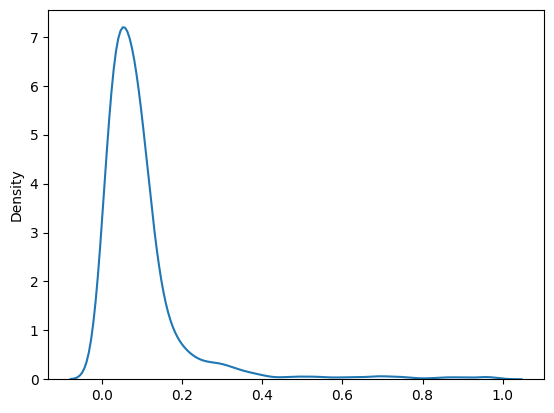

In [57]:
sns.kdeplot(upper_triangular_values)

In [58]:
for i in np.arange(90, 100, 1): 
    print(i, np.percentile(upper_triangular_values, i))

90 0.1790539930631635
91 0.19392203041250075
92 0.20763186136878256
93 0.22710216015197843
94 0.25691943681315216
95 0.2844840710508617
96 0.30761346549009627
97 0.3612074457331994
98 0.512372713252986
99 0.707351014344957


In [59]:
df = threshold_transform(df, threshold=0.5)
df

,HMV23/000059/0923/1,HMV23/000059/0923/2,HMV23/000059/0923/3,HMV23/000059/0923/4,HMV23/000059/0923/5,HMV23/000059/0923/6,HMV23/000059/0923/7,HMV23/000059/0923/8,HMV23/000059/0923/9,HMV23/000059/0923/10,...,HMV23/000043/0823/6,HMV23/000043/0823/7,HMV23/000043/0823/8,HMV23/000043/0823/9,HMV23/000043/0823/10,HMV23/000043/0823/11,HMV23/000043/0823/12,HMV23/000043/0823/13,HMV23/000043/0823/14,HMV23/000043/0823/15
HMV23/000059/0923/1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
HMV23/000059/0923/2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HMV23/000059/0923/3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HMV23/000059/0923/4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
HMV23/000059/0923/5,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HMV23/000043/0823/11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HMV23/000043/0823/12,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
HMV23/000043/0823/13,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
HMV23/000043/0823/14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [60]:
df.to_csv('cos_sim_dec_cor_ones_zeros.csv', index=True)

In [61]:
obsv_cluster = dict()

for i in range(df.shape[0]):
    for j in range(i+1, df.shape[1]):
        if df.iloc[i, j] == 1:
            if df.columns[i] != df.columns[j]:
                if df.columns[i] in obsv_cluster:
                    obsv_cluster[df.columns[i]].append(df.columns[j])
                else:
                    obsv_cluster[df.columns[i]] = [df.columns[j]]

In [62]:
obsv_cluster

{'HMV23/000059/0923/1': ['HMV23/000059/0923/5',
  'HMV23/000055/0923/2',
  'HMV23/000055/0923/6',
  'HMV23/000043/0823/12'],
 'HMV23/000059/0923/3': ['HMV23/000055/0923/17'],
 'HMV23/000059/0923/4': ['HMV23/000055/0923/21'],
 'HMV23/000059/0923/5': ['HMV23/000055/0923/2',
  'HMV23/000055/0923/6',
  'HMV23/000043/0823/12'],
 'HMV23/000059/0923/6': ['HMV23/000059/0923/8',
  'HMV23/000059/0923/9',
  'HMV23/000055/0923/13',
  'HMV23/000055/0923/14'],
 'HMV23/000059/0923/7': ['HMV23/000055/0923/12'],
 'HMV23/000059/0923/8': ['HMV23/000059/0923/9',
  'HMV23/000055/0923/13',
  'HMV23/000055/0923/14'],
 'HMV23/000059/0923/9': ['HMV23/000055/0923/13', 'HMV23/000055/0923/14'],
 'HMV23/000059/0923/10': ['HMV23/000055/0923/22'],
 'HMV23/000059/0923/11': ['HMV23/000055/0923/15'],
 'HMV23/000059/0923/12': ['HMV23/000055/0923/24'],
 'HMV23/000059/0923/15': ['HMV23/000055/0923/10'],
 'HMV23/000059/0923/16': ['HMV23/000055/0923/23'],
 'HMV23/000059/0923/17': ['HMV23/000055/0923/25'],
 'HMV23/000055/092

In [63]:
# obsv_cluster

In [69]:
from pyvis.network import Network

# Create a pyvis network instance
net = Network(height="800px", width="100%", notebook=True)

# Add nodes to the network
for key, values in obsv_cluster.items():
    net.add_node(key)
    for value in values:
        net.add_node(value)  
        net.add_edge(key, value)

# Save the interactive graph to an HTML file
net.show("graph_visualization_des_cor_2.html")

graph_visualization_des_cor_2.html


In [64]:
task_obsv_cluster = dict()
for i in list(obsv_cluster.items()):
    if str(task[task['Log Item #'] == i[0]]['Source Task/Discrep. #'].values.tolist()[0]) in task_obsv_cluster:
        task_obsv_cluster[str(task[task['Log Item #'] == i[0]]['Source Task/Discrep. #'].values.tolist()[0])].append({i[0]:i[1]})
    else:
        task_obsv_cluster[str(task[task['Log Item #'] == i[0]]['Source Task/Discrep. #'].values.tolist()[0])] = [{i[0]:i[1]}]   

In [65]:
task_obsv_cluster

{'AIRCRAFT ARRIVAL INSPECTION': [{'HMV23/000059/0923/1': ['HMV23/000059/0923/5',
    'HMV23/000055/0923/2',
    'HMV23/000055/0923/6',
    'HMV23/000043/0823/12']},
  {'HMV23/000059/0923/3': ['HMV23/000055/0923/17']},
  {'HMV23/000059/0923/4': ['HMV23/000055/0923/21']},
  {'HMV23/000059/0923/5': ['HMV23/000055/0923/2',
    'HMV23/000055/0923/6',
    'HMV23/000043/0823/12']},
  {'HMV23/000059/0923/6': ['HMV23/000059/0923/8',
    'HMV23/000059/0923/9',
    'HMV23/000055/0923/13',
    'HMV23/000055/0923/14']},
  {'HMV23/000059/0923/7': ['HMV23/000055/0923/12']},
  {'HMV23/000059/0923/8': ['HMV23/000059/0923/9',
    'HMV23/000055/0923/13',
    'HMV23/000055/0923/14']},
  {'HMV23/000059/0923/9': ['HMV23/000055/0923/13', 'HMV23/000055/0923/14']},
  {'HMV23/000059/0923/15': ['HMV23/000055/0923/10']},
  {'HMV23/000055/0923/1': ['HMV23/000055/0923/7',
    'HMV23/000055/0923/8',
    'HMV23/000055/0923/9']},
  {'HMV23/000055/0923/2': ['HMV23/000055/0923/6', 'HMV23/000043/0823/12']},
  {'HMV23/000

In [67]:
# Adding a task manually
task_obsv_cluster['AWR23/002877/0923'] = [{'HMV23/000059/0923/14':''}]
task_obsv_cluster['AWR23/003125/0923'] = [{'HMV23/000059/0923/21':''}]
task_obsv_cluster['262300-02-1'] = [{'HMV23/000055/0923/26': ''}]
task_obsv_cluster['AWR23/002577/0823'] = [{'HMV23/000043/0823/2':''}]
task_obsv_cluster['353000-07-1'] = [{'HMV23/000043/0823/14':''}]
# task_obsv_cluster['353000-07-1'] = [{'HMV23/000043/0823/14':''}]
# task_obsv_cluster['262300-02-1'] = [{'HMV23/000059/0923/21':''}]
# task_obsv_cluster['AWR23/002877/0923'] = [{'HMV23/000059/0923/14':''}]                              
# task_obsv_cluster['AWR23/002555/0823'] = [{'HMV23/000043/0823/7':''}]
# task_obsv_cluster['AWR23/002577/0823'] = [{'HMV23/000043/0823/2':''}]

In [68]:
from pyvis.network import Network


# Create a pyvis network instance
net1 = Network(height="800px", width="100%", notebook=True)

# Add nodes and edges to the network
for key, values in task_obsv_cluster.items():
    net1.add_node(key, color="red")
    for edge_dict in values:
        for edge_key, edge_values in edge_dict.items():
            net1.add_node(edge_key)
            net1.add_edge(key, edge_key)
            for edge_value in edge_values:
                net1.add_node(edge_value)
                net1.add_edge(edge_key, edge_value)

# Add a heading to the HTML content
heading_html = "<h1>Task Clusters Graph Visualization</h1>"
net1.html = heading_html + net1.html

# Save the interactive graph to an HTML file
net1.show("task_graph_visualization_des_cor_2.html")


task_graph_visualization_des_cor_2.html


In [88]:
# Get clusters based on edge relationships
clusters = {}
for edge in net.edges:
    source = edge['from']
    target = edge['to']

    if source not in clusters:
        clusters[source] = set([source, target])
    else:
        clusters[source].add(target)

# Convert clusters to a dictionary where values are lists
clusters_list = {key: list(value) for key, value in clusters.items()}

# Print clusters as lists
cnt = 0
for key, value in clusters_list.items():
    cnt += 1
    print(f"Group : {value}")

print(f"Total groups : {cnt}")

Group : ['HMV23/000059/0923/5', 'HMV23/000055/0923/2', 'HMV23/000043/0823/12', 'HMV23/000059/0923/1', 'HMV23/000055/0923/6']
Group : ['HMV23/000059/0923/3', 'HMV23/000055/0923/17']
Group : ['HMV23/000059/0923/4', 'HMV23/000055/0923/21']
Group : ['HMV23/000055/0923/6', 'HMV23/000043/0823/12', 'HMV23/000059/0923/5', 'HMV23/000055/0923/2']
Group : ['HMV23/000055/0923/14', 'HMV23/000059/0923/6', 'HMV23/000055/0923/13', 'HMV23/000059/0923/8', 'HMV23/000059/0923/9']
Group : ['HMV23/000055/0923/12', 'HMV23/000059/0923/7']
Group : ['HMV23/000059/0923/8', 'HMV23/000059/0923/9', 'HMV23/000055/0923/14', 'HMV23/000055/0923/13']
Group : ['HMV23/000059/0923/9', 'HMV23/000055/0923/14', 'HMV23/000055/0923/13']
Group : ['HMV23/000055/0923/22', 'HMV23/000059/0923/10']
Group : ['HMV23/000055/0923/15', 'HMV23/000059/0923/11']
Group : ['HMV23/000055/0923/24', 'HMV23/000059/0923/12']
Group : ['HMV23/000055/0923/10', 'HMV23/000059/0923/15']
Group : ['HMV23/000059/0923/16', 'HMV23/000055/0923/23']
Group : ['H

In [89]:
list(clusters.values())

[{'HMV23/000043/0823/12',
  'HMV23/000055/0923/2',
  'HMV23/000055/0923/6',
  'HMV23/000059/0923/1',
  'HMV23/000059/0923/5'},
 {'HMV23/000055/0923/17', 'HMV23/000059/0923/3'},
 {'HMV23/000055/0923/21', 'HMV23/000059/0923/4'},
 {'HMV23/000043/0823/12',
  'HMV23/000055/0923/2',
  'HMV23/000055/0923/6',
  'HMV23/000059/0923/5'},
 {'HMV23/000055/0923/13',
  'HMV23/000055/0923/14',
  'HMV23/000059/0923/6',
  'HMV23/000059/0923/8',
  'HMV23/000059/0923/9'},
 {'HMV23/000055/0923/12', 'HMV23/000059/0923/7'},
 {'HMV23/000055/0923/13',
  'HMV23/000055/0923/14',
  'HMV23/000059/0923/8',
  'HMV23/000059/0923/9'},
 {'HMV23/000055/0923/13', 'HMV23/000055/0923/14', 'HMV23/000059/0923/9'},
 {'HMV23/000055/0923/22', 'HMV23/000059/0923/10'},
 {'HMV23/000055/0923/15', 'HMV23/000059/0923/11'},
 {'HMV23/000055/0923/24', 'HMV23/000059/0923/12'},
 {'HMV23/000055/0923/10', 'HMV23/000059/0923/15'},
 {'HMV23/000055/0923/23', 'HMV23/000059/0923/16'},
 {'HMV23/000055/0923/25', 'HMV23/000059/0923/17'},
 {'HMV23/0

In [90]:
def create_groups(edges):
    # Create an adjacency list from the edges
    adj_list = {}
    for edge in edges:
        for node in edge:
            adj_list.setdefault(node, set()).update(edge - {node})

    # Function to perform depth-first search (DFS)
    def dfs(node, visited, group):
        visited.add(node)
        group.add(node)
        for neighbor in adj_list.get(node, []):
            if neighbor not in visited:
                dfs(neighbor, visited, group)

    # Initialize variables
    visited = set()
    groups = []

    # Traverse the graph using DFS
    for node in adj_list.keys():
        if node not in visited:
            group = set()
            dfs(node, visited, group)
            groups.append(list(group))

    return groups


source_task_logitems = create_groups(list(clusters.values()))
print(source_task_logitems)


[['HMV23/000059/0923/5', 'HMV23/000055/0923/2', 'HMV23/000043/0823/12', 'HMV23/000059/0923/1', 'HMV23/000055/0923/6'], ['HMV23/000059/0923/3', 'HMV23/000055/0923/17'], ['HMV23/000059/0923/4', 'HMV23/000055/0923/21'], ['HMV23/000055/0923/14', 'HMV23/000059/0923/6', 'HMV23/000055/0923/13', 'HMV23/000059/0923/8', 'HMV23/000059/0923/9'], ['HMV23/000055/0923/12', 'HMV23/000059/0923/7'], ['HMV23/000055/0923/22', 'HMV23/000059/0923/10'], ['HMV23/000055/0923/15', 'HMV23/000059/0923/11'], ['HMV23/000055/0923/24', 'HMV23/000059/0923/12'], ['HMV23/000055/0923/10', 'HMV23/000059/0923/15'], ['HMV23/000059/0923/16', 'HMV23/000055/0923/23'], ['HMV23/000059/0923/17', 'HMV23/000055/0923/25'], ['HMV23/000055/0923/9', 'HMV23/000055/0923/1', 'HMV23/000055/0923/8', 'HMV23/000055/0923/7'], ['HMV23/000055/0923/19', 'HMV23/000055/0923/20'], ['HMV23/000043/0823/5', 'HMV23/000043/0823/3'], ['HMV23/000043/0823/7', 'HMV23/000043/0823/10'], ['HMV23/000043/0823/9', 'HMV23/000043/0823/8']]


In [91]:
source_task_logitems

[['HMV23/000059/0923/5',
  'HMV23/000055/0923/2',
  'HMV23/000043/0823/12',
  'HMV23/000059/0923/1',
  'HMV23/000055/0923/6'],
 ['HMV23/000059/0923/3', 'HMV23/000055/0923/17'],
 ['HMV23/000059/0923/4', 'HMV23/000055/0923/21'],
 ['HMV23/000055/0923/14',
  'HMV23/000059/0923/6',
  'HMV23/000055/0923/13',
  'HMV23/000059/0923/8',
  'HMV23/000059/0923/9'],
 ['HMV23/000055/0923/12', 'HMV23/000059/0923/7'],
 ['HMV23/000055/0923/22', 'HMV23/000059/0923/10'],
 ['HMV23/000055/0923/15', 'HMV23/000059/0923/11'],
 ['HMV23/000055/0923/24', 'HMV23/000059/0923/12'],
 ['HMV23/000055/0923/10', 'HMV23/000059/0923/15'],
 ['HMV23/000059/0923/16', 'HMV23/000055/0923/23'],
 ['HMV23/000059/0923/17', 'HMV23/000055/0923/25'],
 ['HMV23/000055/0923/9',
  'HMV23/000055/0923/1',
  'HMV23/000055/0923/8',
  'HMV23/000055/0923/7'],
 ['HMV23/000055/0923/19', 'HMV23/000055/0923/20'],
 ['HMV23/000043/0823/5', 'HMV23/000043/0823/3'],
 ['HMV23/000043/0823/7', 'HMV23/000043/0823/10'],
 ['HMV23/000043/0823/9', 'HMV23/000043

In [92]:
for i in source_task_logitems:
    print(len(i))

5
2
2
5
2
2
2
2
2
2
2
4
2
2
2
2


In [93]:
task_cd

,Log Item #,Source Task/Discrep. #,Corrective Action and Description
0,HMV23/000059/0923/1,AIRCRAFT ARRIVAL INSPECTION,1. CARRIED OUT INSTALLATION OF LH WING SLAT #0...
1,HMV23/000059/0923/2,AIRCRAFT ARRIVAL INSPECTION,CARRIED OUT TROUBLESHOOTING IAW TSM TASK 31-32...
2,HMV23/000059/0923/3,AIRCRAFT ARRIVAL INSPECTION,STATIC DISCHARGERS REPLACED AT FOLLOWING LOCAT...
3,HMV23/000059/0923/4,AIRCRAFT ARRIVAL INSPECTION,1. CARRIED OUT REPLACEMENT OF SERVICE LIGHT LA...
4,HMV23/000059/0923/5,AIRCRAFT ARRIVAL INSPECTION,"1) RH SIDE WING NO#1 SLAT, NO.3 TRACK SQURE SE..."
...,...,...,...
57,HMV23/000043/0823/11,AIRCRAFT ARRIVAL INSPECTION,"POST INSTALLATION OF #2 LH AND RH WING SLATS, ..."
58,HMV23/000043/0823/12,AIRCRAFT ARRIVAL INSPECTION,CARRIED OUT INSTALLATION OF RH WING SLAT #5 OU...
59,HMV23/000043/0823/13,AIRCRAFT ARRIVAL INSPECTION,CARRIED OUT REPLACEMENT OF STATIC DISCHARGERS ...
60,HMV23/000043/0823/14,353000-07-1,CARRIED OUT G1 GALLEY PORTABLE OXYGEN MASK REP...


In [94]:
src_task_groups = []
for i in source_task_logitems:
    temp = []
    for j in i:
        temp.append(task[task['Log Item #'] == j]['Source Task/Discrep. #'].values[0])
    src_task_groups.append(list(set(temp)))  # remove duplicates in temp)
src_task_groups

[['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['215222-01-1 (LH)'],
 ['531900-03-1'],
 ['384241-01-1'],
 ['AIRCRAFT ARRIVAL INSPECTION', 'AWR23/003086/0923'],
 ['WEAR LIMITS- BONDING LEADS'],
 ['252100-01-1'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AIRCRAFT ARRIVAL INSPECTION'],
 ['AWR23/002555/0823'],
 ['AIRCRAFT ARRIVAL INSPECTION']]

In [95]:
task_cd['Source Task/Discrep. #'].value_counts()

Source Task/Discrep. #
AIRCRAFT ARRIVAL INSPECTION    41
215222-01-1 (LH)                4
WEAR LIMITS- BONDING LEADS      3
531900-03-1                     2
384241-01-1                     2
252100-01-1                     2
AWR23/002555/0823               2
AWR23/002877/0923               1
AWR23/003125/0923               1
AWR23/003086/0923               1
262300-02-1                     1
AWR23/002577/0823               1
353000-07-1                     1
Name: count, dtype: int64

In [97]:
src_task_description = []
for i in source_task_logitems:
    temp = []
    for j in i:
        temp.append(task_cd[task_cd['Log Item #'] == j]['Corrective Action and Description'].values[0])
    src_task_description.append(temp)
src_task_description

[['1) RH SIDE WING NO#1 SLAT, NO.3 TRACK SQURE SEAL UPPER BULB SEAL REPLACED AS PER AMM 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY.\n\n2) RH WING SLAT #5 OUT BOARD WEATHER SEAL REPLACED AS PER AMM 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY. DURING ARRIVAL INSPECTION , OBSERVED FOLLOWINS DICREPANCIES.\n\n1) RH SIDE WING NO#1 SLAT, NO.3 TRACK SQURE SEAL UPPER BULB SEAL DEGRADED.\n2) RH SIIDE WING SLAT NO#5 OUT BOARD WEATHER SEAL ERODED. SAME TO BE REPLACED.',
  'CARRIED OUT INSTALLATION OF LH WING SLAT #5 OUT BOARD WEATHER SEAL AS PER STANDARD PRACTICES 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY. DURING INSPECTION OBSERVED LH WING SLAT#5 WEATHER SEAL ERODED.SAME TO BE REPLACED.',
  'CARRIED OUT INSTALLATION OF RH WING SLAT #5 OUT BOARD WEATHER SEAL AS PER STANDARD PRACTICES 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION

In [98]:
result_dict = {}

# Zip the corresponding elements from three lists
zipped_elements = zip(source_task_logitems, src_task_groups, src_task_description)

# Iterate over the zipped elements to create the result dictionary
for i, elements in enumerate(zipped_elements, start=1):
    group_key = f'group_{i}'
    result_dict[group_key] = {
        'logItem': elements[0],
        'sourceTask': elements[1],
        'Corrective Action and Description': elements[2],
        'frequency': len(elements[0]),
    }

# Print the resulting dictionary
print(result_dict)

{'group_1': {'logItem': ['HMV23/000059/0923/5', 'HMV23/000055/0923/2', 'HMV23/000043/0823/12', 'HMV23/000059/0923/1', 'HMV23/000055/0923/6'], 'sourceTask': ['AIRCRAFT ARRIVAL INSPECTION'], 'Corrective Action and Description': ['1) RH SIDE WING NO#1 SLAT, NO.3 TRACK SQURE SEAL UPPER BULB SEAL REPLACED AS PER AMM 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY.\n\n2) RH WING SLAT #5 OUT BOARD WEATHER SEAL REPLACED AS PER AMM 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY. DURING ARRIVAL INSPECTION , OBSERVED FOLLOWINS DICREPANCIES.\n\n1) RH SIDE WING NO#1 SLAT, NO.3 TRACK SQURE SEAL UPPER BULB SEAL DEGRADED.\n2) RH SIIDE WING SLAT NO#5 OUT BOARD WEATHER SEAL ERODED. SAME TO BE REPLACED.', 'CARRIED OUT INSTALLATION OF LH WING SLAT #5 OUT BOARD WEATHER SEAL AS PER STANDARD PRACTICES 20-21-11-911-001-A, REV 72, DT-01 AUG 2023.SECURITY OF INSTALLATION CHECK FOUND SATISFACTORY. DURING INSPECTION OBSERVE

In [99]:
result_dict.keys()

dict_keys(['group_1', 'group_2', 'group_3', 'group_4', 'group_5', 'group_6', 'group_7', 'group_8', 'group_9', 'group_10', 'group_11', 'group_12', 'group_13', 'group_14', 'group_15', 'group_16'])

In [100]:
from prettytable import PrettyTable

# Create a pretty table
table = PrettyTable()
table.field_names = ["Group", "Log Item", "Source Task", "Corrective Action and Description", "Frequency"]

# Populate the table with data
for group, data in result_dict.items():
    table.add_row([group, data['logItem'], data['sourceTask'], data['Corrective Action and Description'], data['frequency']])

# Print the pretty table
print(table)

+----------+-----------------------------------------------------------------------------------------------------------------------+------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [101]:
from prettytable import PrettyTable

# Create a pretty table
table = PrettyTable()
table.field_names = ["Group", "Log Item", "Source Task", "Frequency"]

# Populate the table with data
for group, data in result_dict.items():
    table.add_row([group, data['logItem'], data['sourceTask'], data['frequency']])

# Print the pretty table
print(table)

+----------+-----------------------------------------------------------------------------------------------------------------------+------------------------------------------------------+-----------+
|  Group   |                                                        Log Item                                                       |                     Source Task                      | Frequency |
+----------+-----------------------------------------------------------------------------------------------------------------------+------------------------------------------------------+-----------+
| group_1  |  ['HMV23/000059/0923/5', 'HMV23/000055/0923/2', 'HMV23/000043/0823/12', 'HMV23/000059/0923/1', 'HMV23/000055/0923/6'] |           ['AIRCRAFT ARRIVAL INSPECTION']            |     5     |
| group_2  |                                    ['HMV23/000059/0923/3', 'HMV23/000055/0923/17']                                    |           ['AIRCRAFT ARRIVAL INSPECTION']            |     2     |
